In [1]:
# imports from custom library
import sys
sys.path.append('../../../')
import matplotlib.pyplot as plt
from mlrefined_libraries import basics_library as baslib
from mlrefined_libraries import calculus_library as callib
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import linear_algebra_library as linlib
import autograd.numpy as np
import time

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# Lecture 9: Optimization tricks part 1

In this lecture we talk about our first batch of new optimization tricks that can help us overcome common problems encountered when optimizing nonlinear supervised learners like neural networks.

Press the button 'Toggle code' below to toggle code on and off for entire this presentation.  

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

# Normalized Gradient Descent

- Thus far we have been using gradient descent steps of the form

$$
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g(\mathbf{w}^{\,k-1})
$$

- This is - more technically speaking - called *unnormalized gradient descent* - why this name?

- Because we only care about the descent *direction* when taking steps, and **not its magnitude**

- So technically speaking we can instead take steps in the unit-direction given by the negative gradient: i.e., $- \frac{\nabla g(\mathbf{w})}{\left\Vert \nabla g(\mathbf{w}) \right\Vert_2 }$

- Note that this means we normalize each partial derivative evaluation by the length of the entire gradient

$$
-\frac{\nabla g(\mathbf{w})}{\left\Vert \nabla g(\mathbf{w}) \right\Vert_2 } = 
\begin{bmatrix}
\frac{-\frac{\partial}{\partial w_1}g\left(\mathbf{w}\right)}{\left\Vert \nabla g(\mathbf{w}) \right\Vert_2} \\
\frac{-\frac{\partial}{\partial w_2}g\left(\mathbf{w}\right)}{\left\Vert \nabla g(\mathbf{w}) \right\Vert_2} \\
\vdots \\
\frac{-\frac{\partial}{\partial w_N}g\left(\mathbf{w}\right)}{\left\Vert \nabla g(\mathbf{w}) \right\Vert_2}
\end{bmatrix}
$$

- This is the *normalized gradient descent* step

$$
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha\frac{\nabla g(\mathbf{w}^{k-1})}{\left\Vert \nabla g(\mathbf{w}^{k-1}) \right\Vert_2 }
$$

- Our original step is called *unnormalized gradient descent* because we do not normalize the negative gradient direction

$$
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g(\mathbf{w}^{\,k-1})
$$

- Whats the difference between them?

- In term of theoretical things (like convergence) = nothing

- Besides setting $\alpha \longleftarrow \frac{\alpha}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2}$ turns the unnormalized gradient descent step $\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g\left(\mathbf{w}^{\,k-1}\right)$ into a normalized one.

- However in terms of practical engineering usage = quite a bit!   Particularly when using a fixed steplength param $\alpha$ as we have been doing.

- First, notice the distance traveled at an *unnormalized gradient descent* step $\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g(\mathbf{w}^{\,k-1})$

$$
\left\Vert \mathbf{w}^{\,k} - \mathbf{w}^{\,k-1} \right\Vert_2  = \left\Vert -\alpha \nabla g\left(\mathbf{w}^{\,k-1}\right)\right\Vert_2 = \alpha\left\Vert \nabla g\left(\mathbf{w}^{\,k-1}\right) \right\Vert_2
$$

- That is, the distance traveled is equal to the steplength parameter $\alpha$ times the length of the gradient at $\mathbf{w}^{k-1}$

- Hence the parameter $\alpha$ only partially controls the length of each step, the gradient adaptively changes the distance we travel at each step

- **With convex functions:**  this forces initial steps to be quite large but afterwards we slow down a ton since the gradient is vanishing close to a minimum

- This behavior has been fine unless our convex functions have *long narrow valleys* leading to global minima

- **With non-convex functions:** this will force gradient descent to halt near *any stationary point*, including e.g., saddle points

- This behavior is highly undesirable - we want to find minima!

- Now notice the legnt of each step with the *normalized* form of gradient descent $\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha\frac{\nabla g(\mathbf{w}^{k-1})}{\left\Vert \nabla g(\mathbf{w}^{k-1}) \right\Vert_2 }$

- The general length of the $k^{th}$ step is equal to

$$
\left\Vert \mathbf{w}^{\,k} - \mathbf{w}^{\,k-1} \right\Vert_2 = \left\Vert -\alpha \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }\right\Vert_2 = \alpha \left\Vert \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }\right\Vert_2 = \alpha
$$

- It is given *exactly* by the steplength parameter $\alpha$, and does not depend on the length of the gradient

- Hence the normalized descent step $\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha\frac{\nabla g(\mathbf{w}^{k-1})}{\left\Vert \nabla g(\mathbf{w}^{k-1}) \right\Vert_2 }$ will not suffer from 

     - Slowing down on a convex function due to a vanishing gradient

    - Getting caught in the non-minimum stationary point (e.g., a saddle point) of a non-convex function

### Normalized gradient descent

<hr style="height:1px;border:none;color:#555;background-color:#555;"/>
<p style="line-height: 1.7;">

<strong>1:</strong>&nbsp;&nbsp;   <strong>input:</strong> function $g$, steplength $\alpha$, maximum number of steps $K$, and initial point $\mathbf{w}^0$ <br/>

<strong>2:</strong>&nbsp;&nbsp;   $\mathbf{w}_{\text{min}}=\mathbf{w}^0$ <br/>

<strong>3:</strong>&nbsp;&nbsp;   $g_{\text{min}}=g\left(\mathbf{w}^0\right)$ <br/>

<strong>4:</strong>&nbsp;&nbsp;   <code>for</code> $\,\,k = 1...K$<br/>

<strong>5:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;           compute $\nabla g\left(\mathbf{w}^{k-1}\right)$ <br/>

<strong>6:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;           <code>if</code> $\left\Vert \nabla g\left(\mathbf{w}^{k-1}\right)\right\Vert _{2}=0$  <br/>

<strong>7:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                 set $\nabla g\left(\mathbf{w}^{k-1}\right)$ to a small nonzero random vector <br/>

<strong>8:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;           <code>end if</code> <br/>

<strong>9:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;           $\mathbf{d}^{k-1} =\frac{\nabla g\left(\mathbf{w}^{k-1}\right)}{\left\Vert \nabla g\left(\mathbf{w}^{k-1}\right)\right\Vert _{2}}$ <br/>

<strong>10:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        $\mathbf{w}^k = \mathbf{w}^{k-1} - \alpha \mathbf{d}^{k-1}$ <br/>

<strong>11:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;          <code>if</code> $g\left(\mathbf{w}^k\right) < g_{\text{min}}$  <br/>

<strong>12:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                $\mathbf{w}_{\text{min}}=\mathbf{w}^k$ <br/>

<strong>13:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                $g_{\text{min}}=g\left(\mathbf{w}^k\right)$ <br/>

<strong>14:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;          <code>end if</code> <br/>

<strong>15:</strong>&nbsp;   <code>end for</code> <br/>

<strong>16:</strong>&nbsp;   <strong>output:</strong> $\mathbf{w}_{\text{min}}$ and $g_{\text{min}}$ <br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;"/>
</p>

From a mathematical point of view the difference between unnormalized and normalized gradient descent is trivial - they describe the same idea.

So why go to the trouble of mentioning both normalized and unnormalized gradient descent methods if they are mathematically the same?

Because *practically speaking* depending on the function being minimized one version of gradient descent can be much easier to employ effectively than another.

### Normalized vs. unnormalized gradient descent

** Behavior on generic convex functions:** Generally speaking the *unnormalized* method is more convenient for use with convex functions (e.g., linear and logistic regression, support vector machines). 
With many smooth convex cost functions the length of each step is tied directly to the magnitude of the gradient, which is advantageous.




#### <span style="color:#a50e3e;">Example 7. </span>  (unnormalized) gradient descent and convex functions

We start by examining a run of unnormalized gradient descent applied to the simple quadratic function

$$
g(w) = w^2
$$

beginning at the point $w^0 = -1.75$.  We fix the steplength parameter $\alpha = 0.1$ and take 30 steps with the method.  What is produced is a now familiar looking animation with a slider widget allowing you to see how gradient descent behaves during this run - moving the slider from left to right animates each step of the process, the color of each step turning from green to red as the process nears completion.

Unnormalized gradient descent in action: fixed steplength, $30$ iterations.


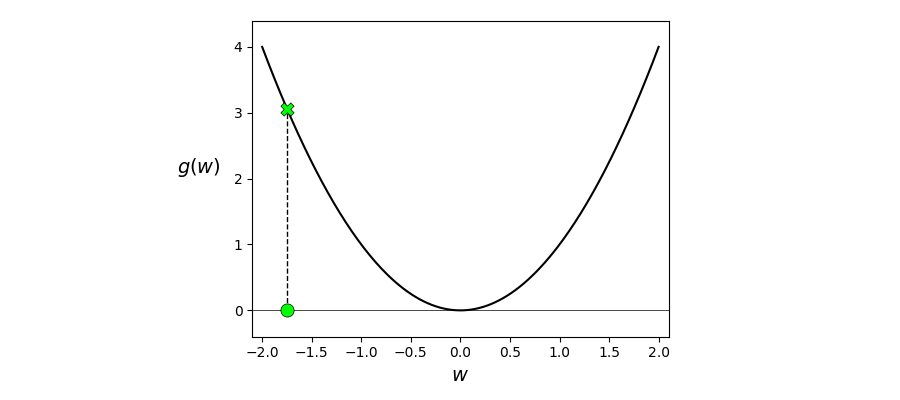
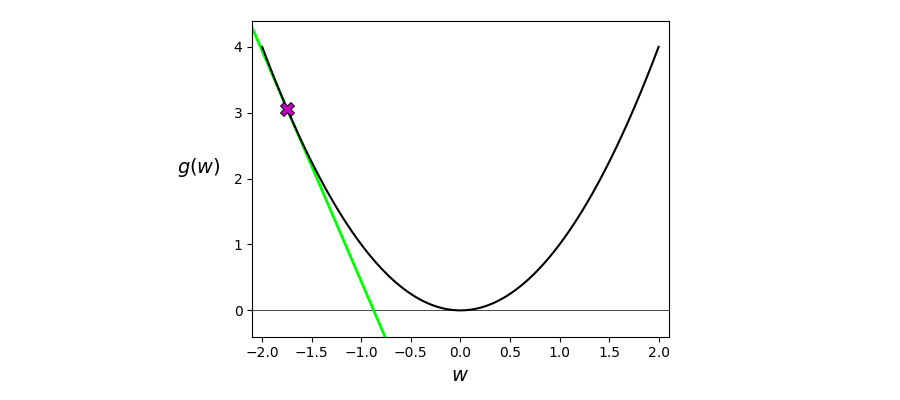
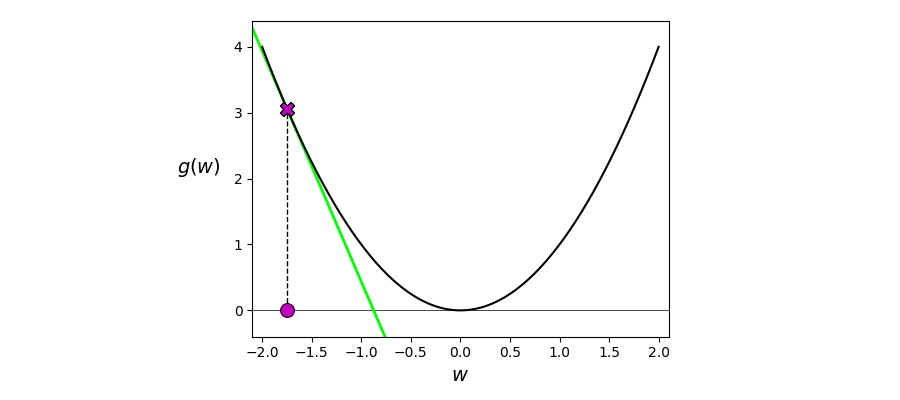
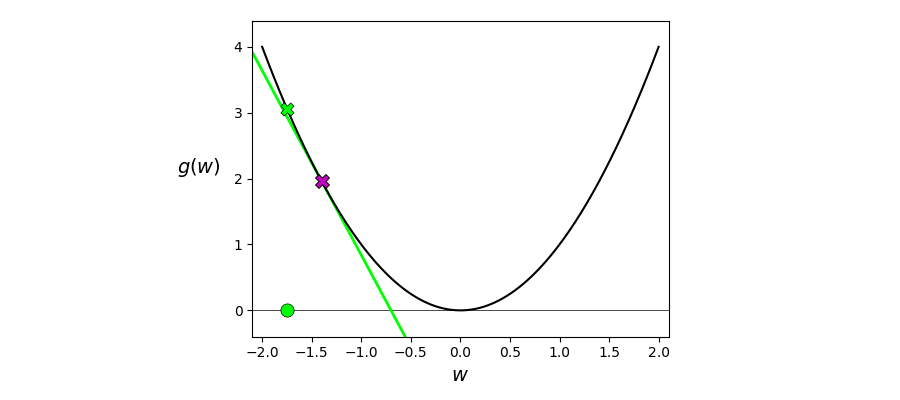
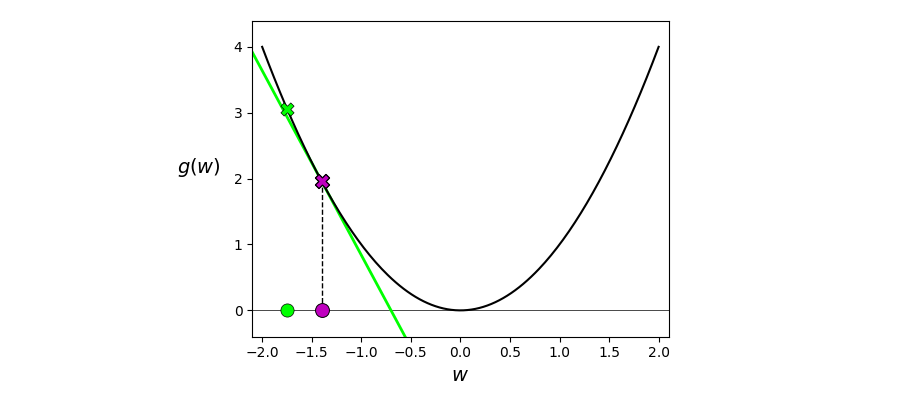
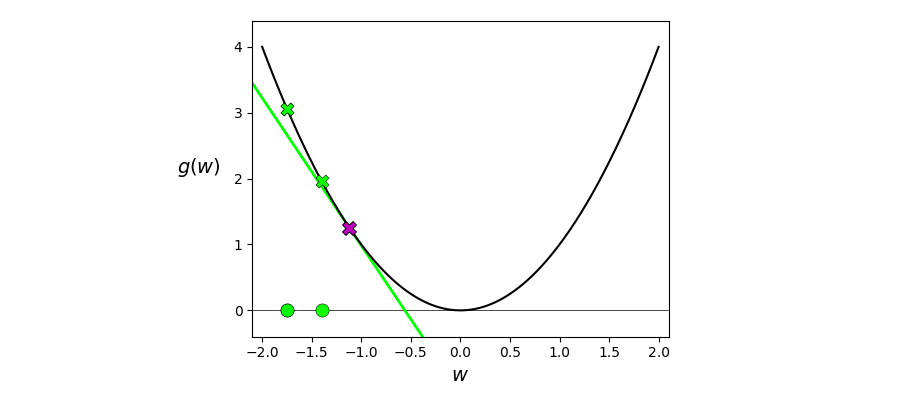
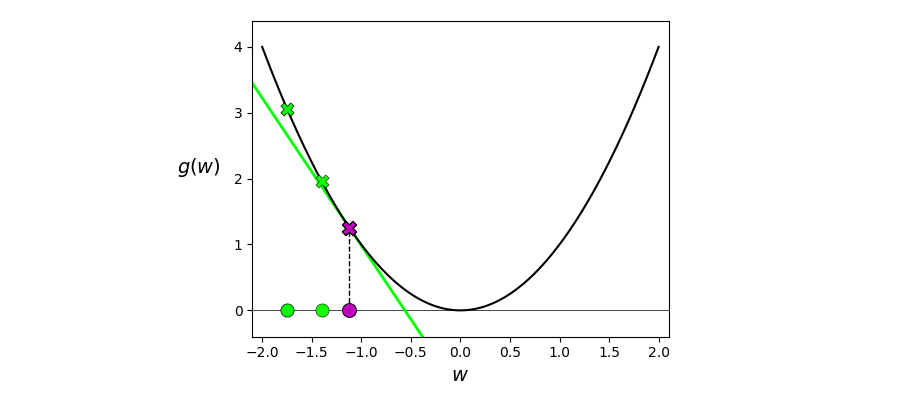
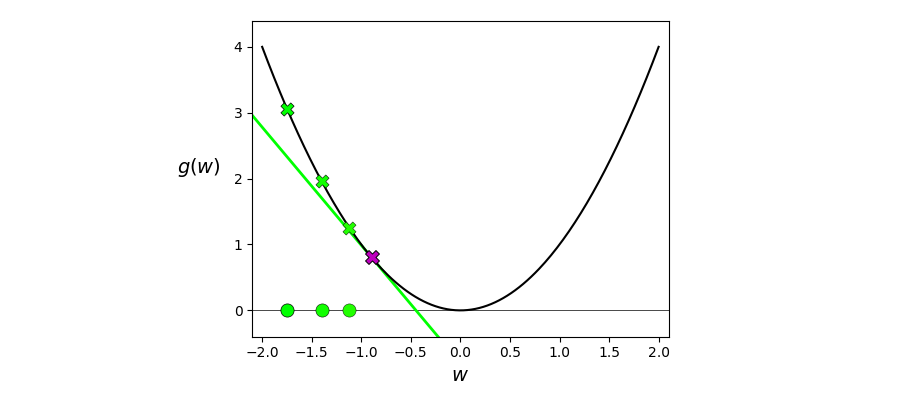
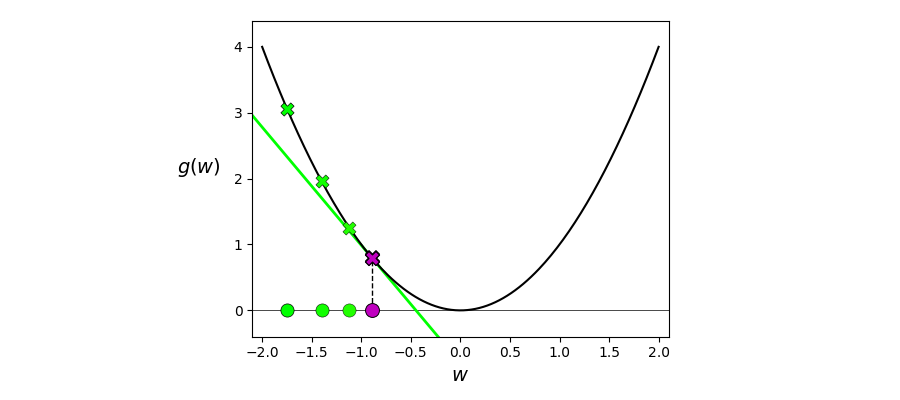
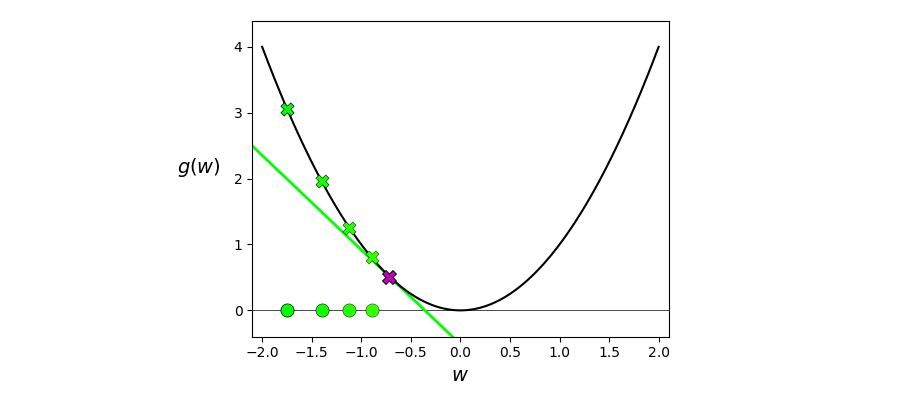
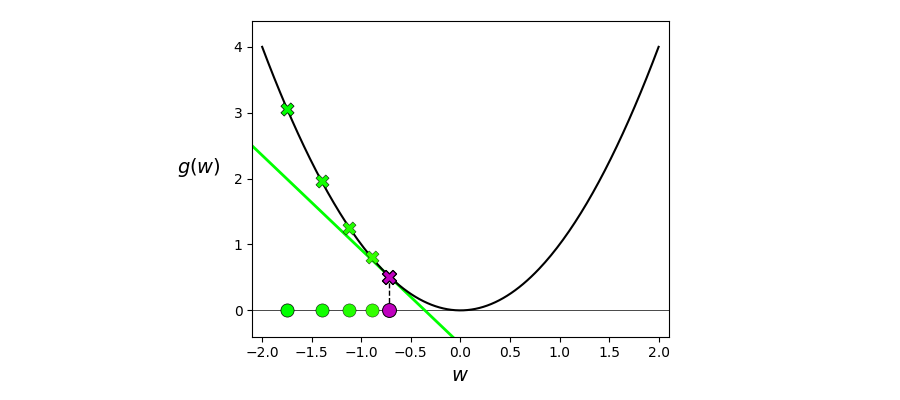
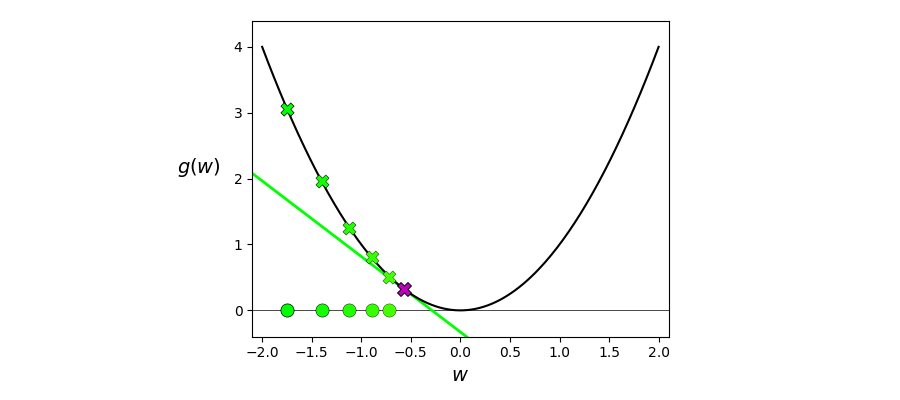
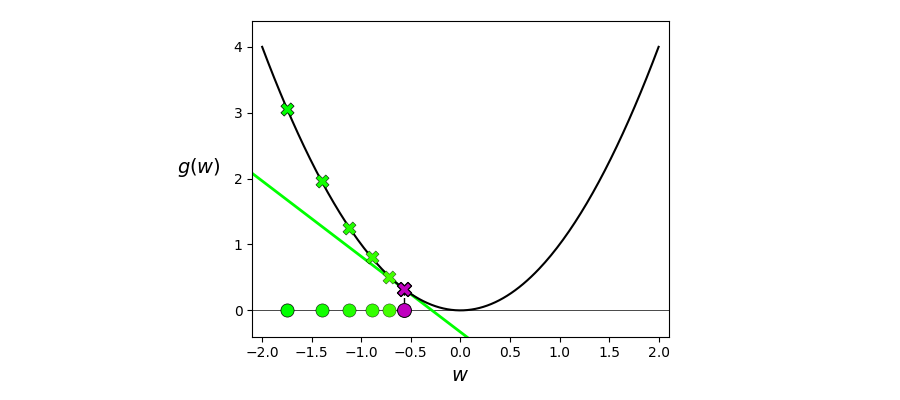
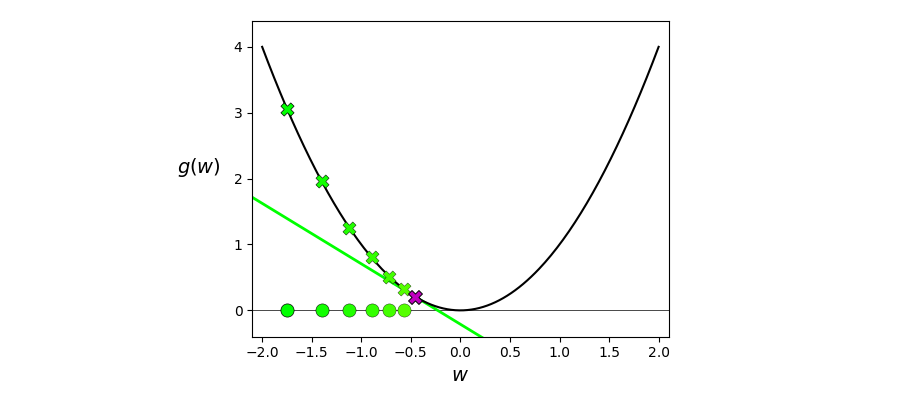
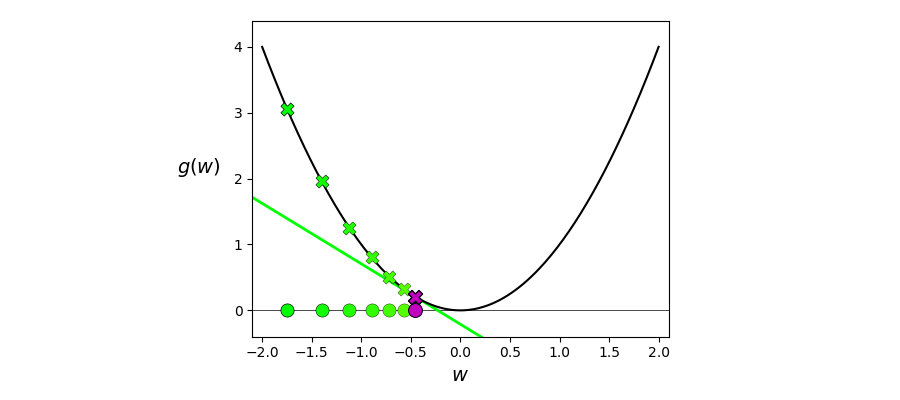
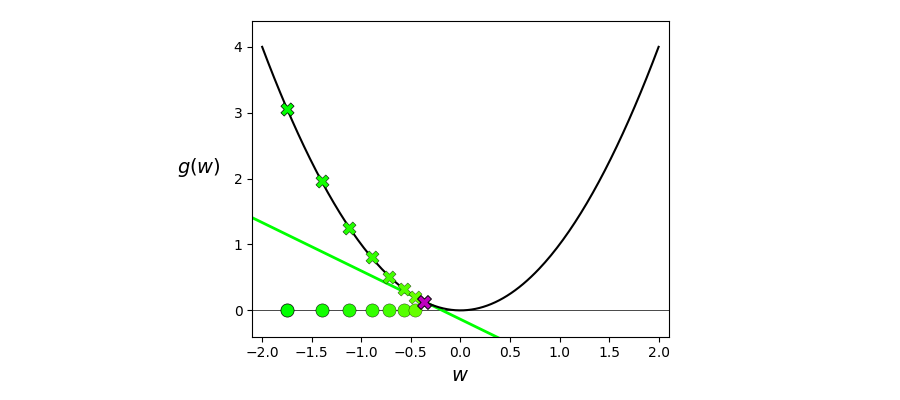
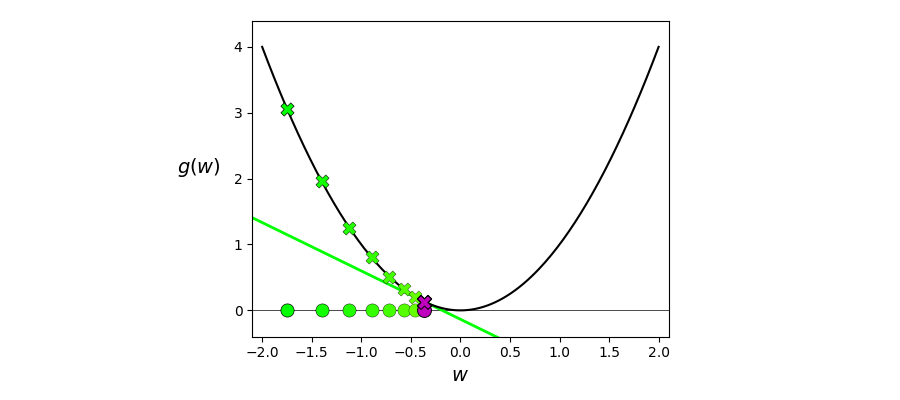
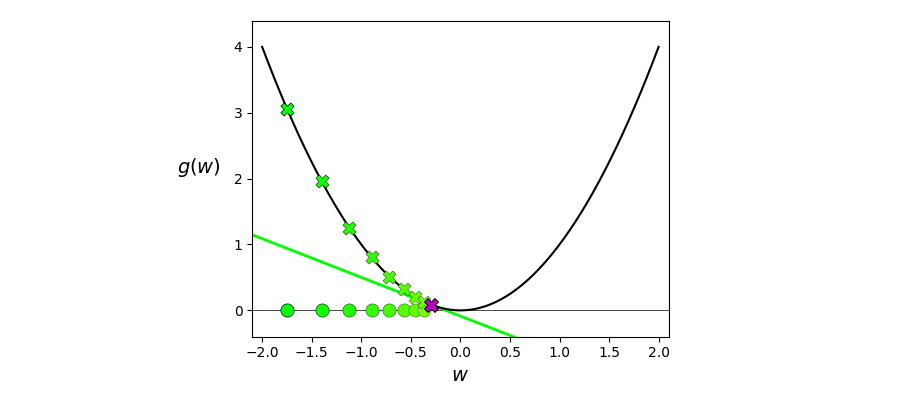
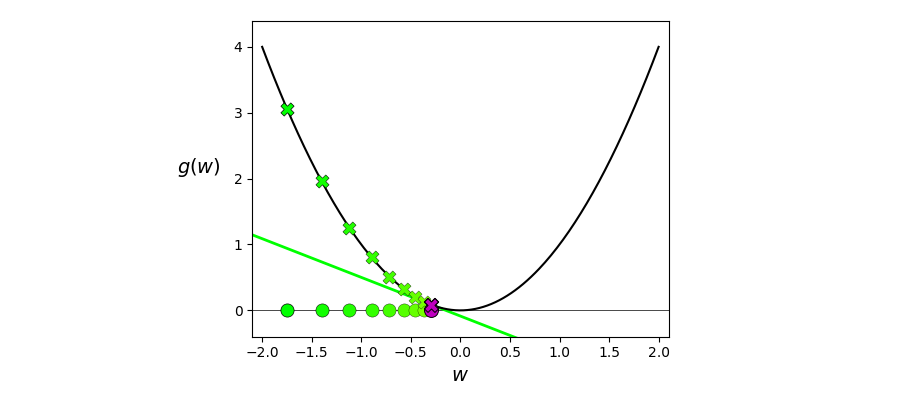
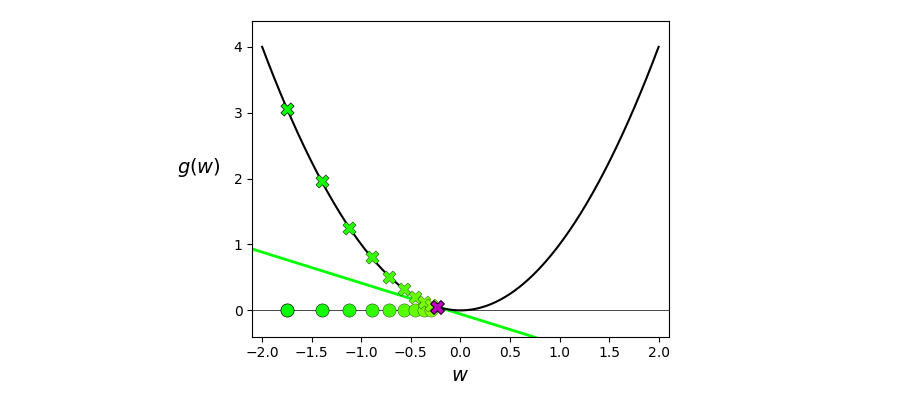
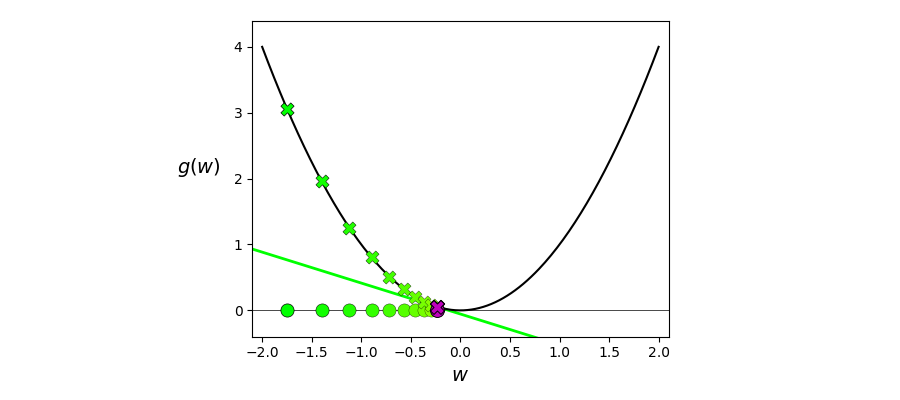
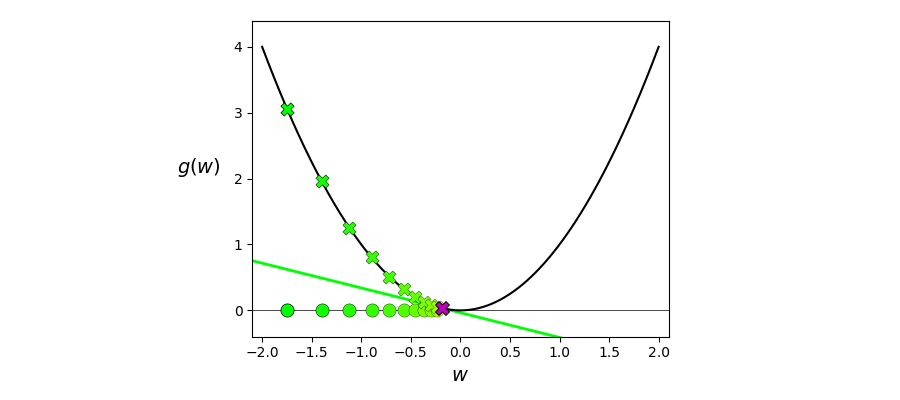
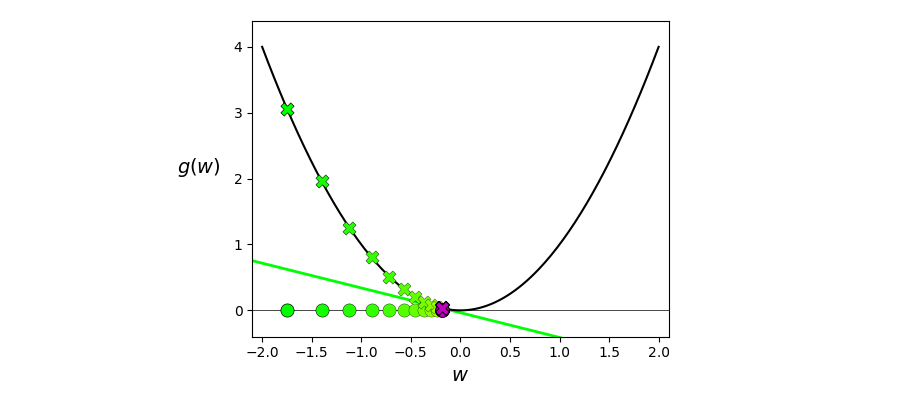
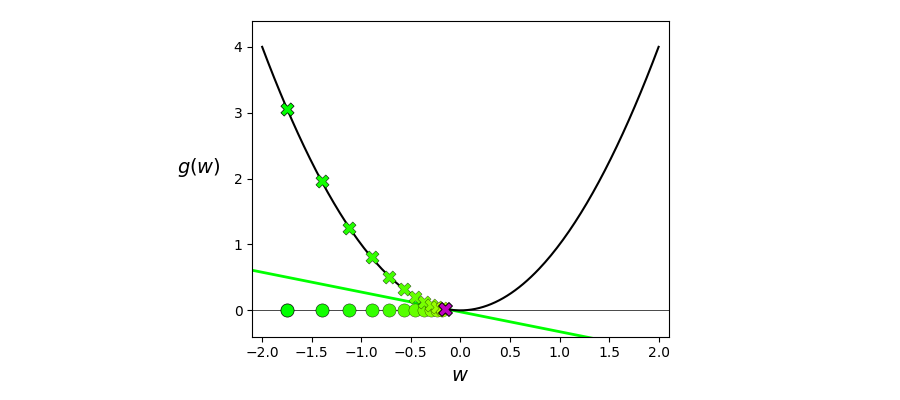
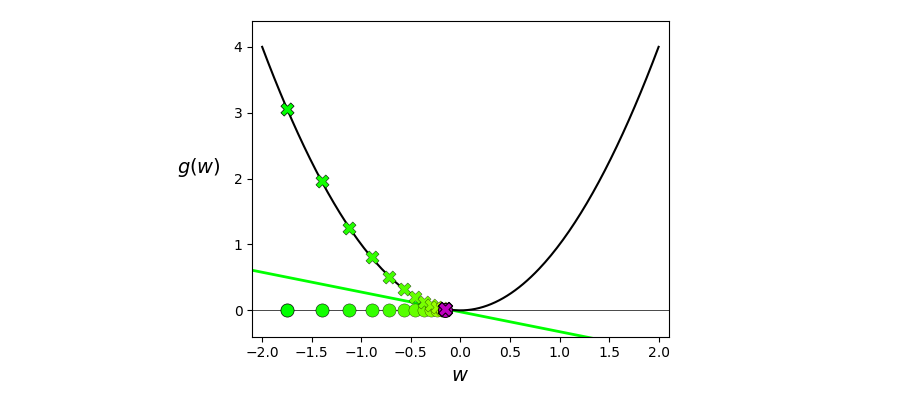
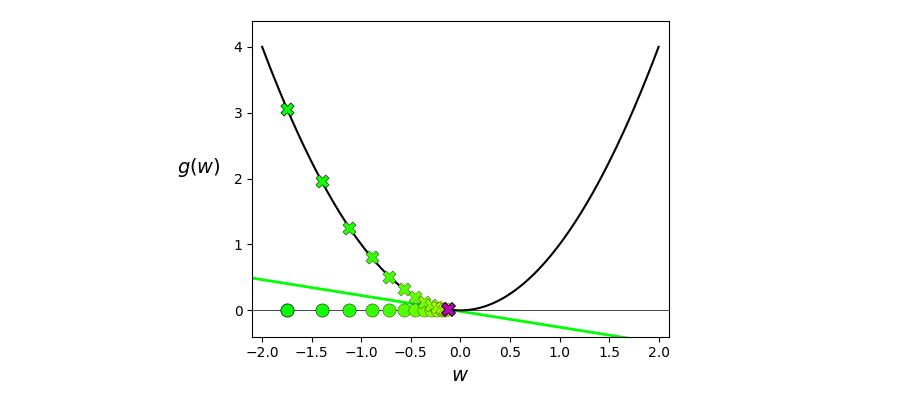
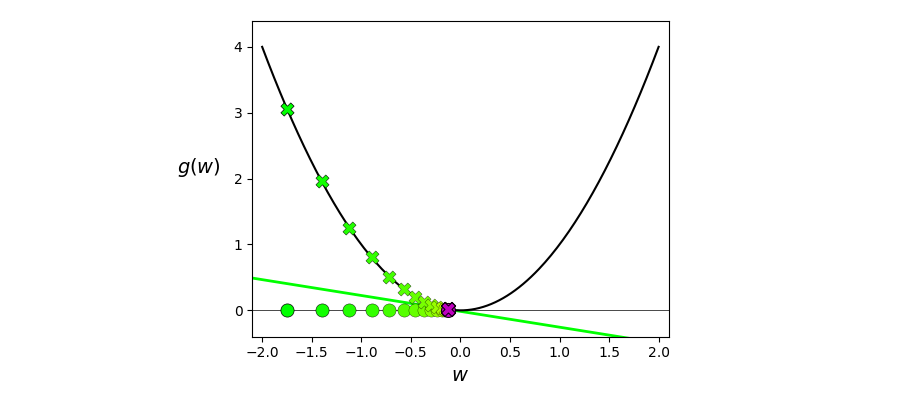
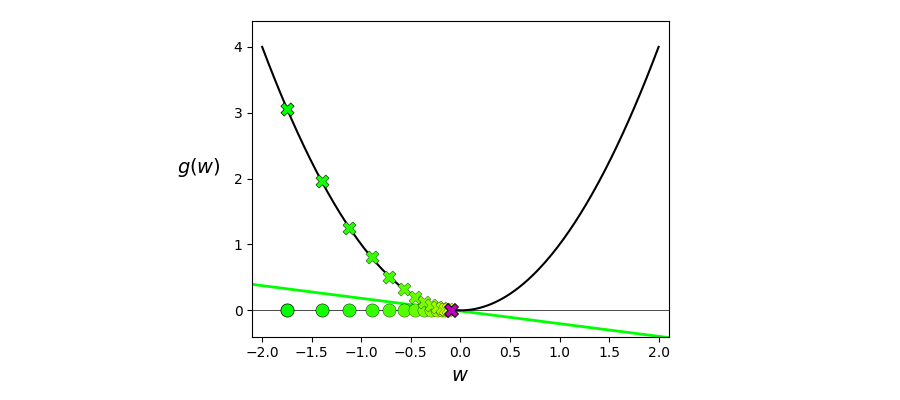
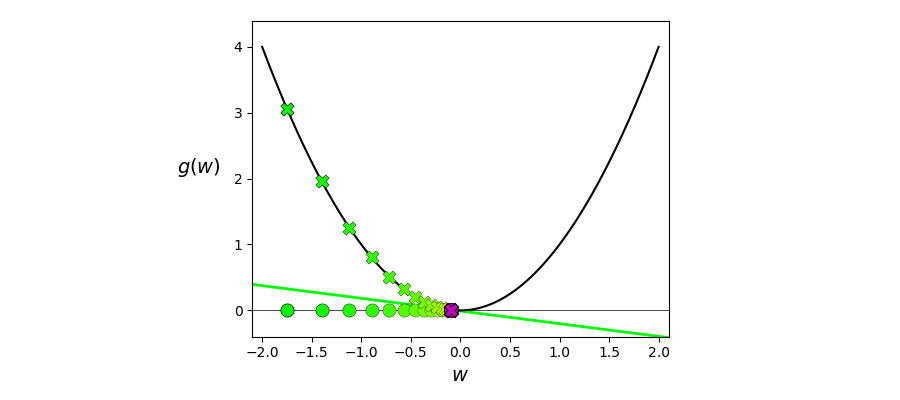
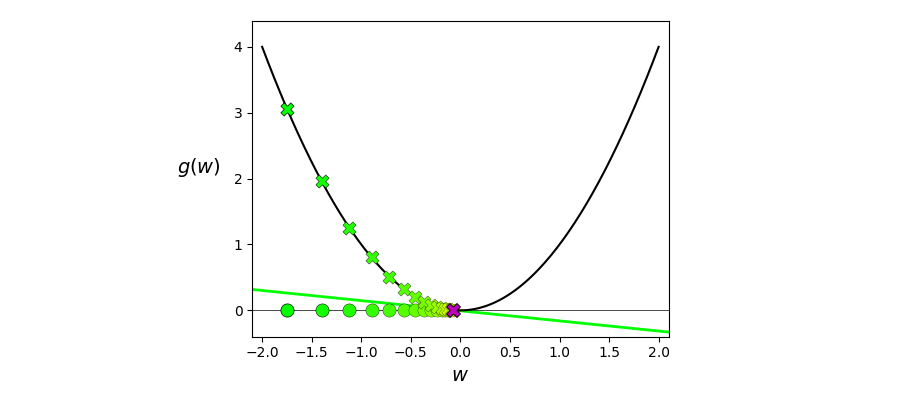
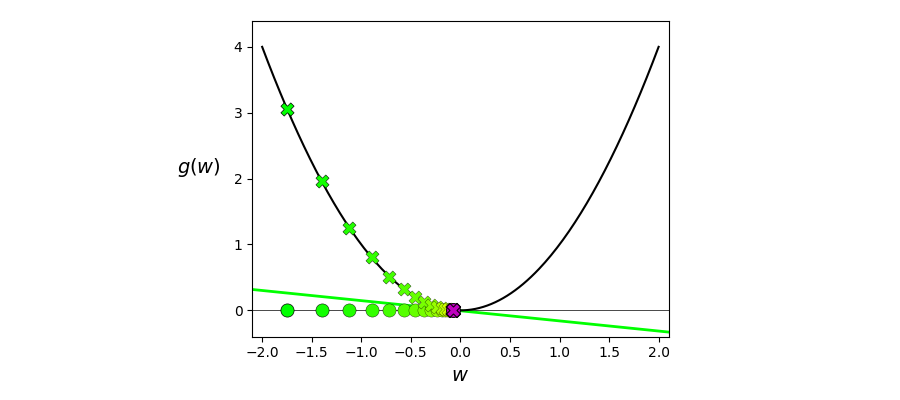
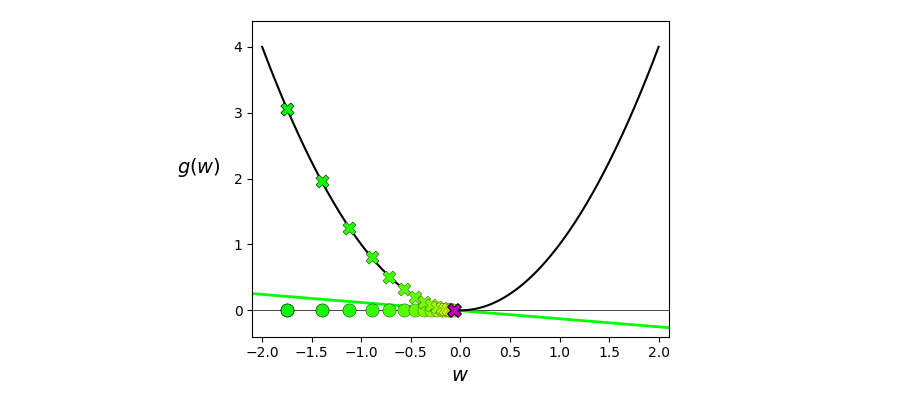
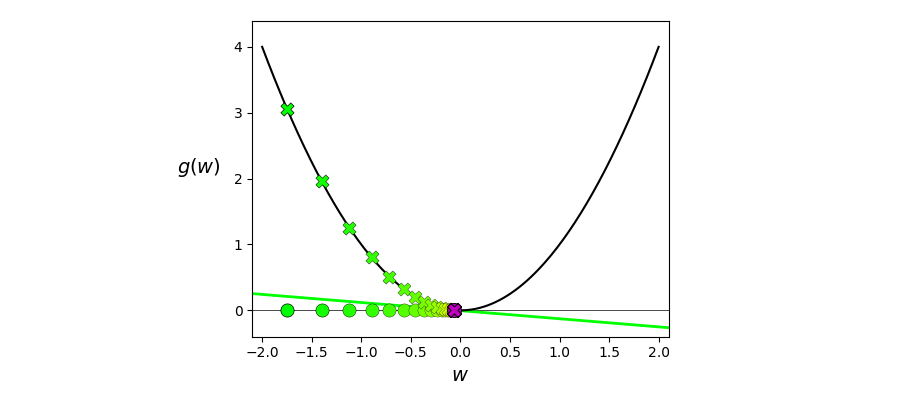
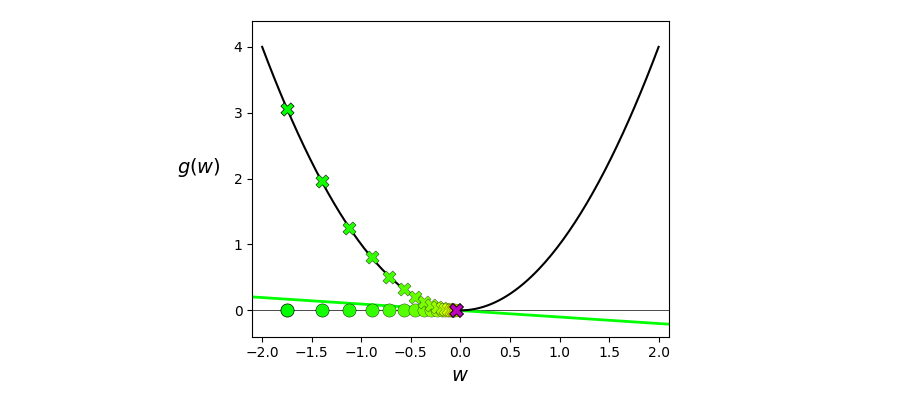
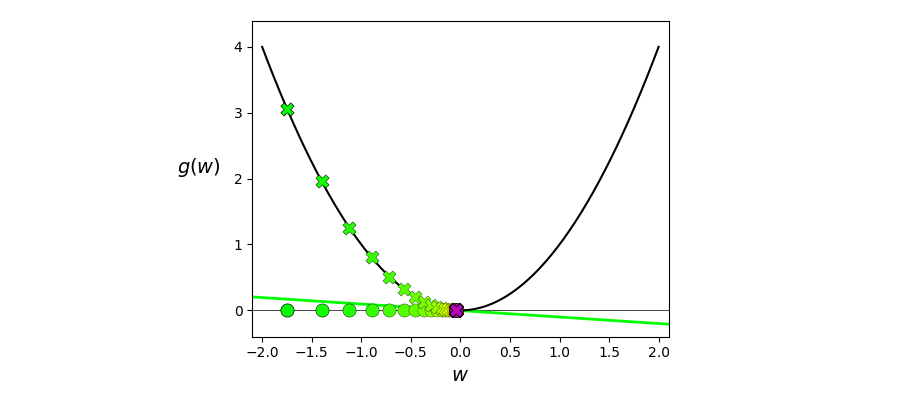
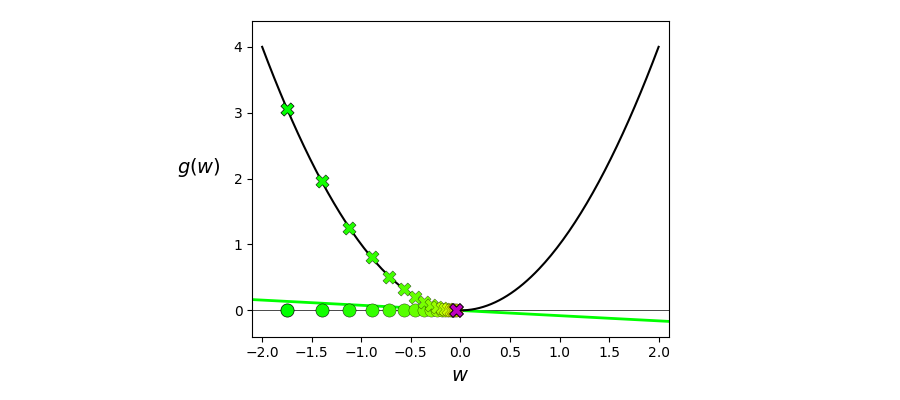
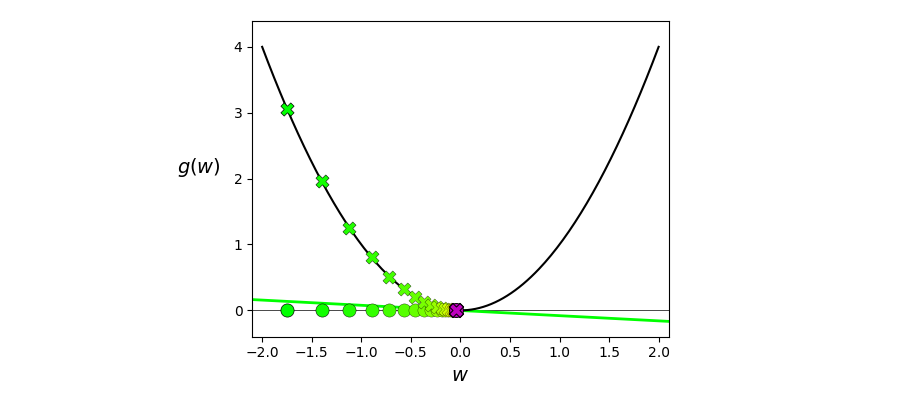
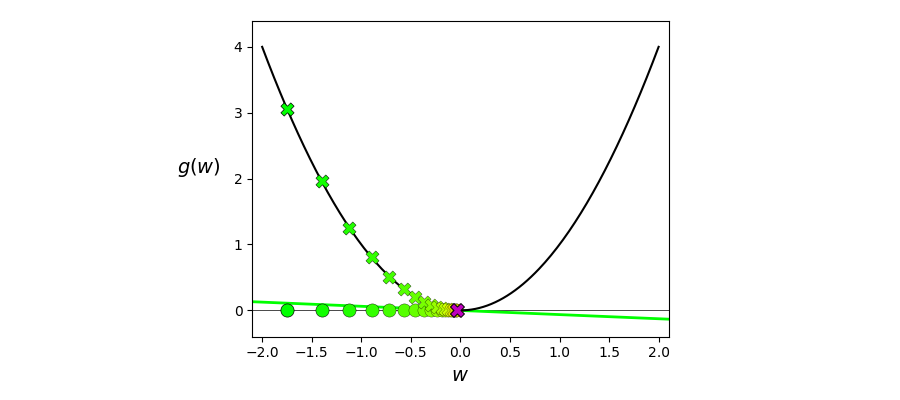
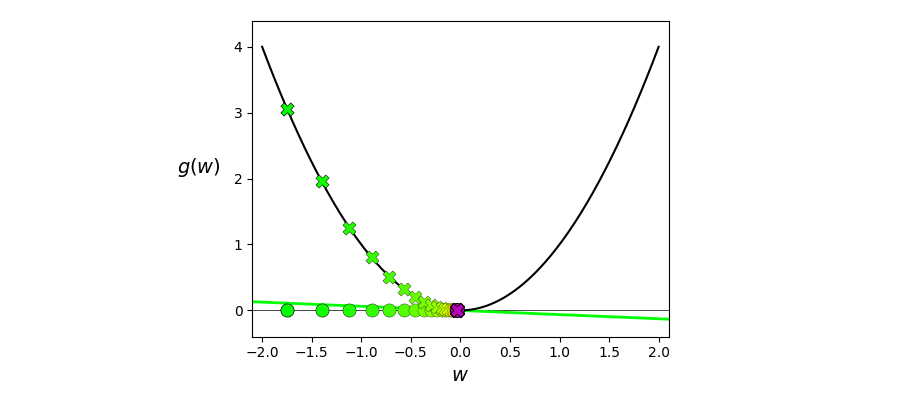
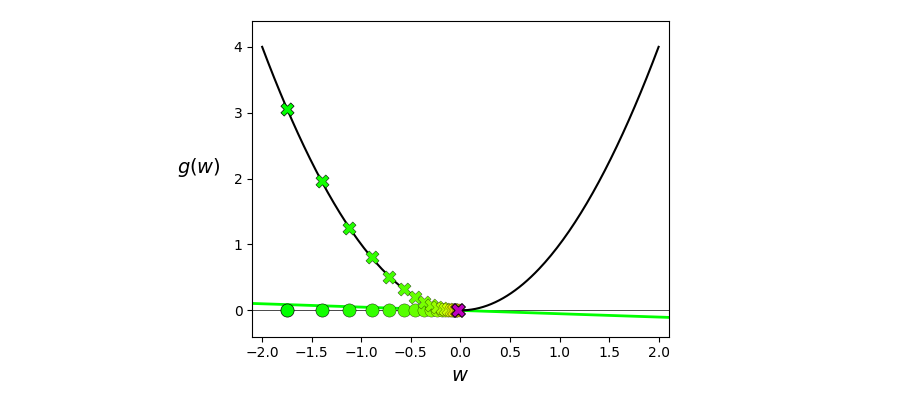
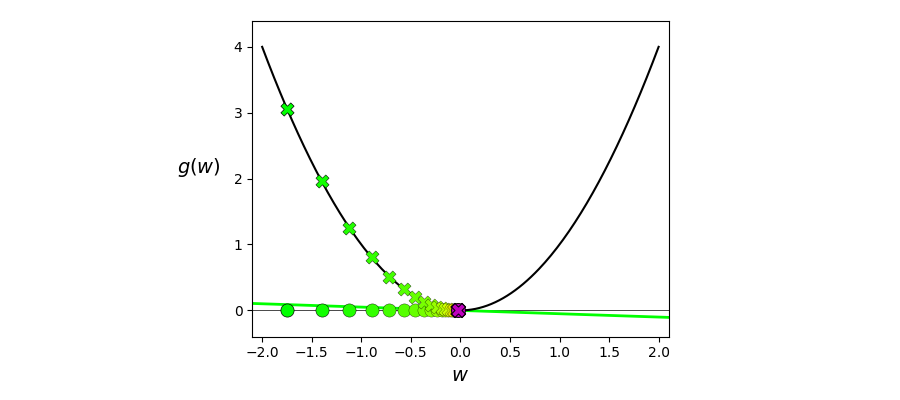
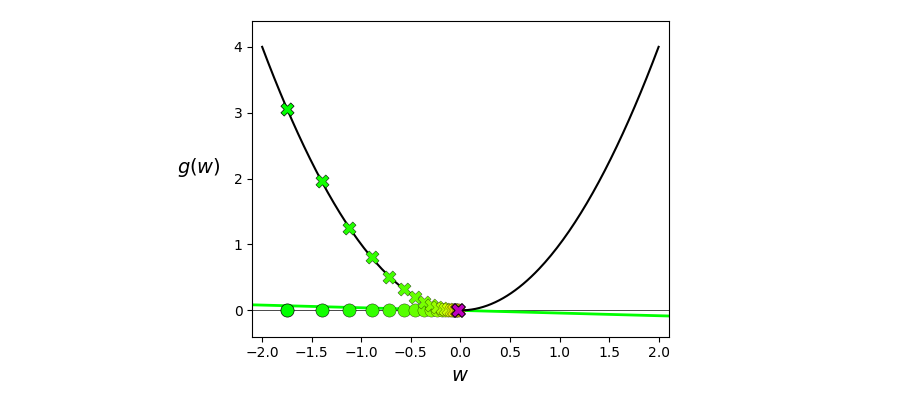
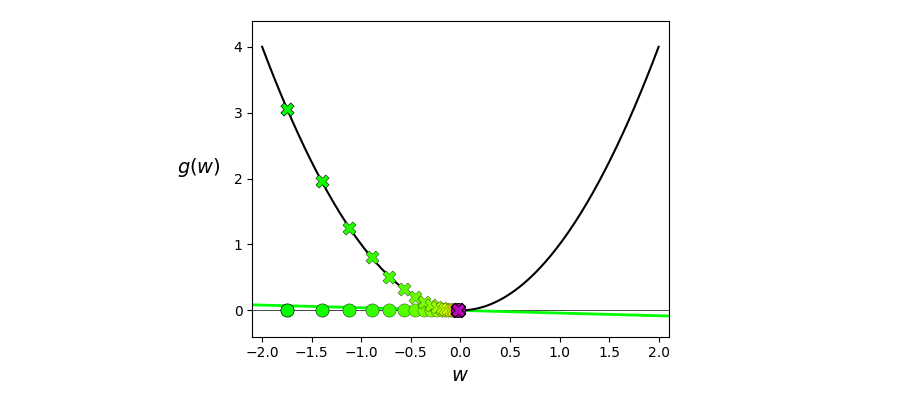
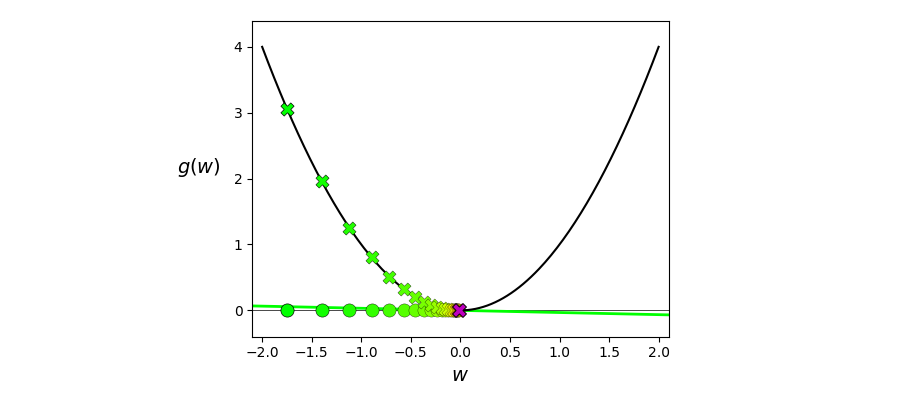
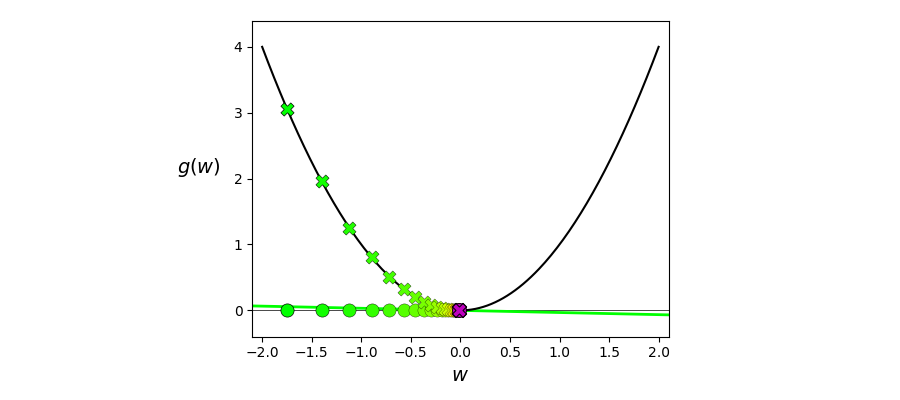
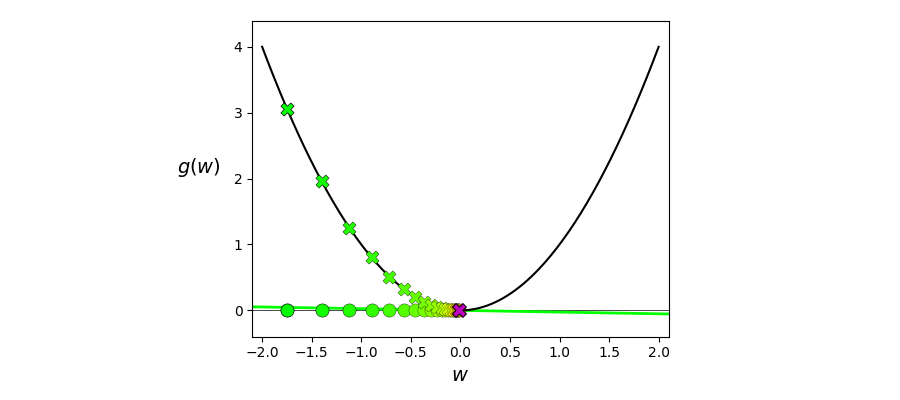
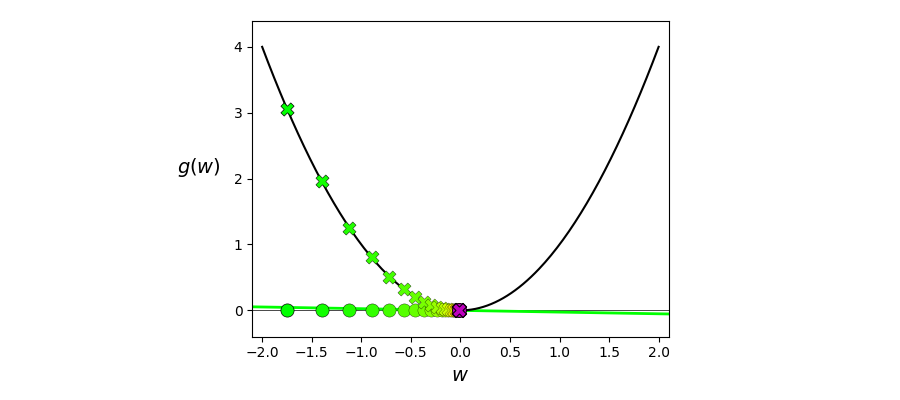
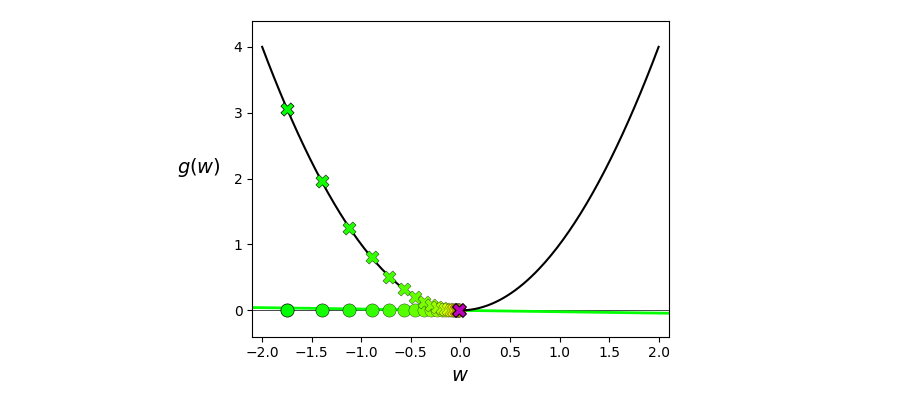
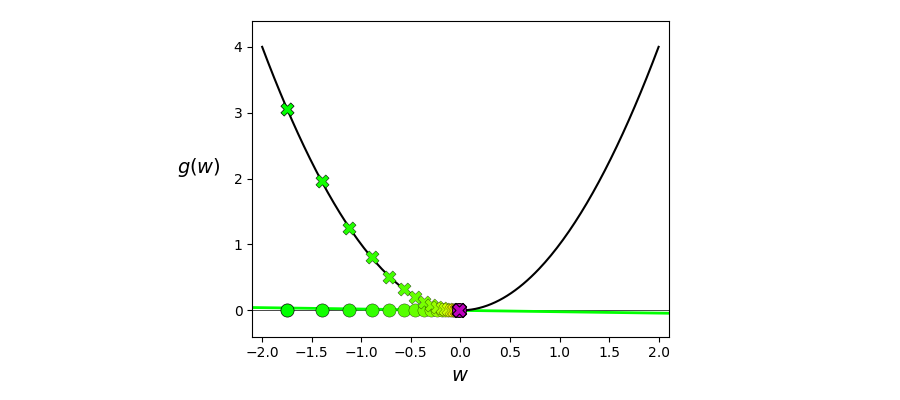
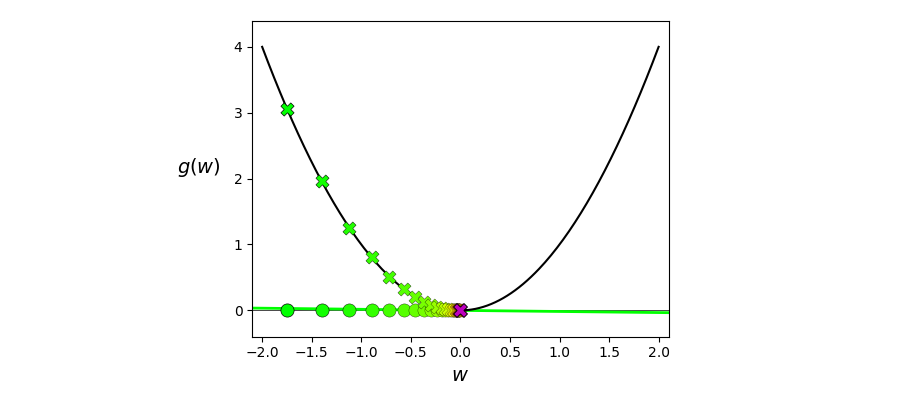
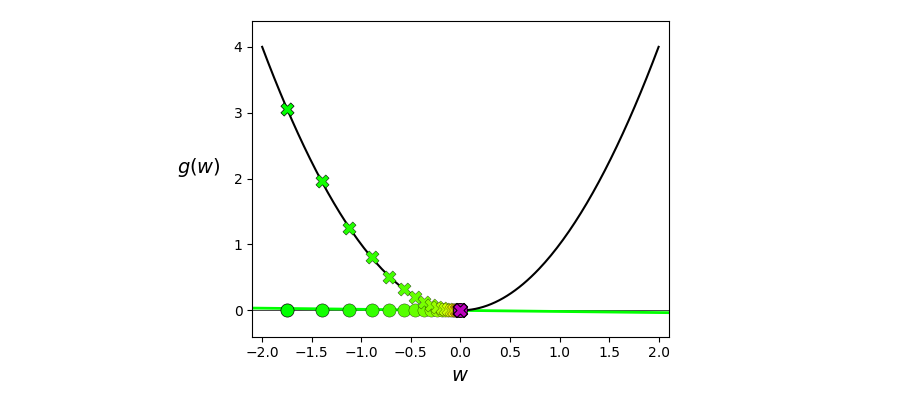
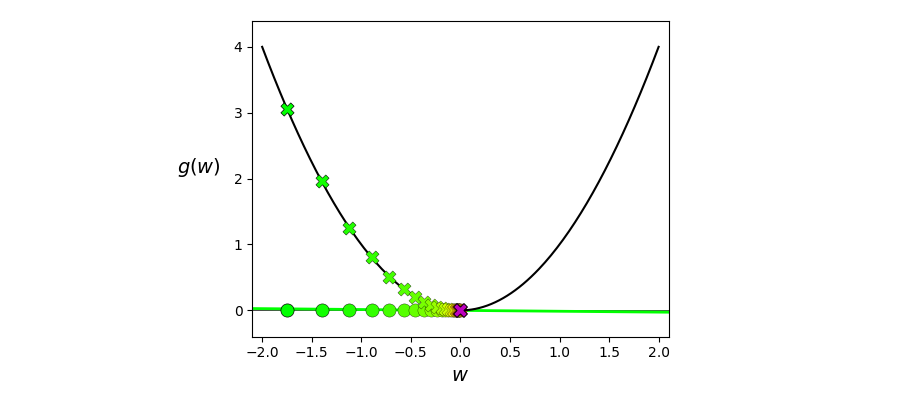
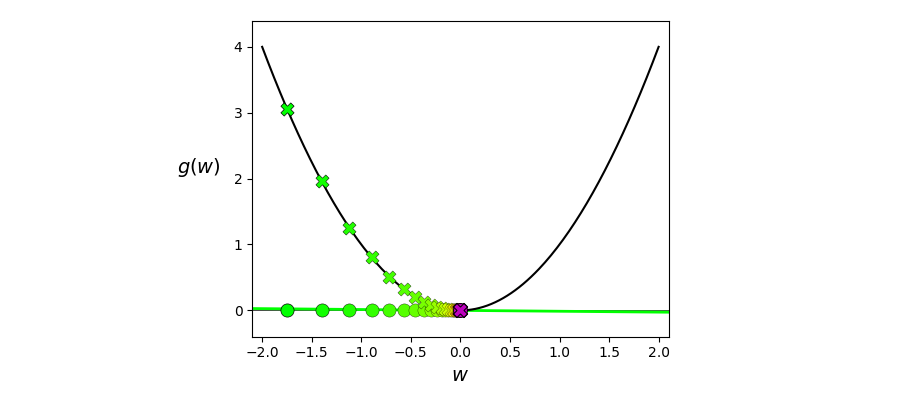
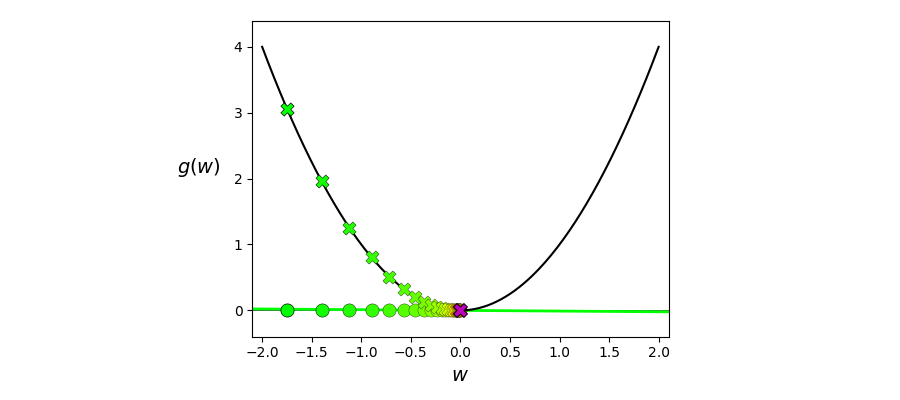
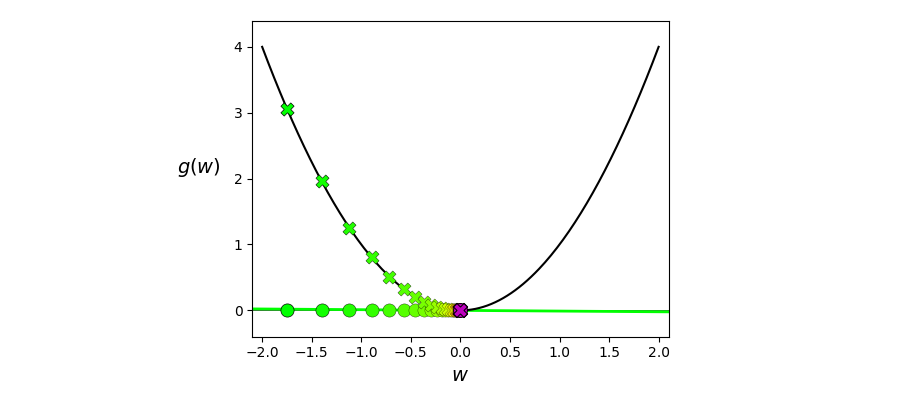
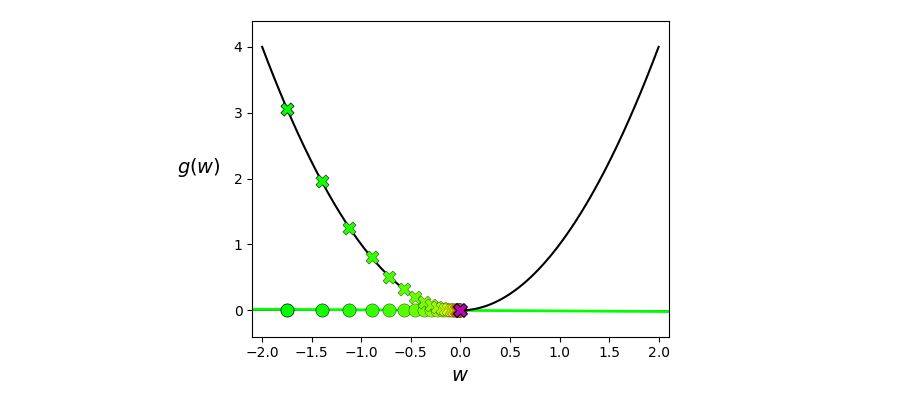
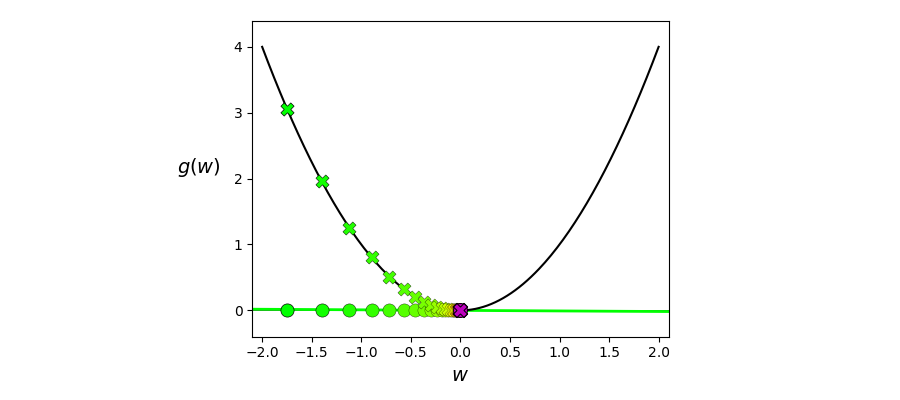
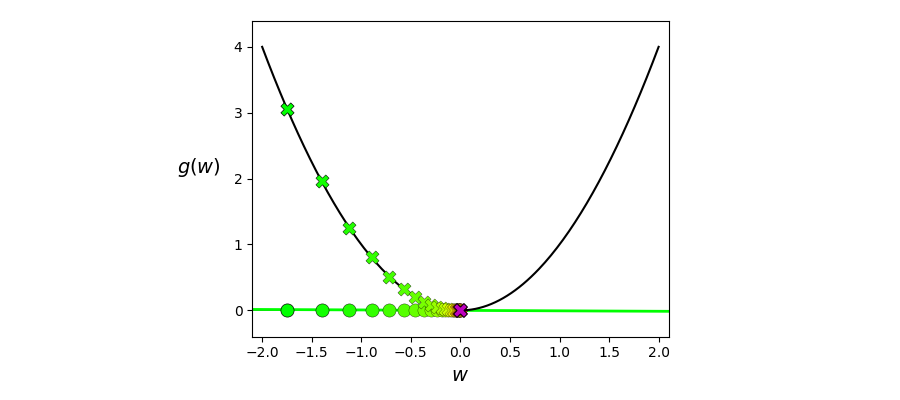
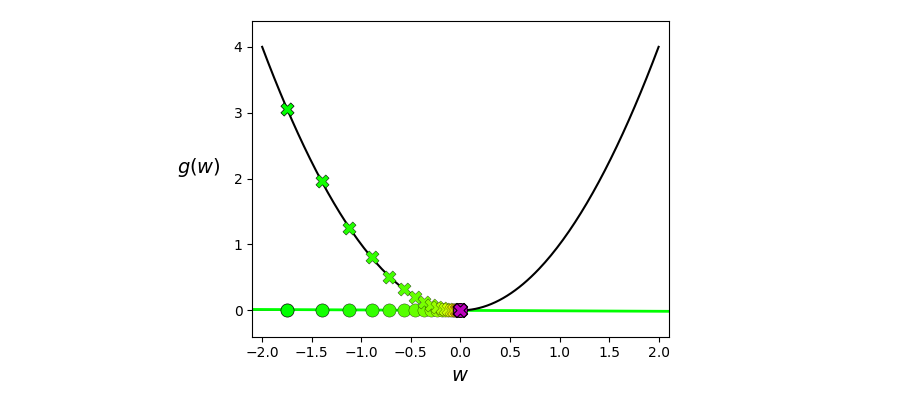
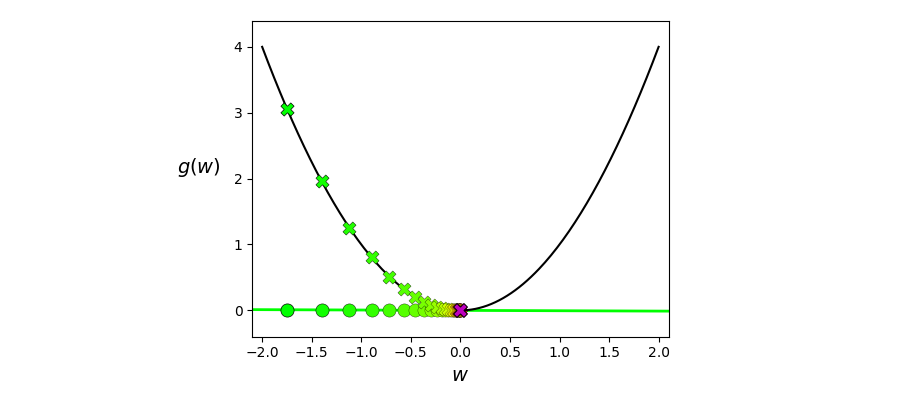
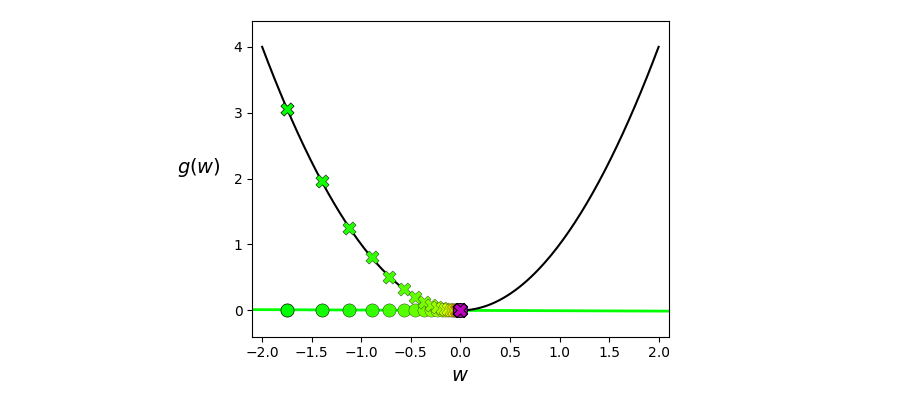
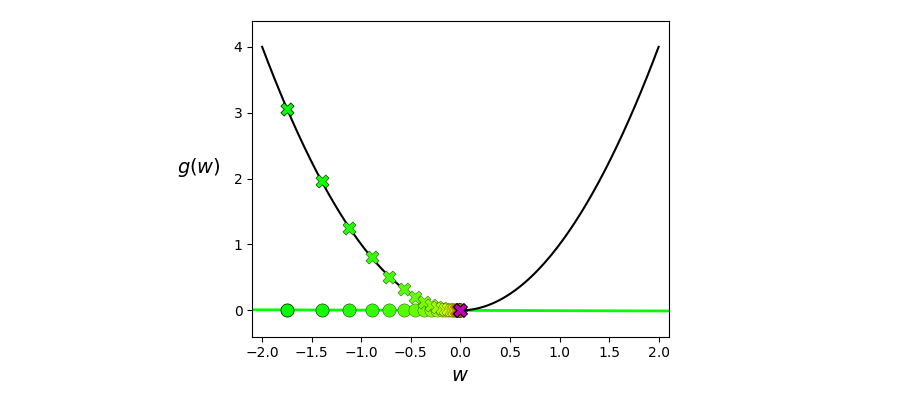
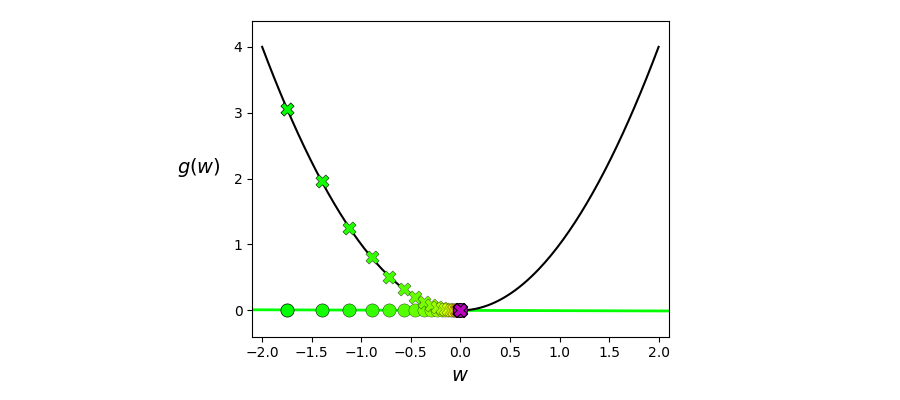
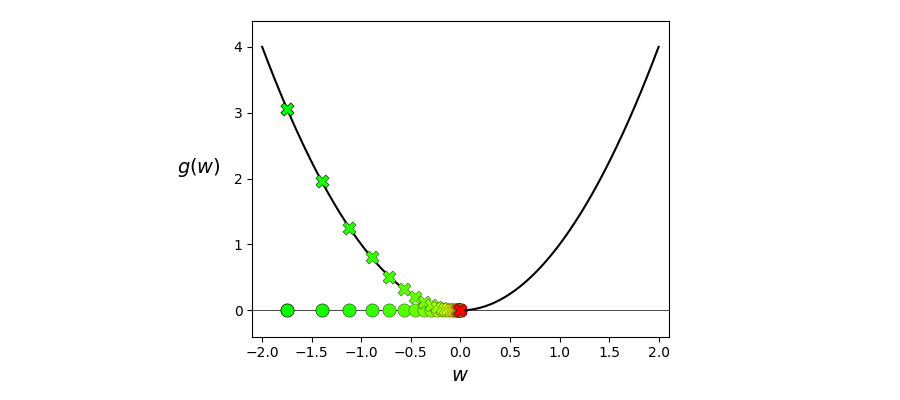

In [2]:
# what function should we play with?  Defined in the next line.
g = lambda w: w**2  

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();

demo.animate_2d(g=g, w_init = -1.75,steplength = 0.1,max_its = 30,version = 'unnnormalized',wmin = -2,wmax = 2)

Place the slider one unit left of its full right position, so that the final point is colored purple and the linear approximation is shown in lime green.  Now, lets discuss the convergence behavior of this run by examining the results above and the general form of the $k^{th}$ step in the unnormalized method

$$
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g(\mathbf{w}^{\,k-1})
$$

First off note how - by examining the horizontal axis of the plot above - we can see that while the steplength parameter $\alpha$ here was fixed the length of each step clearly decreased at each step.  This is of course due to the fact that the length of each step - given by $\alpha\left\Vert \nabla g\left(\mathbf{w}^{\,k-1}\right) \right\Vert_2$ as derived earlier - is inherently tied to the length of the gradient.  Here (and in general) as the length of the gradient gets smaller, the steps get shorter (and vice-versa).  Hence the method 'slow down' - taking smaller and smaller steps - near stationary points of a function.  Stated more formally, if the steps are extremely close, i.e., that  $\mathbf{w}^{\,k} \approx \mathbf{w}^{\,k-1}$ then from the unnormalized update step it must be the case that $\nabla g(\mathbf{w}^{\,k-1}) \approx \mathbf{0}_{N\times 1}$ or likewise that $\left\Vert \nabla g\left(\mathbf{w}^{\,k-1}\right)\right\Vert_2$ is small (with our example above we can indeed see that the derivative, or slope of the tangent line, is very close to zero).  This says that unnormalized gradient descent naturally halts near **any** stationary point of a function (including saddle points). (See our *Vital elements of calclus series* for more info on stationary points if this concept is unfamiliar.)  This feature makes the unnormalized gradient descent step a natural choice for minimizing convex functions - whose only stationary points are global minima.

In the next Python cell we compare normalized and unnormalized gradient descent (left and right panels respectively) on the simple quadratic function used previously.  Both algorithms use the same initial point ($w^0 = -3$), steplength parameter ($\alpha = 0.1$), and maximum number of iterations (20 each).  Steps are colored from green to red to indicate the starting and ending points of each run, with circles denoting the actual steps in the input space and 'x''s denoting their respective function evaluations.  Notice how - due to the re-scaling of each step via the derivative length - the unnormalized version races to the global minimum of the function. Meanwhile the normalized version - taking constant length steps - gets only a fraction of the way there.  This behavior is indicative of how each behaves in general when applied to minimizing convex functions. 

<IPython.core.display.Javascript object>


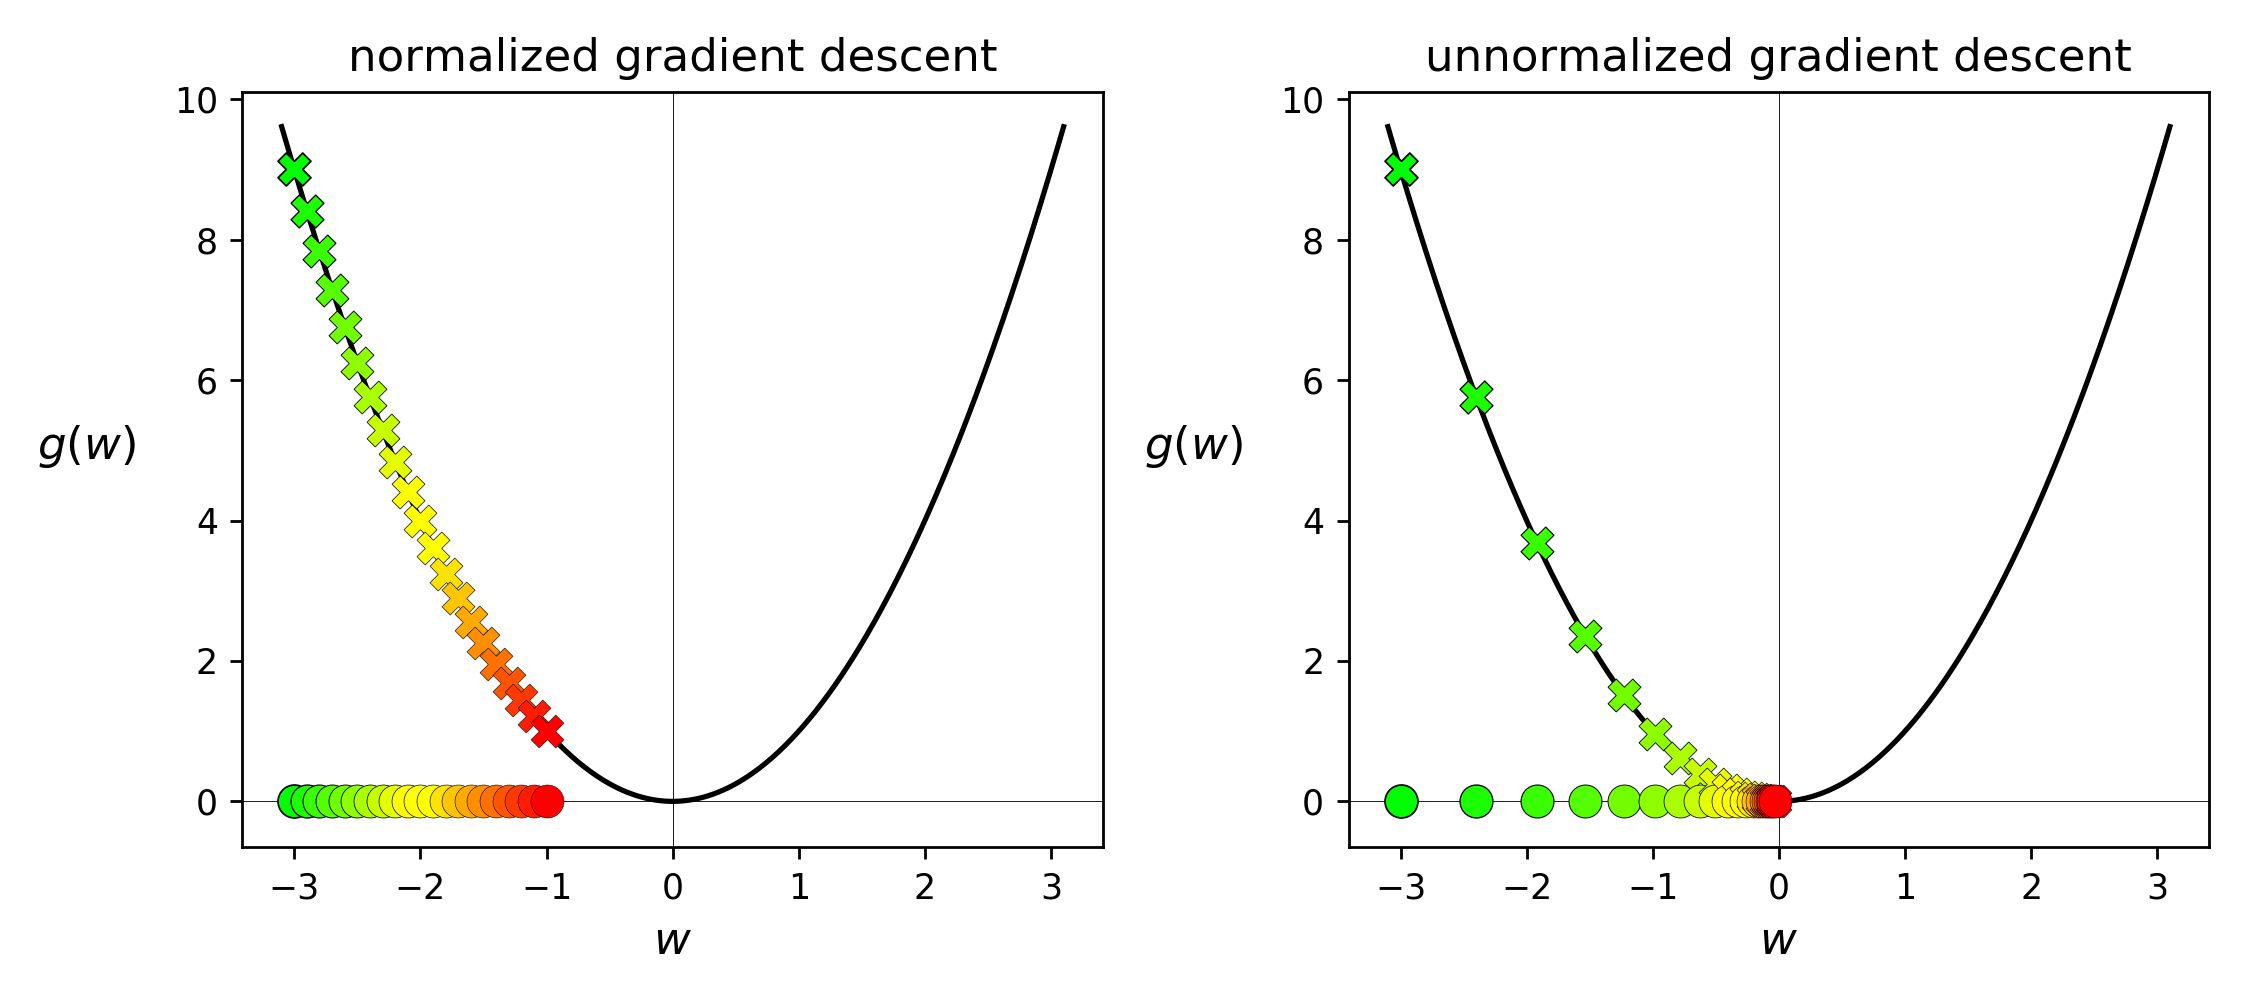

In [3]:
# what function should we play with?  Defined in the next line.
g = lambda w: w**2

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();
demo.compare_versions_2d(g=g, w_init = -3,steplength = 0.1,max_its = 20)

Another example, consider the same quadratic with $N = 2$ inputs which we illustrate - along with a run of each version of the algorithm - in the next Python cell.   As can be seen in the plot, when using a constant steplength parameter $\alpha = 0.7$ the length of each step with the unnormalized algorithm naturally *diminishes* as it approaches the stationary point (the global minimum) due to the shrinking gradient, and this helps it 'zero in' on the minimum and get infinitesimally close to it.  Conversely with the normalized gradient descent algorithm - which takes steps of the length $\alpha$ ad infinitem - we can only get so close to the global minimum.  We cannot 'zero in' on the solution at the origin as well as the unnormalized version can.

This is indicative of a more general behavior of the normalized gradient descent algorithm with functions such as this - if we want a point infinitesimally close to a global minimum we must *use a diminishing steplength*.  This gives the normalized algorithm a chance to 'zero in' on minima.  Thus for a general function we see that gradient descent 'zeros in' local minima only when the length of each step (eventually) diminishes as the algorithm progresses.  In the case of normalized gradient descent this implies that the steplength parameter $\alpha$ should be diminishing in size if such a solution is needed.

### Another example

<IPython.core.display.Javascript object>


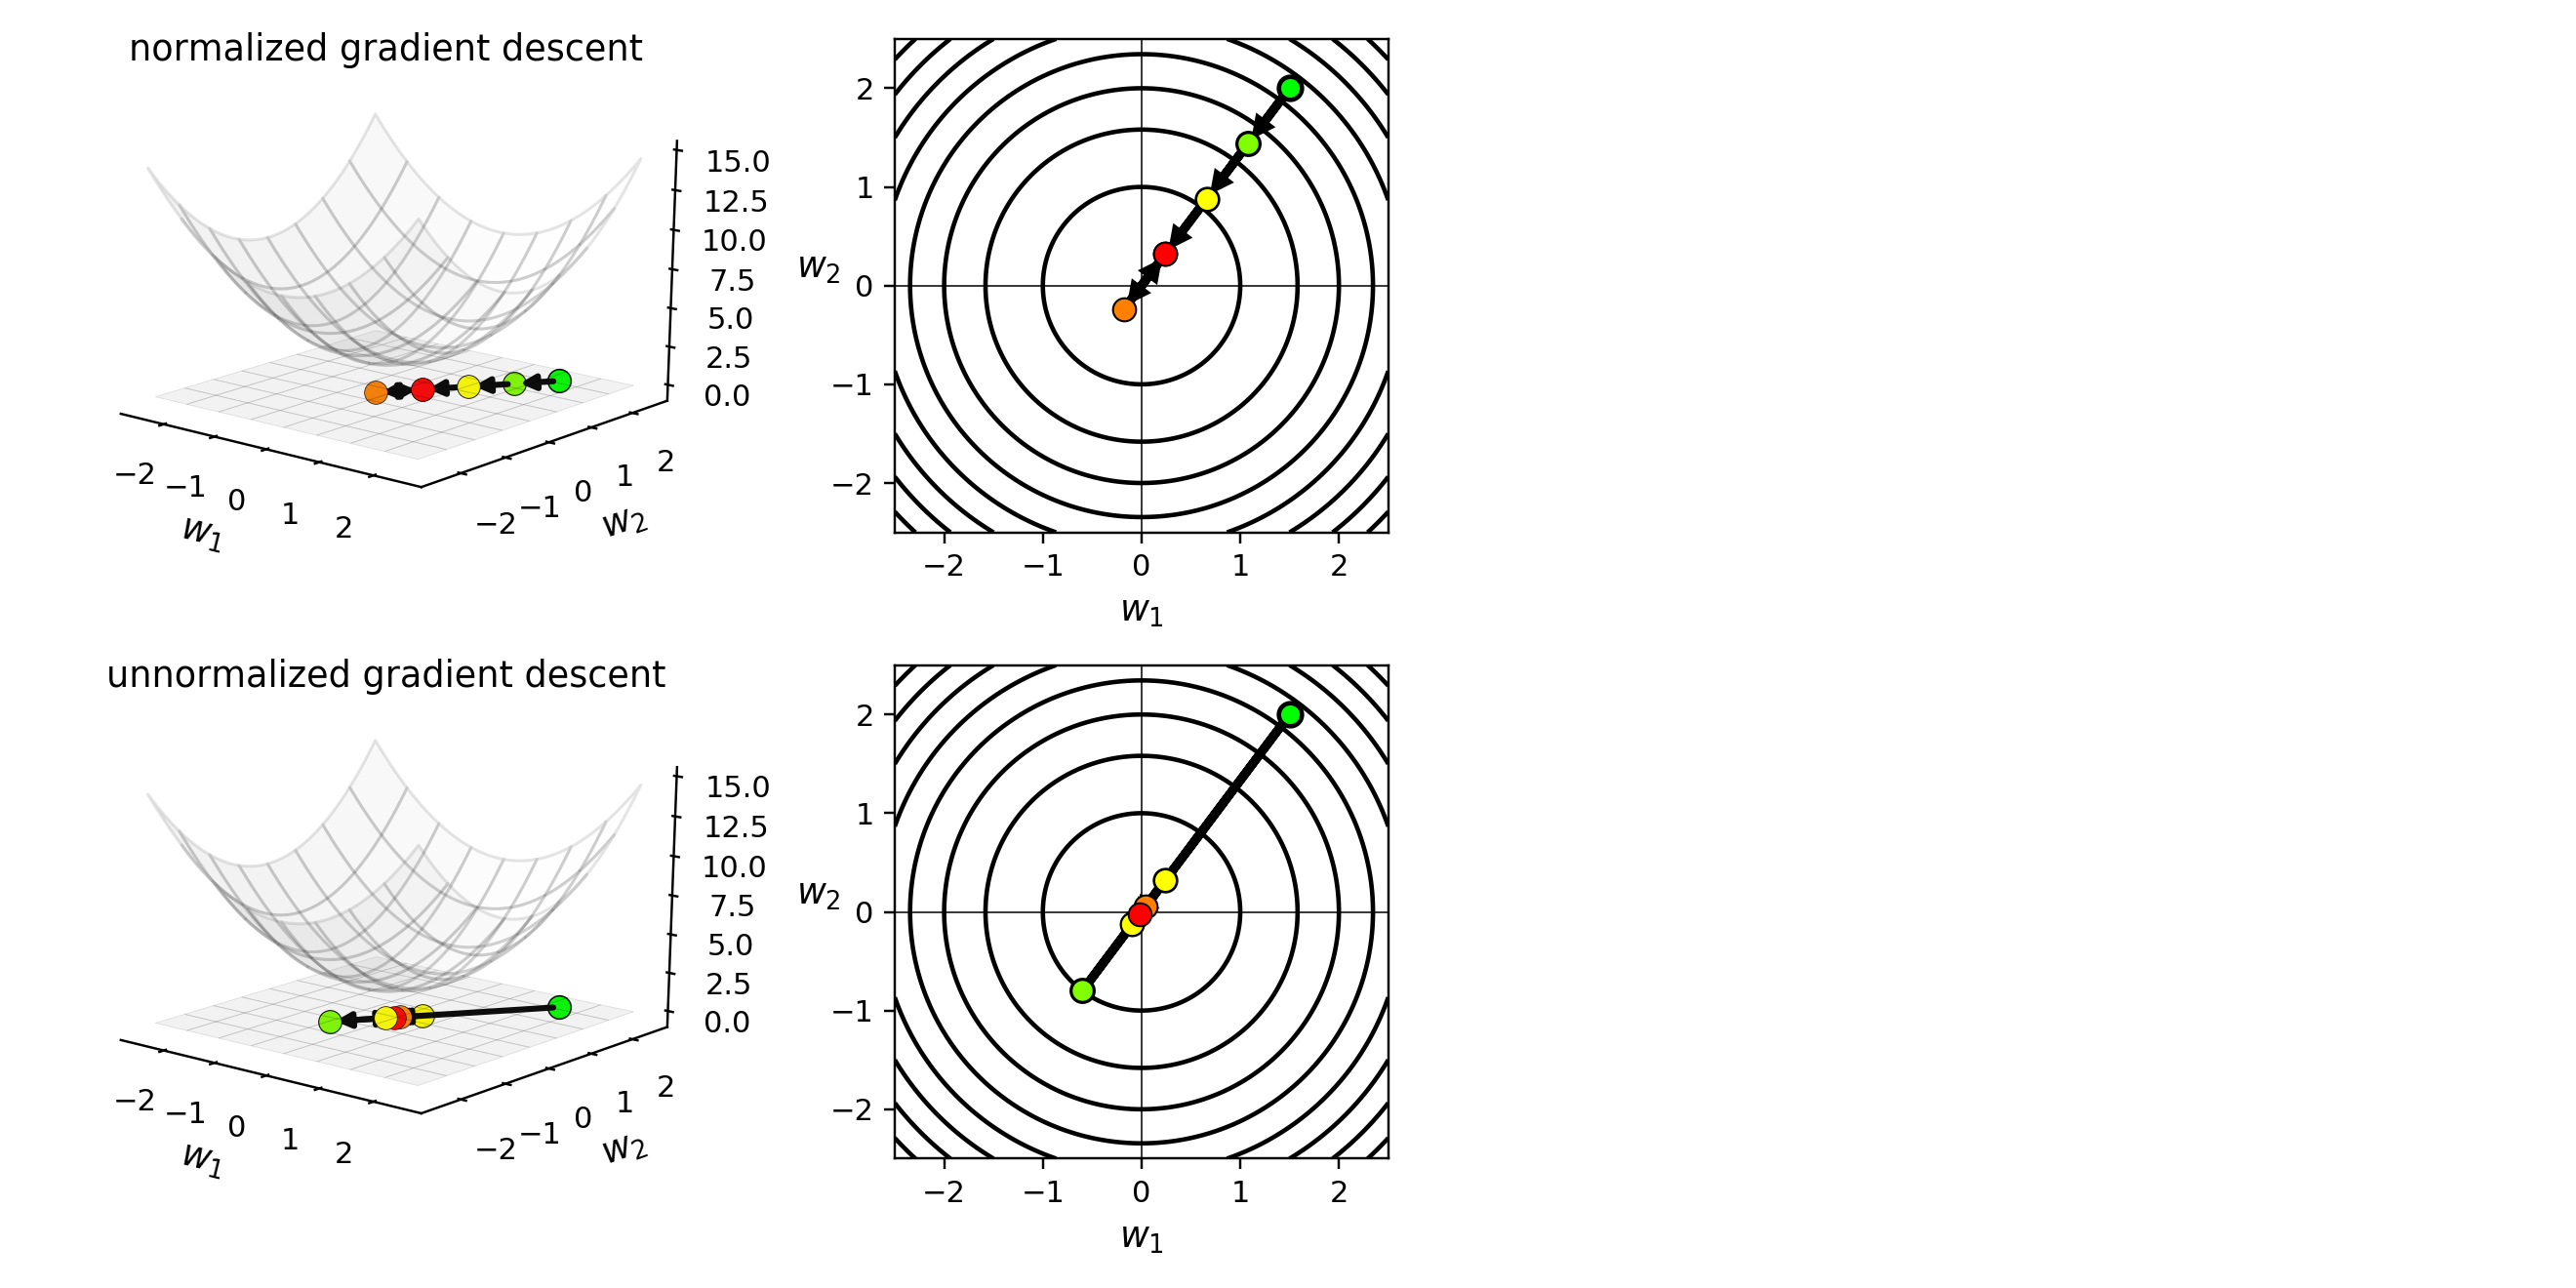

In [4]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.dot(w.T,w) + 2

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();
w_init = [1.5,2]; max_its = 5; steplength = 0.7;

demo.compare_versions_3d(g,w_init,steplength,max_its,wmax=max(w_init[0],w_init[1]))

### Normalized vs. unnormalized gradient descent

** Stepsize parameter selection:**   For a general function gradient descent reaches points infinitesimally close to local minima only when the length of each step diminishes as the algorithm progresses (at least eventually).  In the case of normalized gradient descent this implies that the steplength parameter $\alpha$ should be diminishing in size if such a solution is needed.  This must be done as well with unnormalized gradient descent when applied to certain convex functions (that are not completely smooth, e.g., the absolute value function) as well.  However for smooth convex functions with unnormalized gradient descent since the length of each step is dependent on the length of the gradient such behavior is possible even with a steplength parameter $\alpha$ fixed for all iterations.

Note that it is not always the case with a convex function that the magnitude of the gradient diminishes as we approach global minima.  Take the absolute value function for example

\begin{equation}
g(w) = |w|
\end{equation}

This has a single global minimum at $w = 0$, but its derivative is always defined (everywhere but at $w = 0$) as

\begin{equation}
\frac{\mathrm{d}}{\mathrm{d}w}g(w) = \begin{cases}
+1 \,\,\,\,\,\text{if} \,\, w > 0 \\
-1 \,\,\,\,\,\text{if} \,\, w < 0.
\end{cases}
\end{equation}

Since the length of each step with unnormalized gradient descent is dependent on the magnitude of this derivative, the fact that its length here does not change means that we are essentially taking normalized steps.

### Unnormalized gradient descent (fixed steplength)

<IPython.core.display.Javascript object>


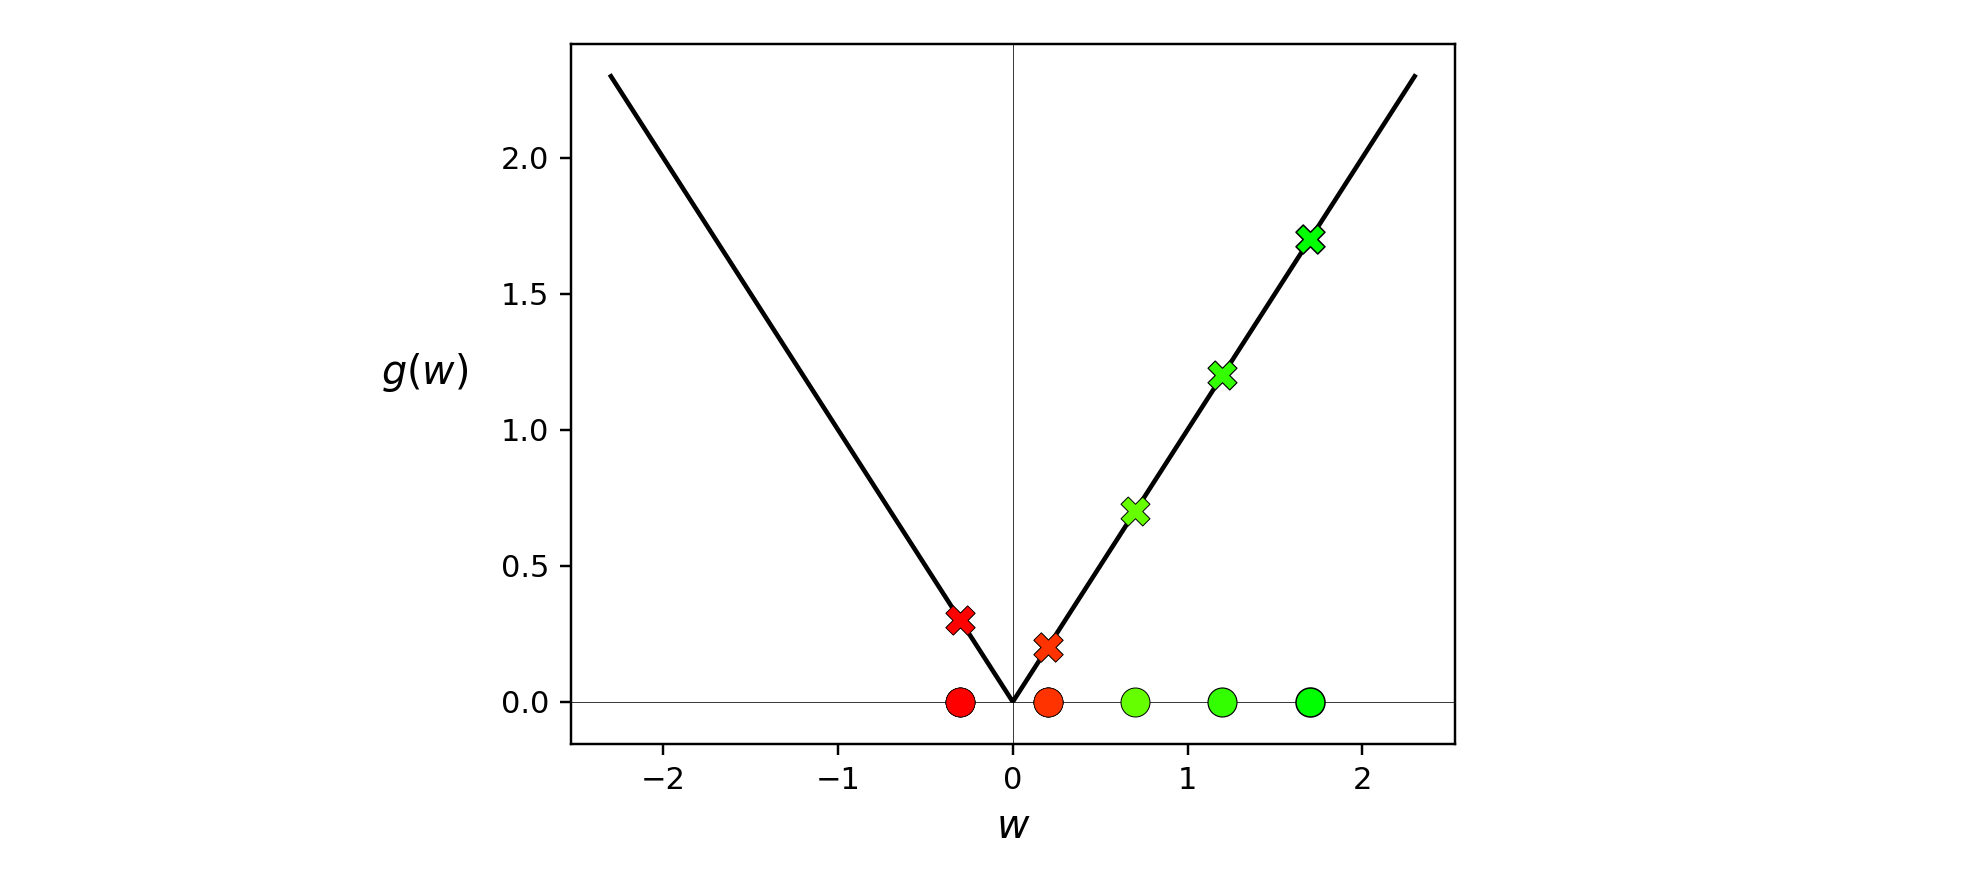

In [25]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.abs(w)

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();

demo.draw_2d(g=g, w_inits = [1.7] ,steplength = 0.5,max_its = 10,version = 'unnormalized',wmin =-2.3,wmax = 2.3)

### Unnormalized gradient descent (diminishing steplength)

Here - as with normalized descent - because the length of each step is not diminishing as we approach the global minima naturally, we must force it too by using a diminishing steplength value $\alpha$ if we wish to reach a point infinitesimally close to the minimum.  We-rerun the example above using a diminishing steplength value $\alpha$ in the Python cell below, and indeed we get much closer to the global minimum.

<IPython.core.display.Javascript object>


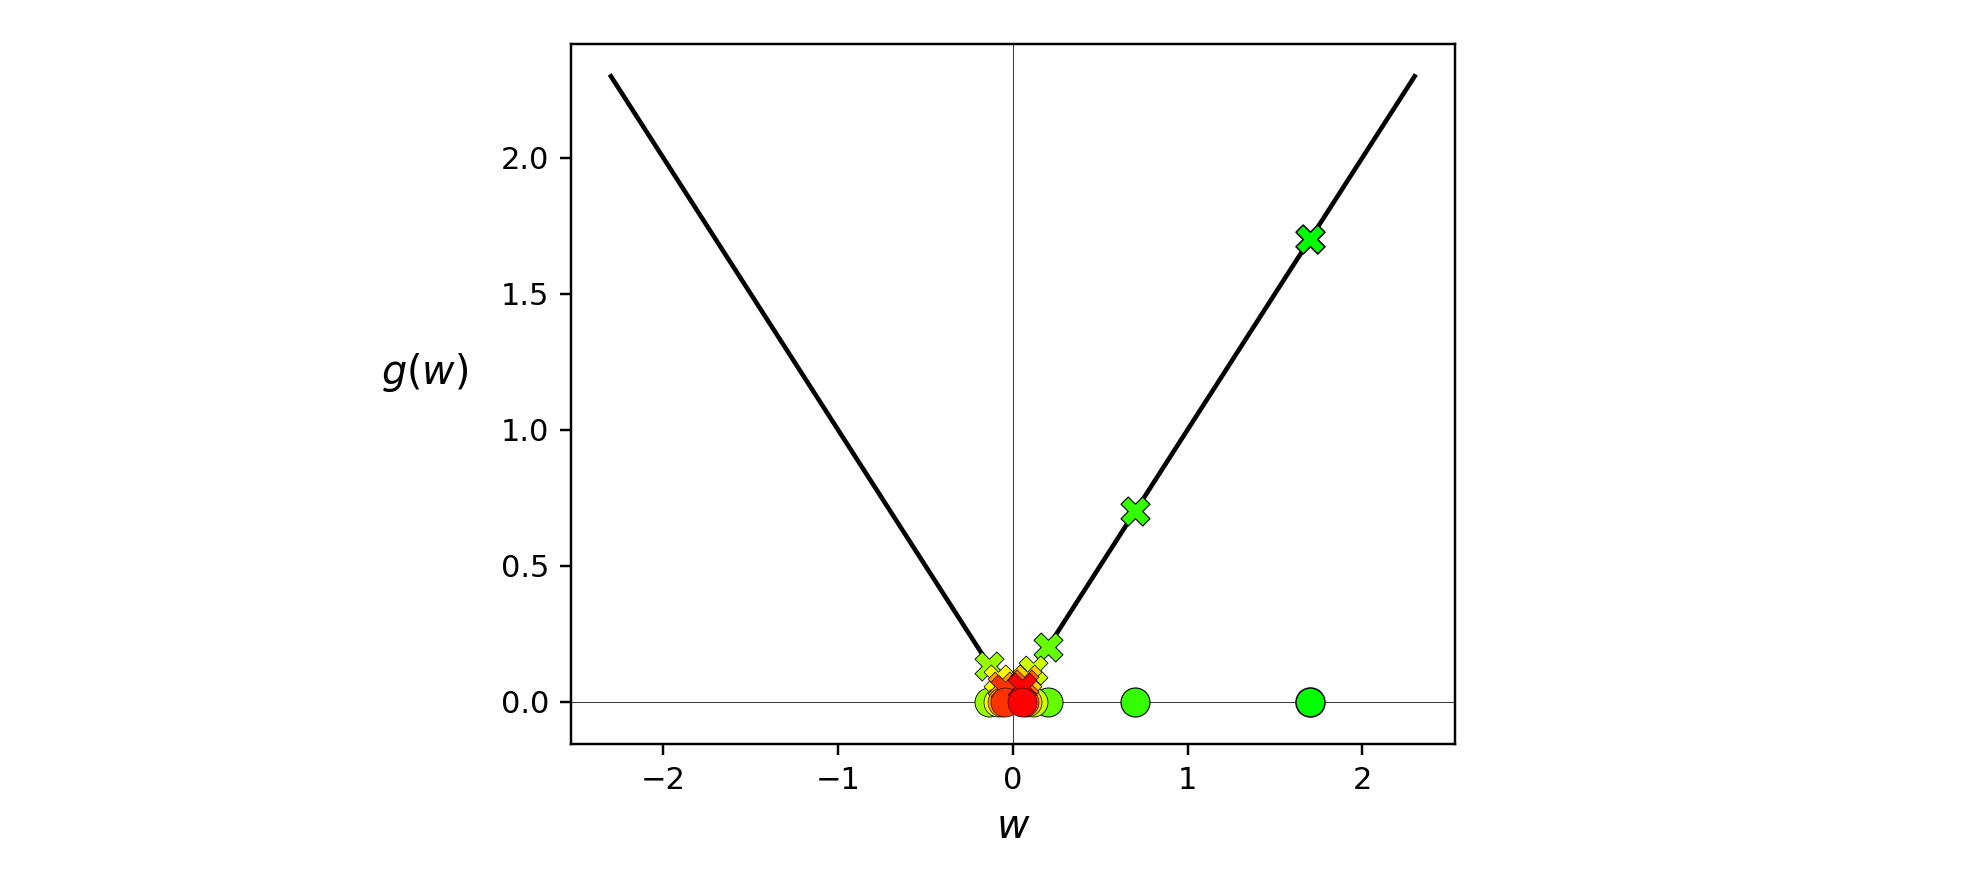

In [26]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.abs(w)

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();

demo.draw_2d(g=g, w_inits = [1.7] ,steplength = 'diminishing',max_its = 10,version = 'unnormalized',wmin =-2.3,wmax = 2.3)

A close cousin to the absolute value is the sum of relu functions.  For example

\begin{equation}
g(w) = \text{max}(0,w - 0.5) + \text{max}(0,-w - 0.5)
\end{equation}

This is like an absolute value function with a long flat region of global minima at the bottom.  Here we can use a diminishing steplength, or pick the steplength value small enough so that we reach the flat region of global minima (and here we will stay since it is perfectly flat).  We run the same setup of gradient descent using the sum of relu functions above to illustrate using a fixed steplength value $\alpha = 0.5$.  Since there is a large region of global minima we can indeed reach a global minimum using this fixed steplength provided

<IPython.core.display.Javascript object>


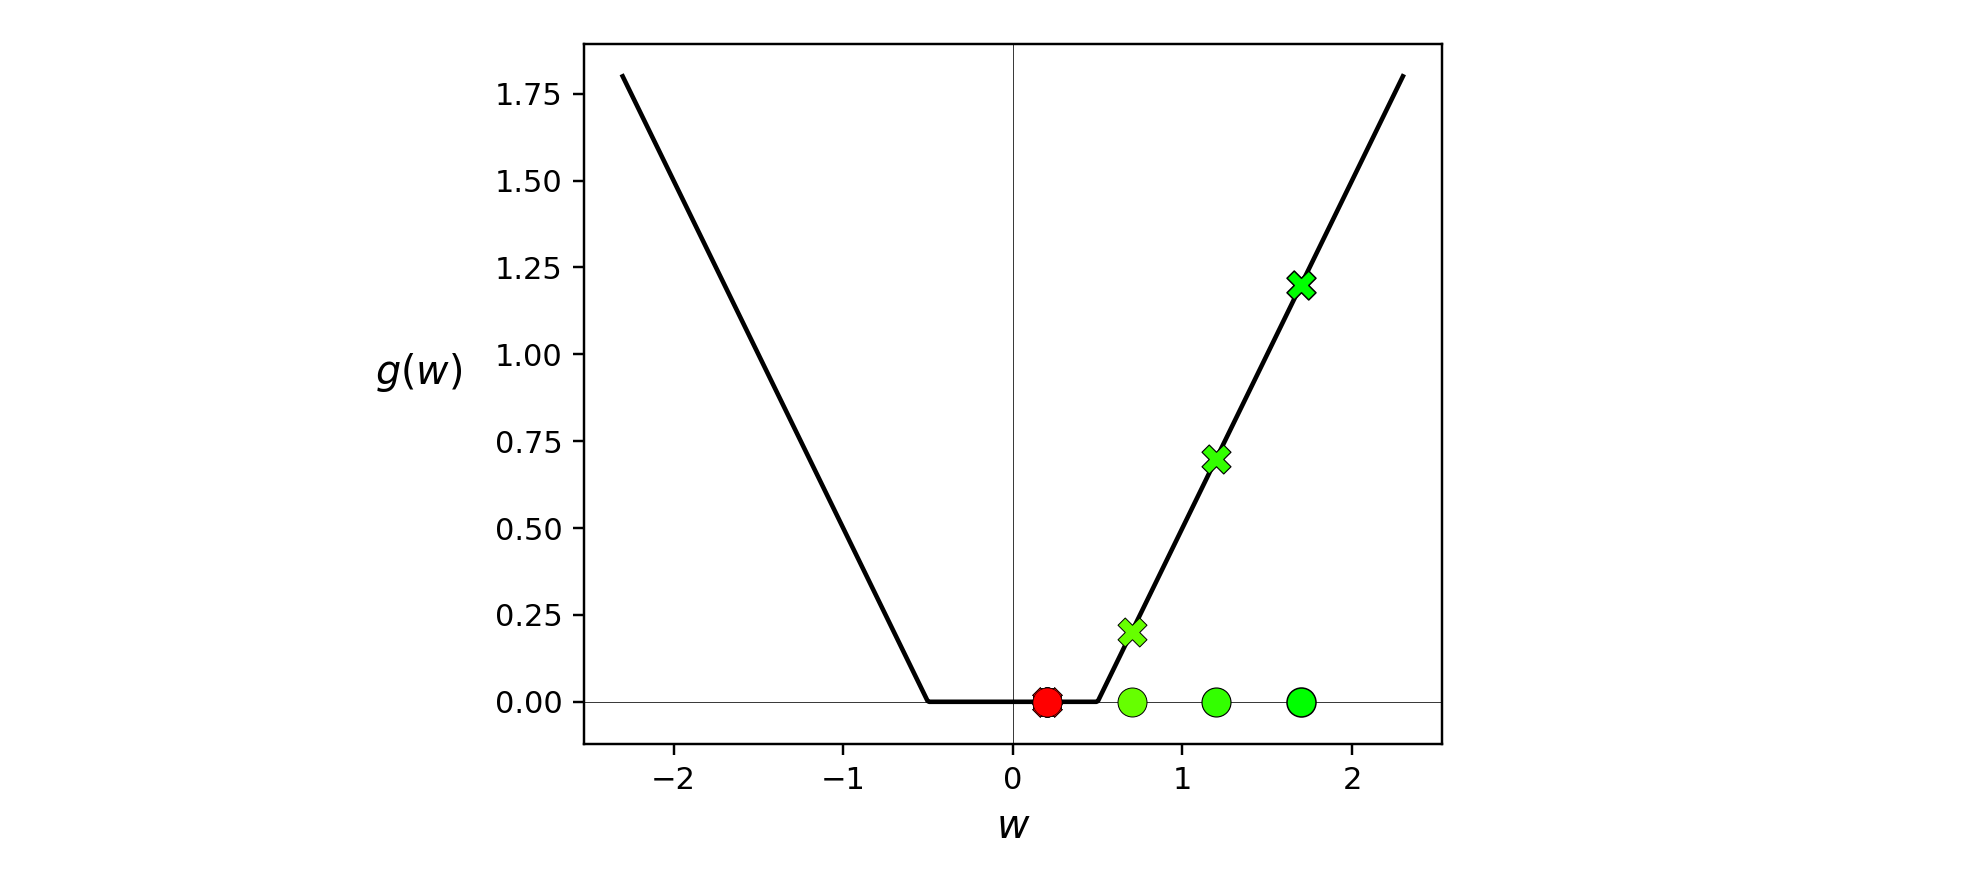

In [31]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.maximum(0,w - 0.5) + np.maximum(0, - w - 0.5) 

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();

demo.draw_2d(g=g, w_inits = [1.7] ,steplength = 0.5,max_its = 10,version = 'unnormalized',wmin =-2.3,wmax = 2.3)

### Normalized vs. unnormalized gradient descent

** Behavior on generic non-convex functions:** Generally speaking the *normalized* is more convenient for use with non-convex functions (like e.g., *deep neural networks*), because here the fact that the length of each step of the unnormalized version is tied directly to the magnitude of the gradient is disadvantageous.  By completely controlling the length of each step via the steplength parameter, the normalized version can be made to more easily pass over saddle points and through flat regions of a function.

#### <span style="color:#a50e3e;">Example 8. </span>  (normalized) gradient descent and non-convex functions with saddle points and flat regions 

In this example we illustrate a very useful amenity of the normalized gradient scheme: the avoidance of saddle points that comes by controlling the exact length of each descent step via the steplength parameter.  The first function we use to illustrate this advantageous behavior is the following

$$
g(w) = \text{maximum}(0,(3w - 2.3)^3 + 1)^2 + \text{maximum}(0,(-3w + 0.7)^3 + 1)^2
$$

This function has a minimum at $w= \frac{1}{2}$ and saddle points at $w = \frac{7}{30}$ and $w = \frac{23}{30}$.  

To illustrate how normalized gradient descent can pass over the saddle point of this function we make a run starting at the point $w^0 = 0$, use a fixed steplength of $\alpha = 0.01$, and take $55$ steps.  We then produce an animation like the ones used above in the next Python cell, where one can use a slider mechanism to watch the run progress from its initialization (in green) to its final value (in red).  Notice how smoothly the run passes by the saddle point.  If we keep track of the weight associated with smallest function value here, we will get something very close to the global minimum.

Normalized gradient descent in action: fixed steplength, $55$ iterations.


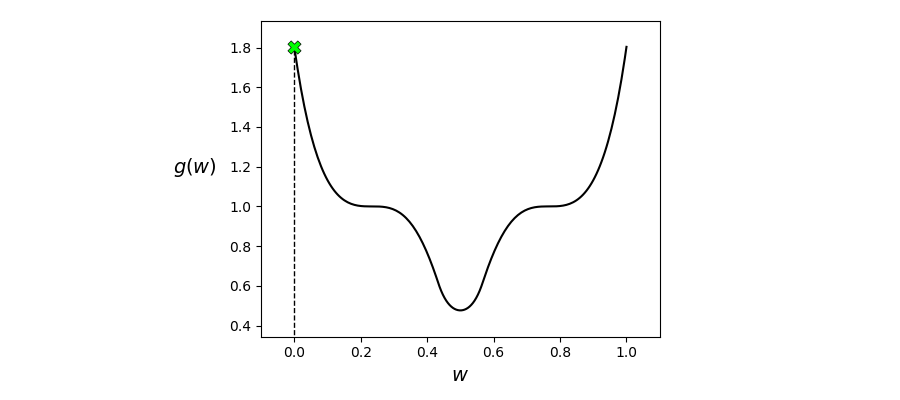
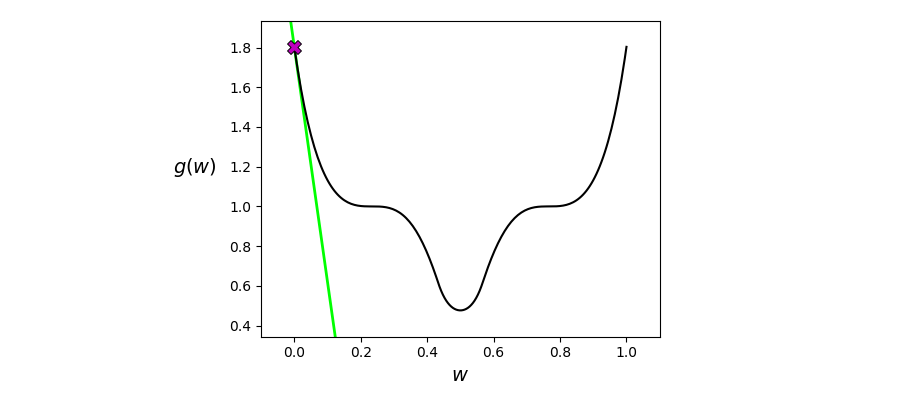
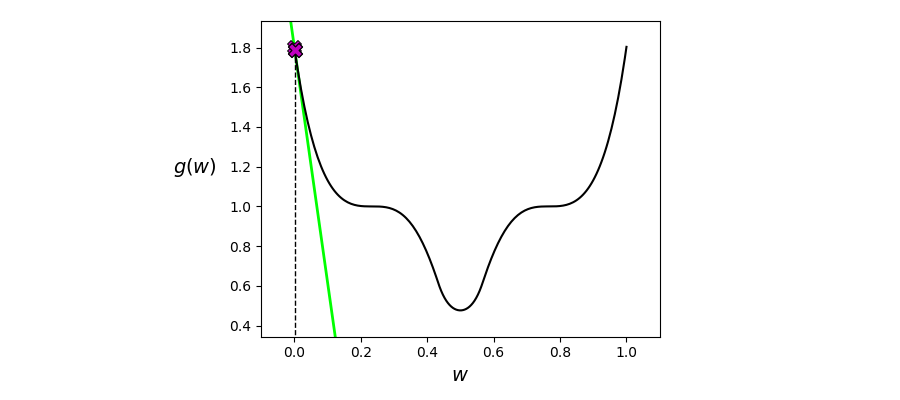
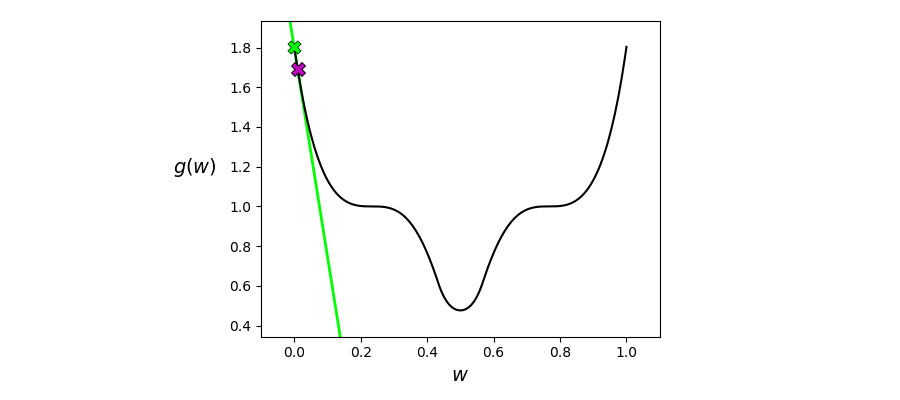
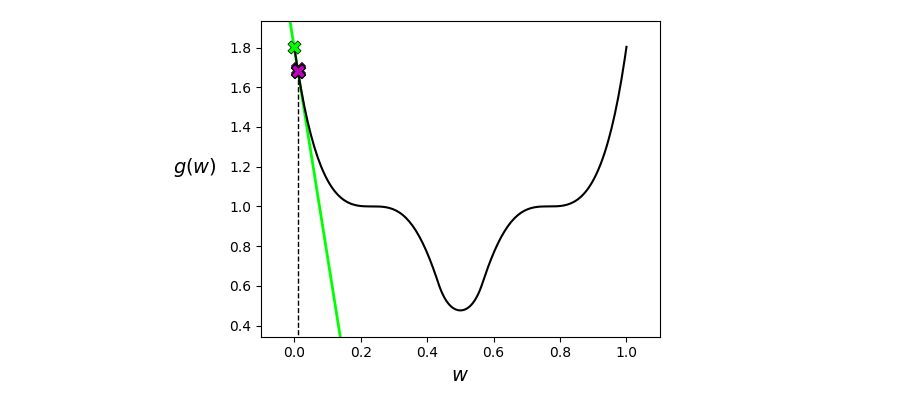
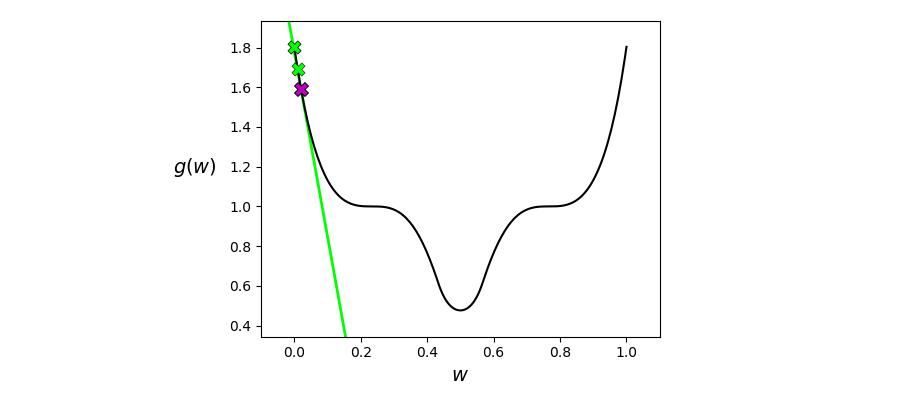
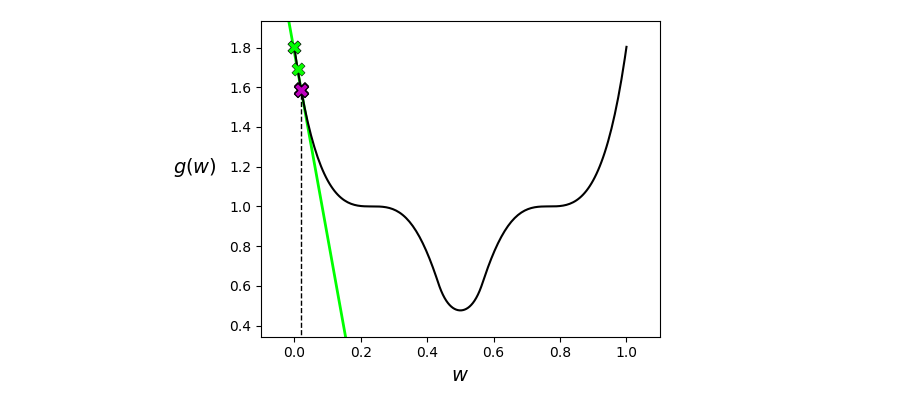
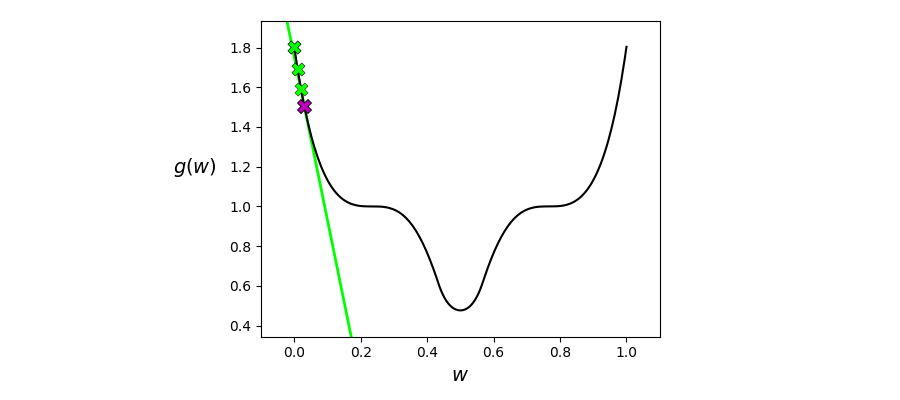
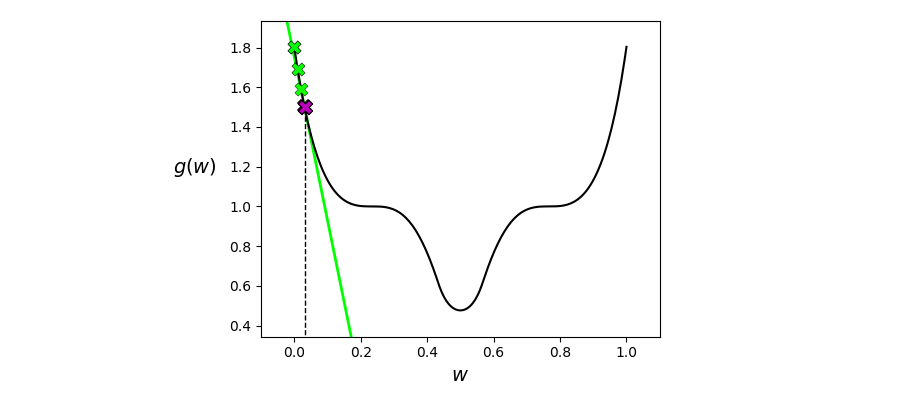
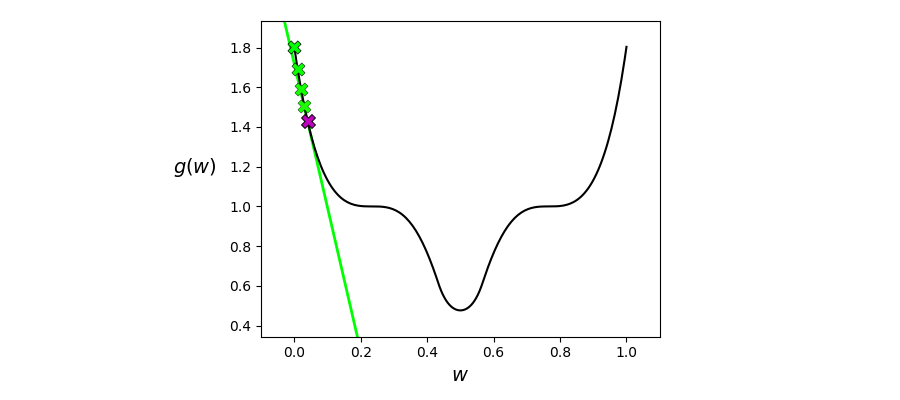
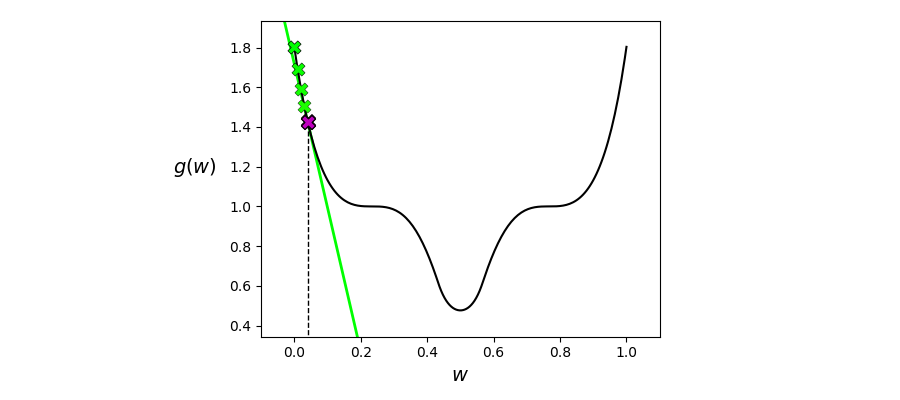
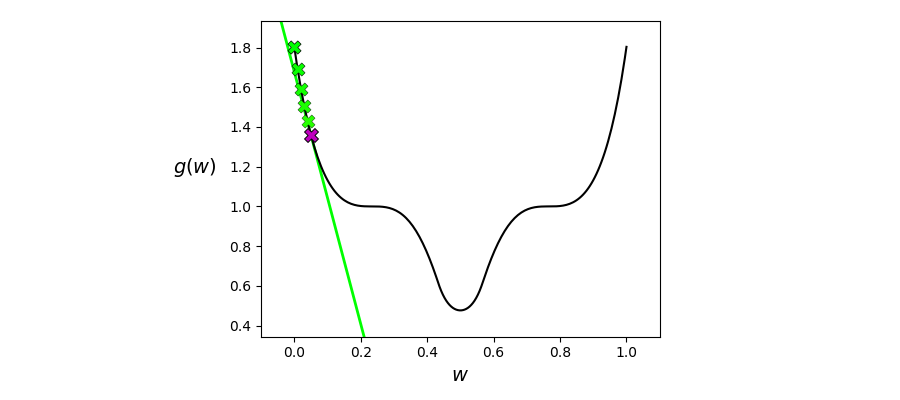
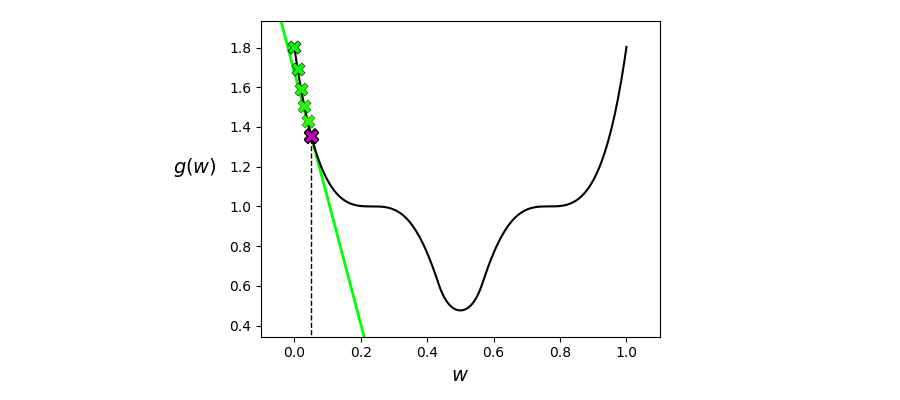
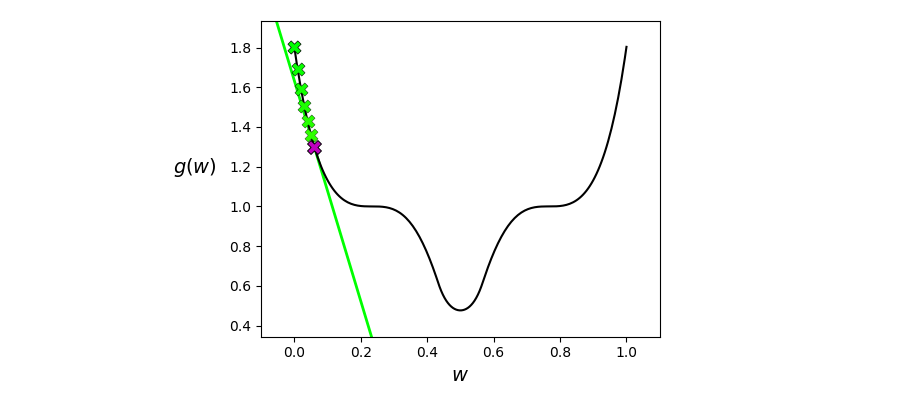
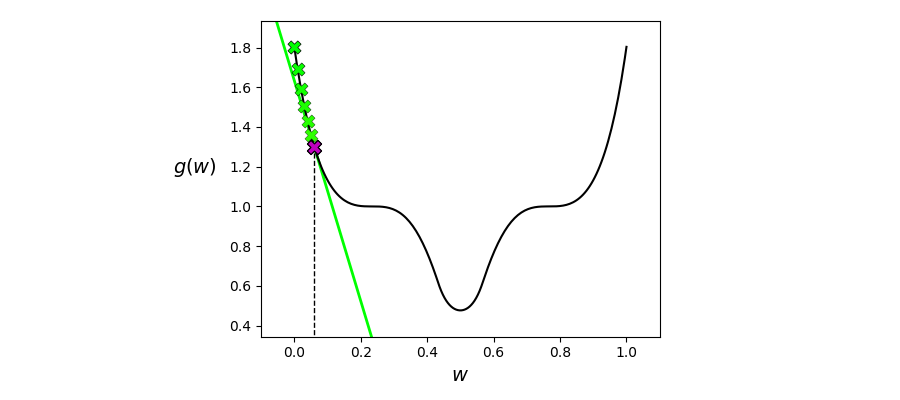
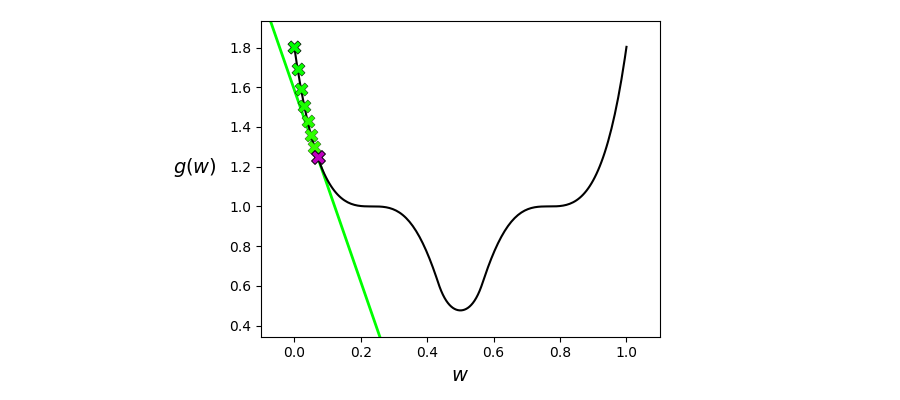
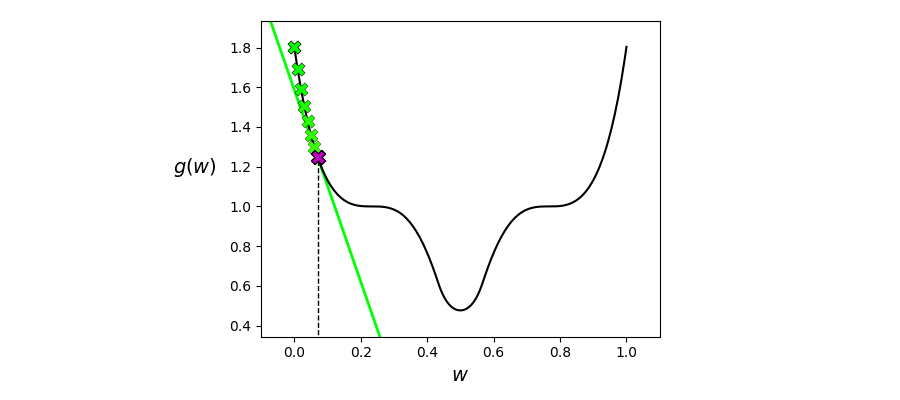
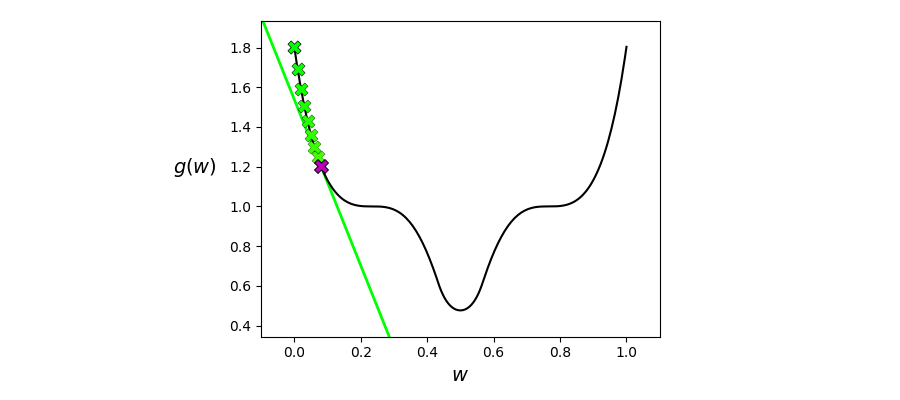
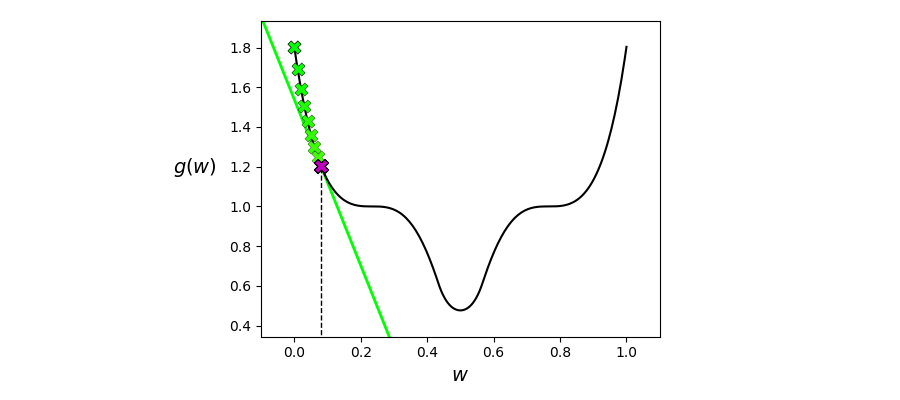
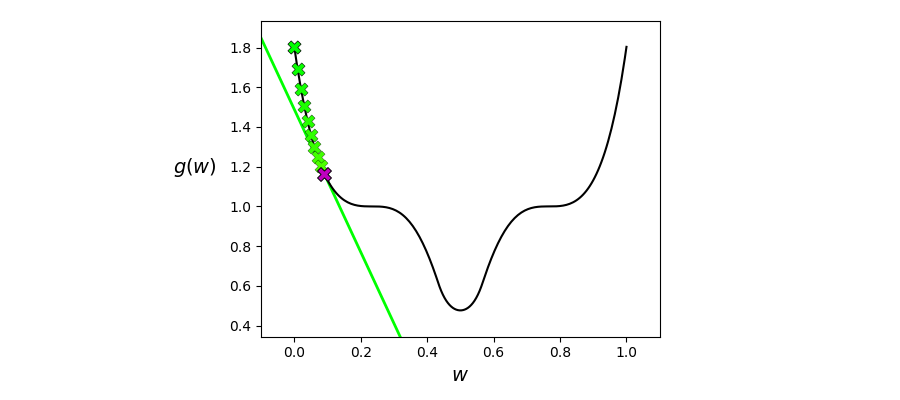
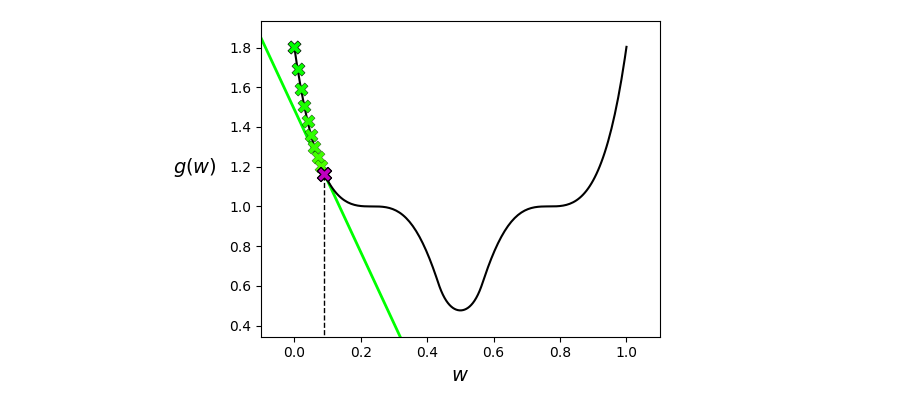
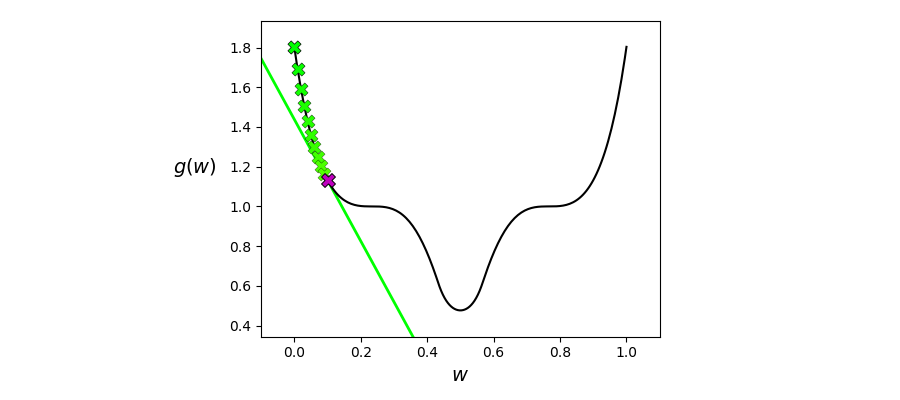
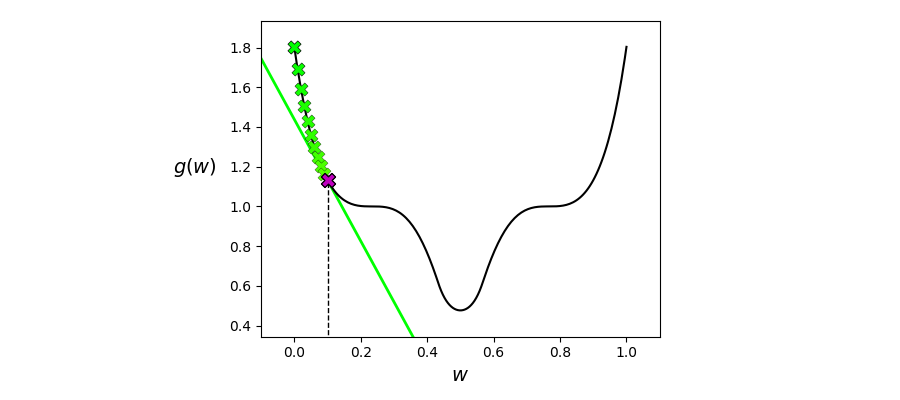
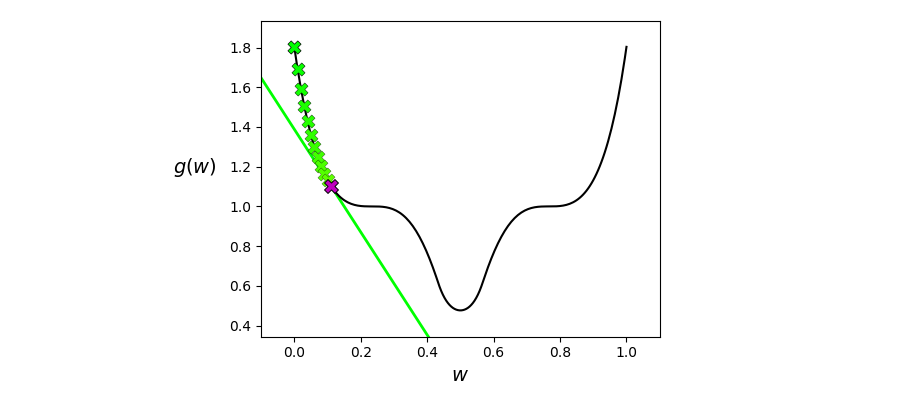
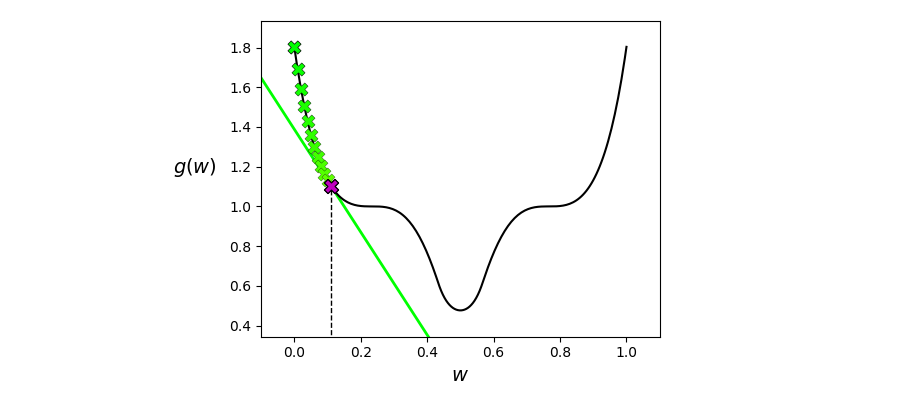
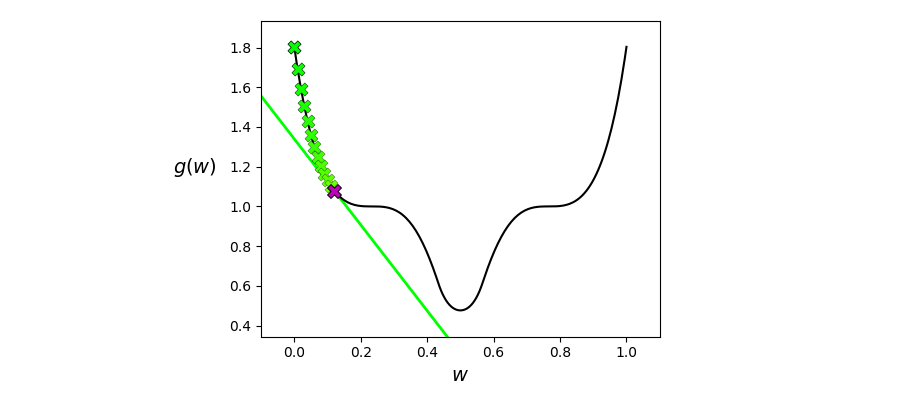
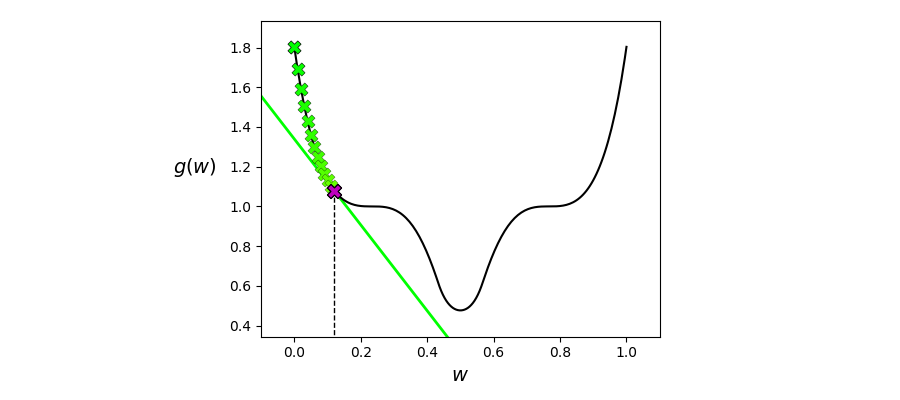
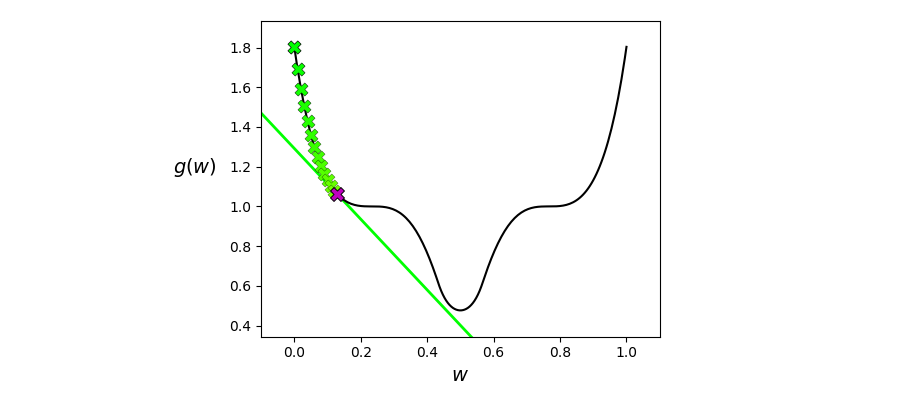
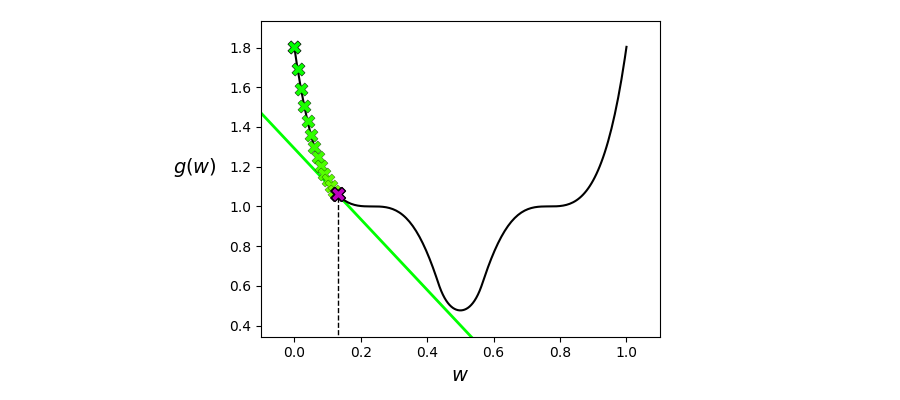
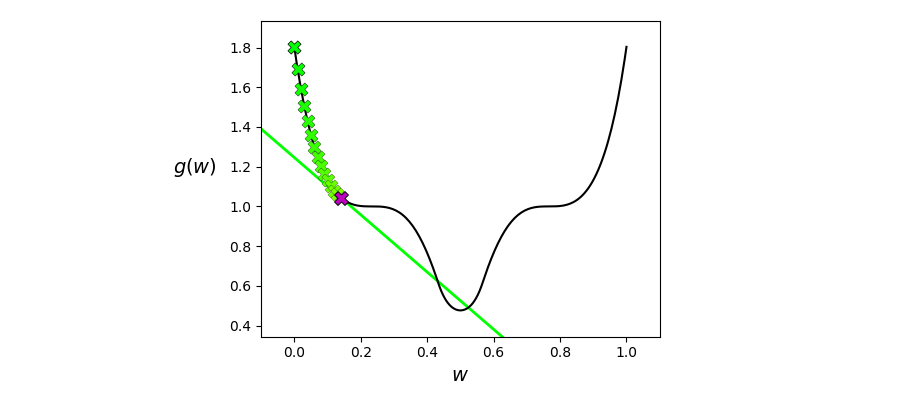
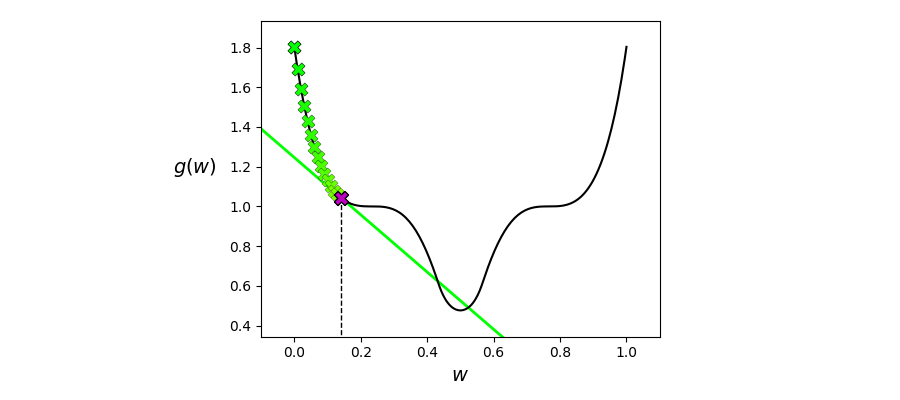
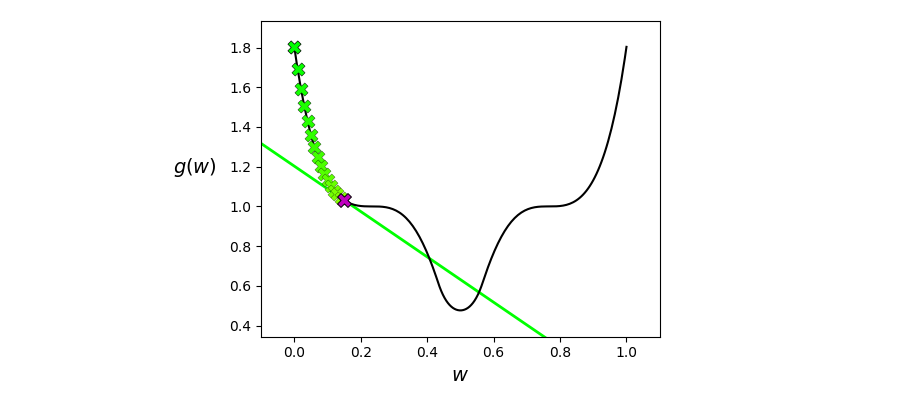
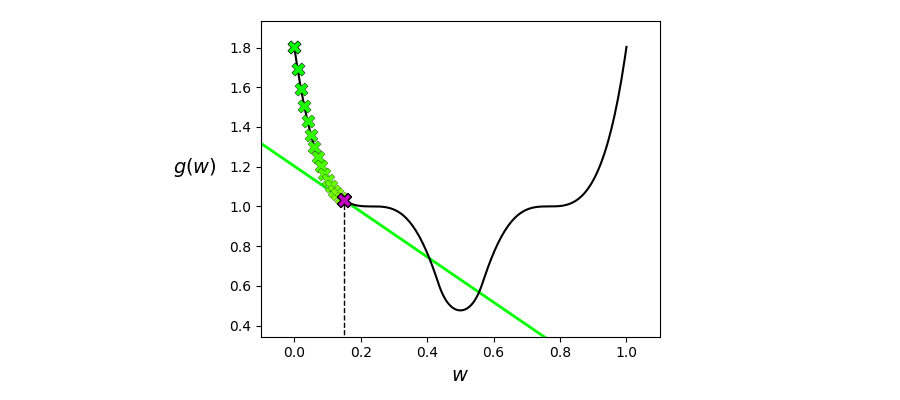
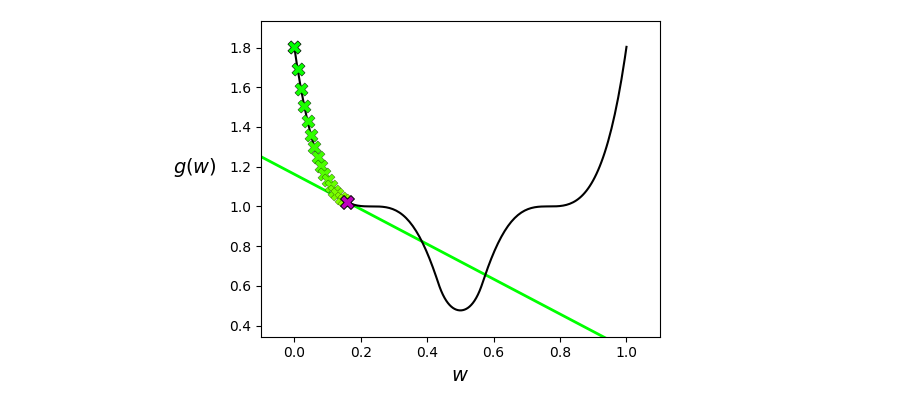
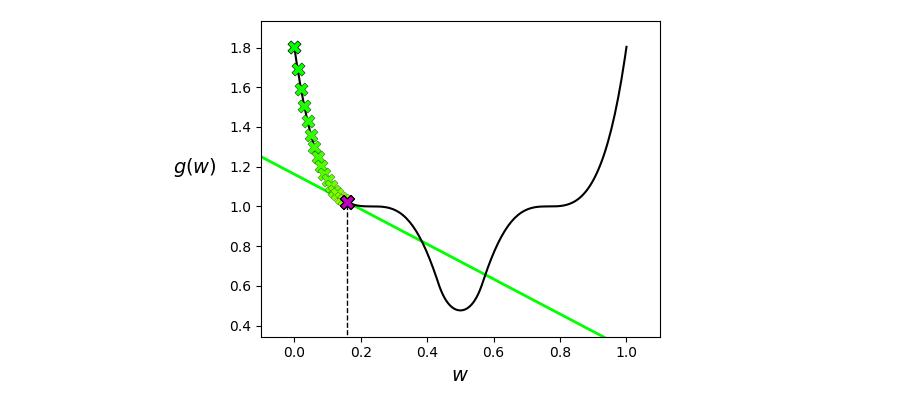
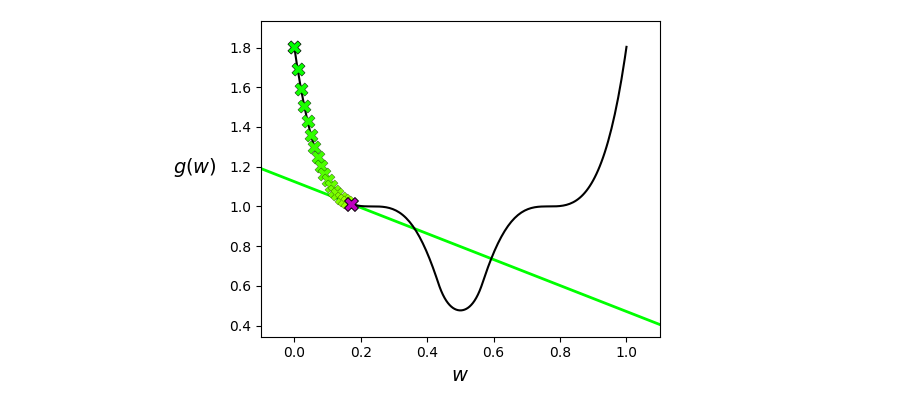
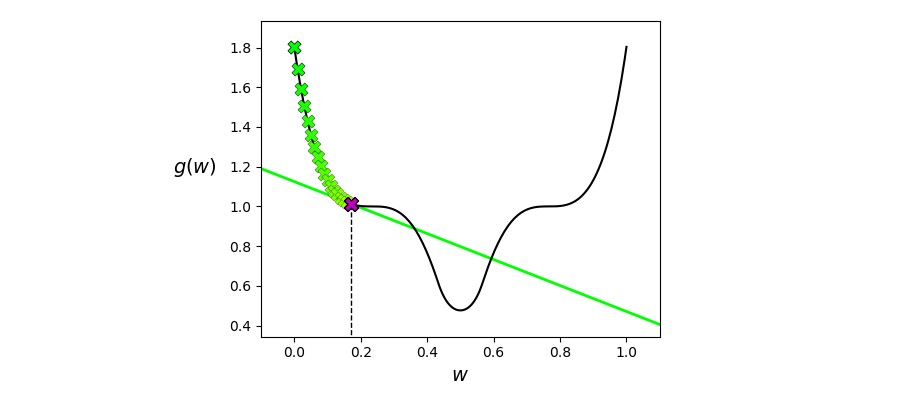
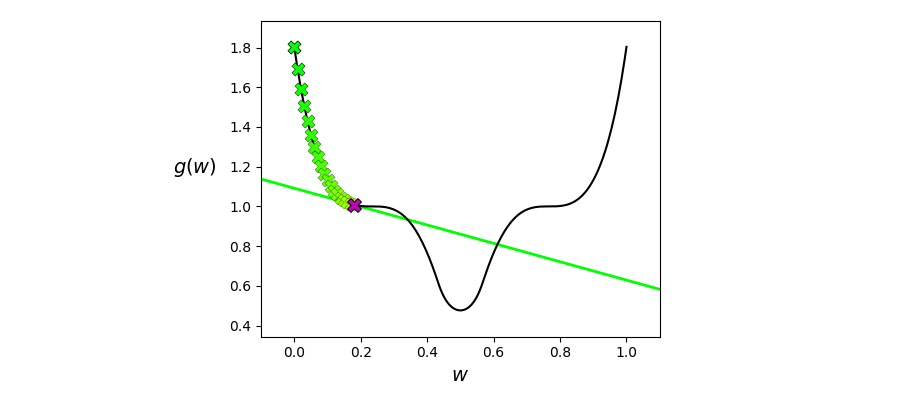
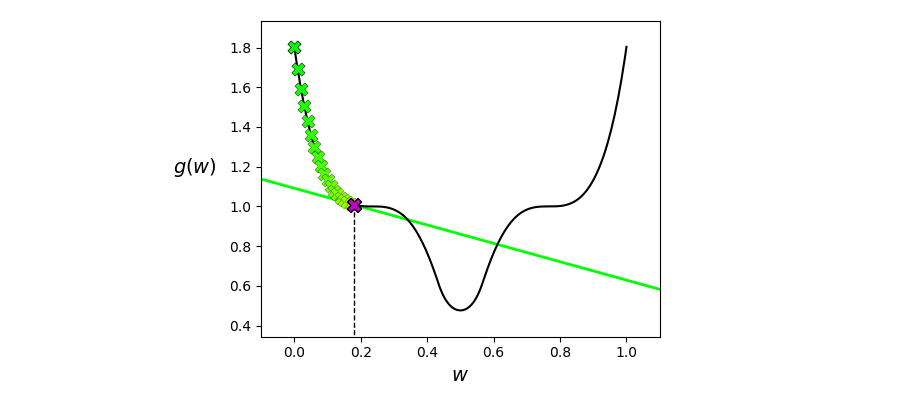
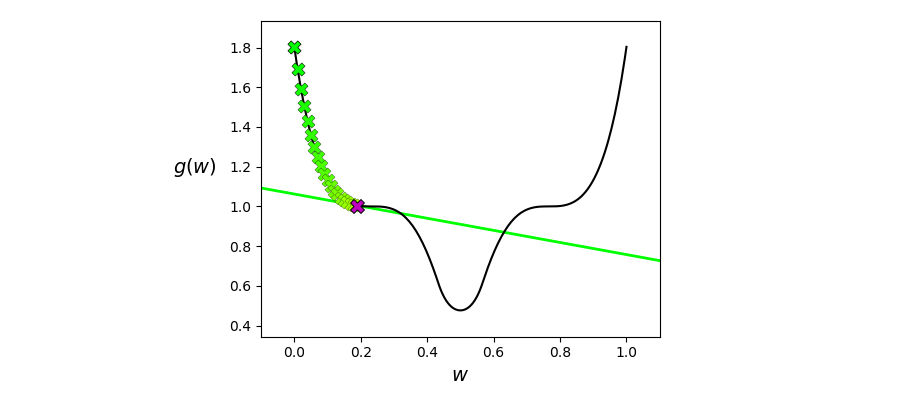
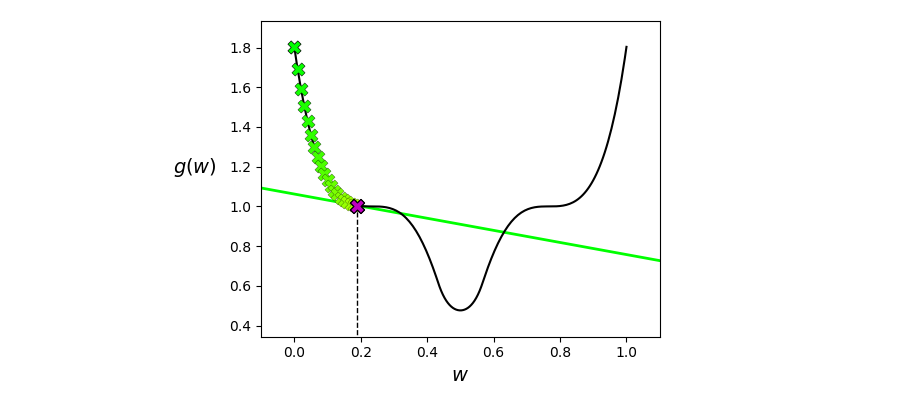
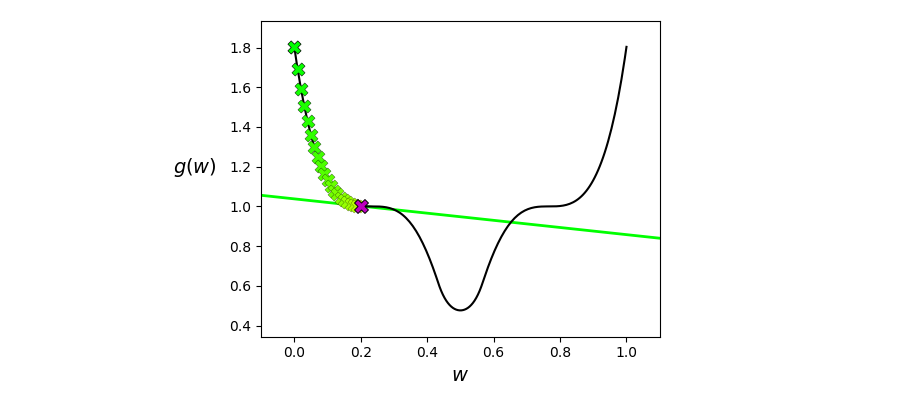
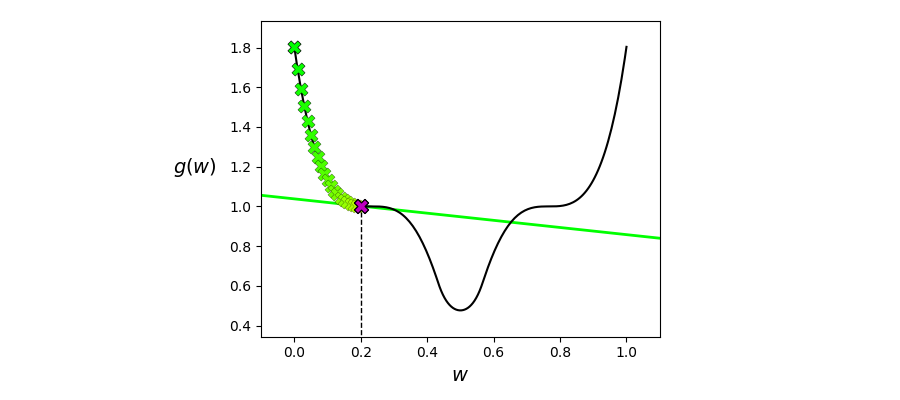
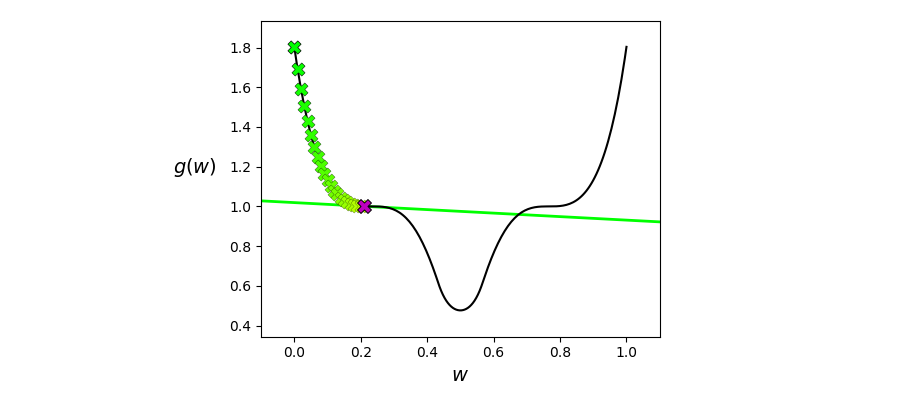
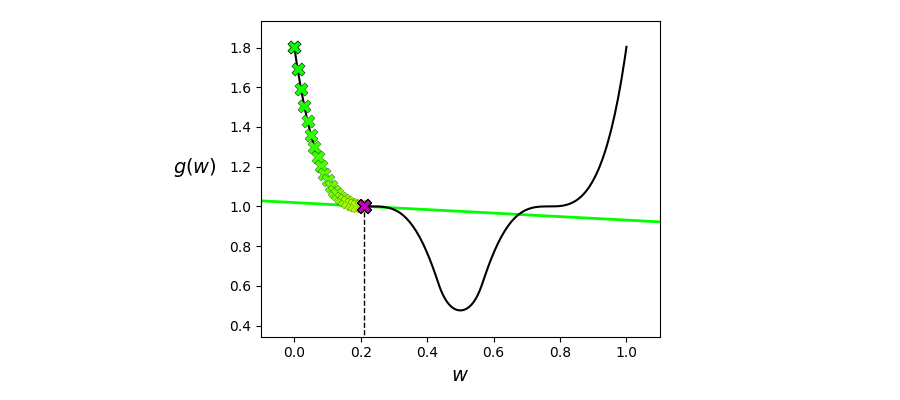
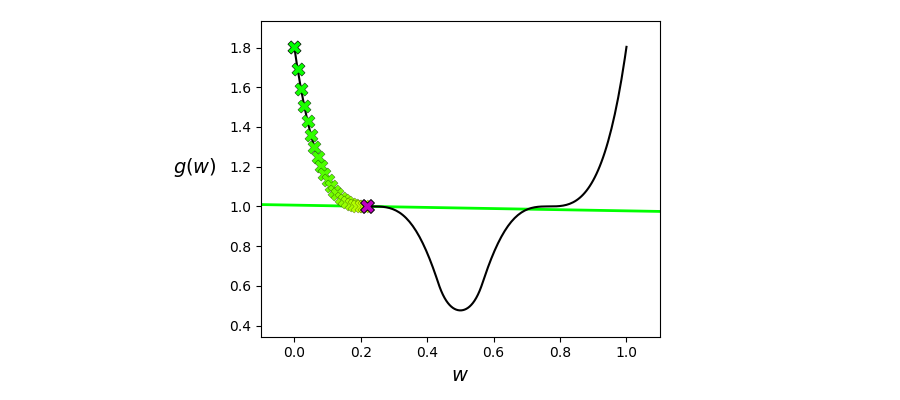
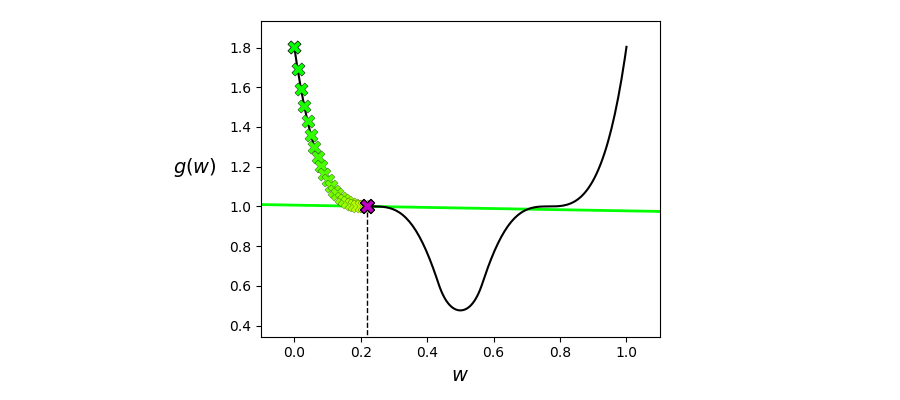
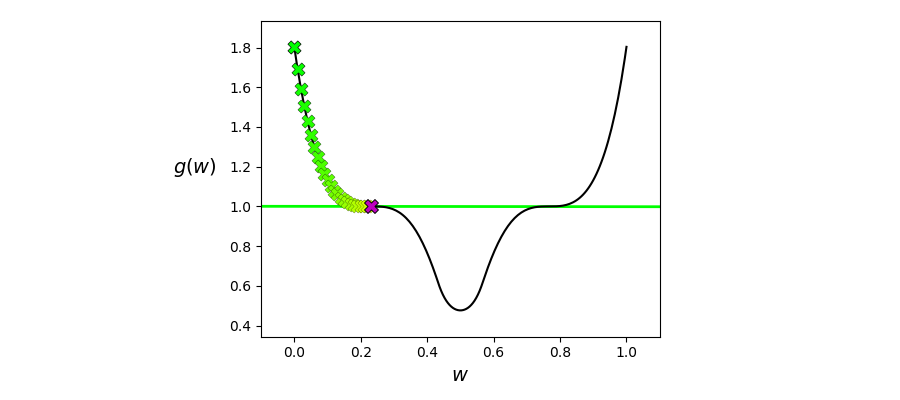
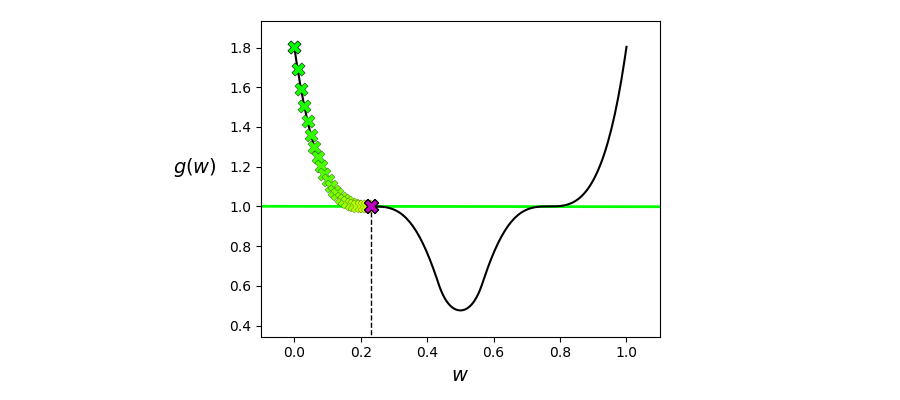
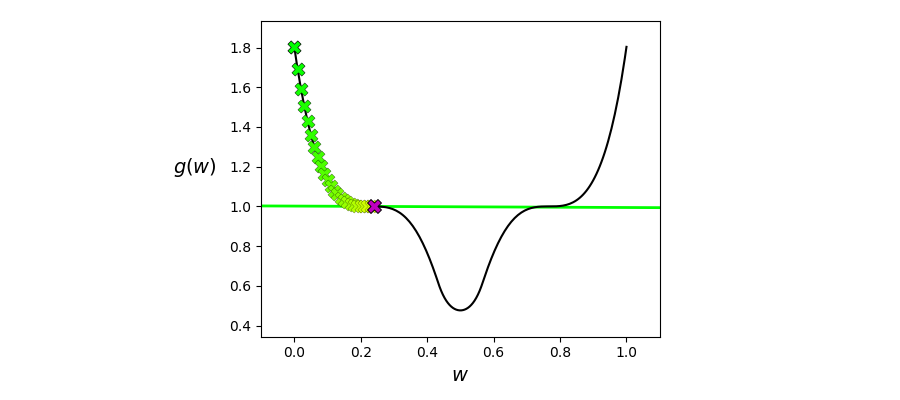
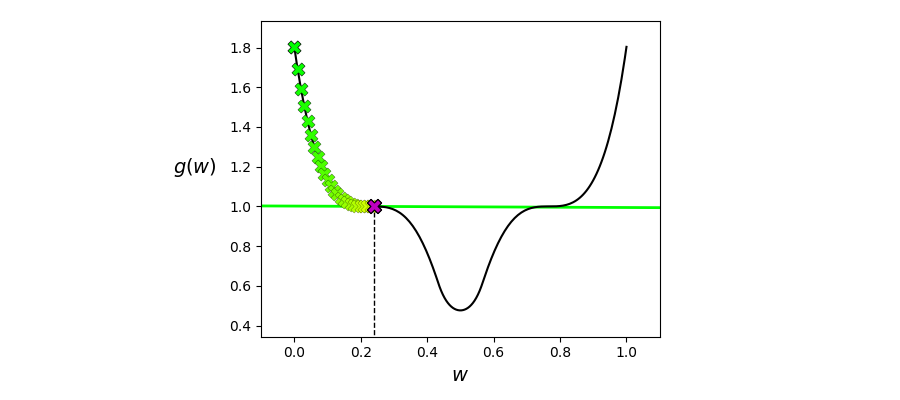
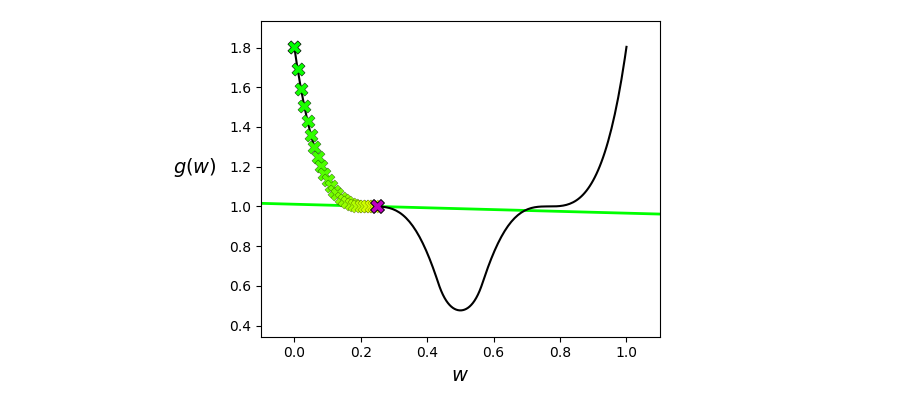
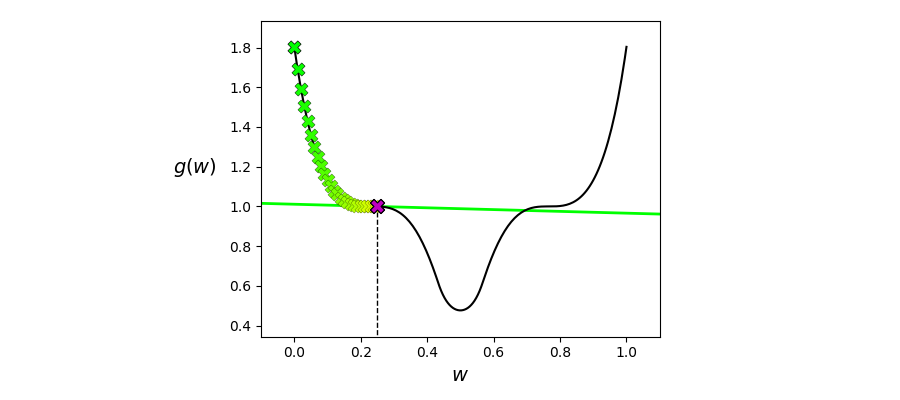
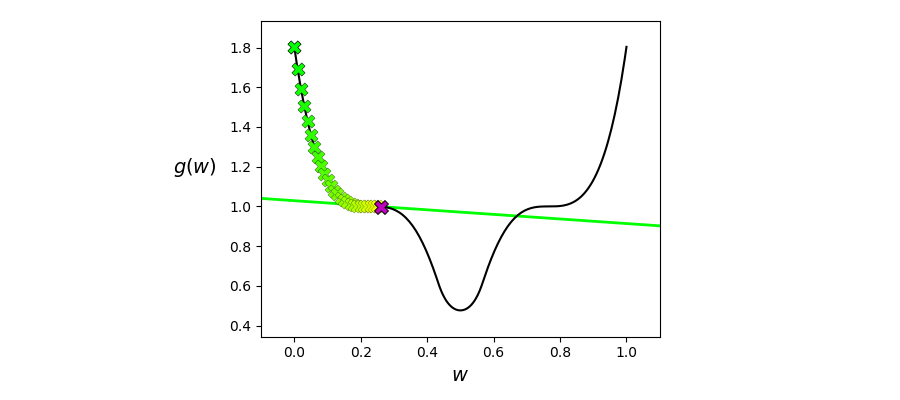
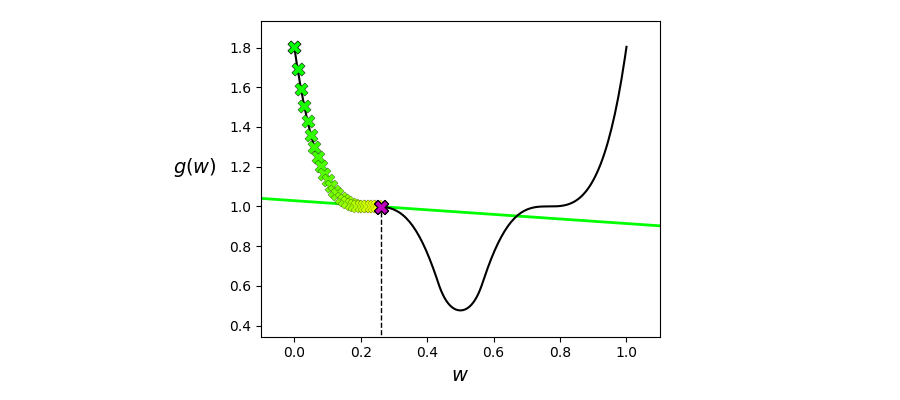
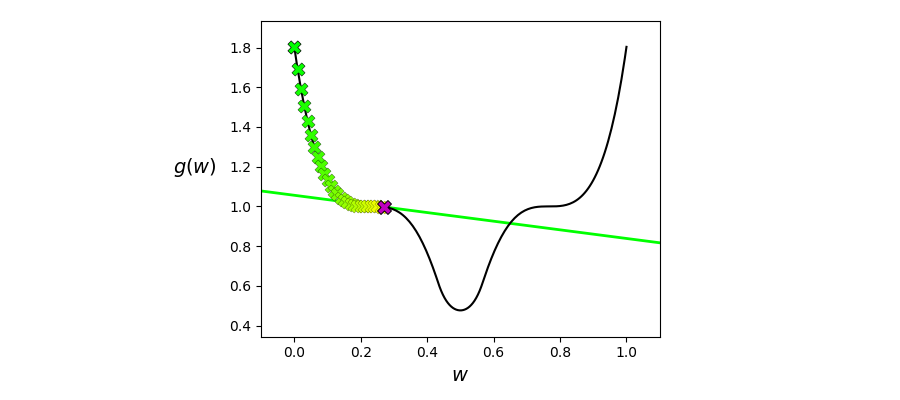
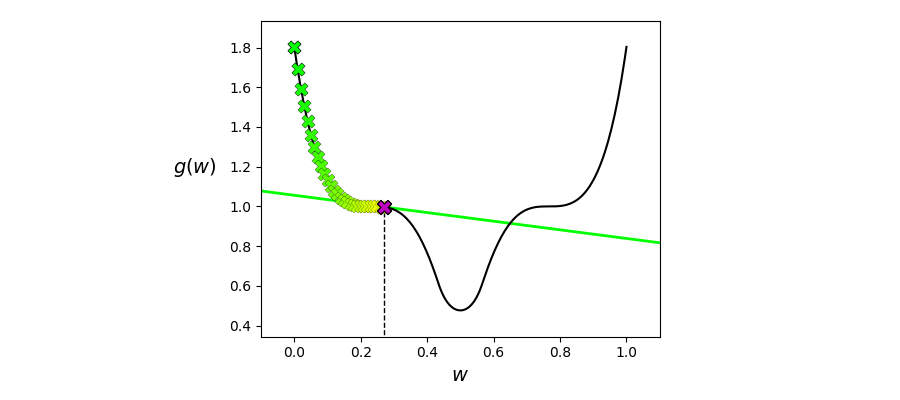
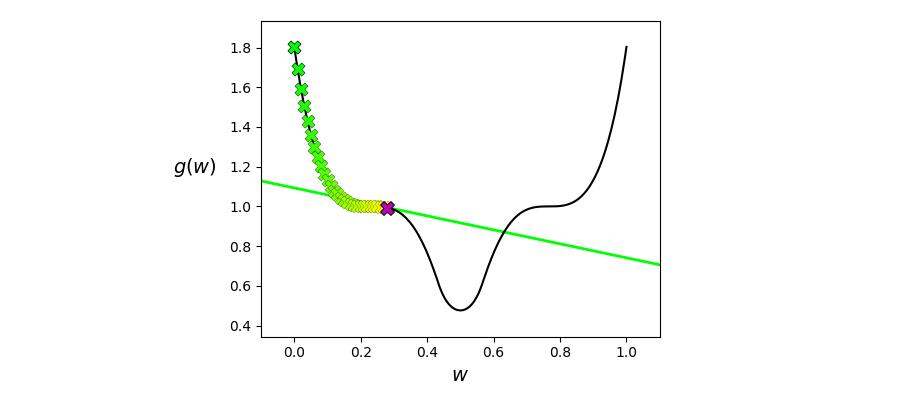
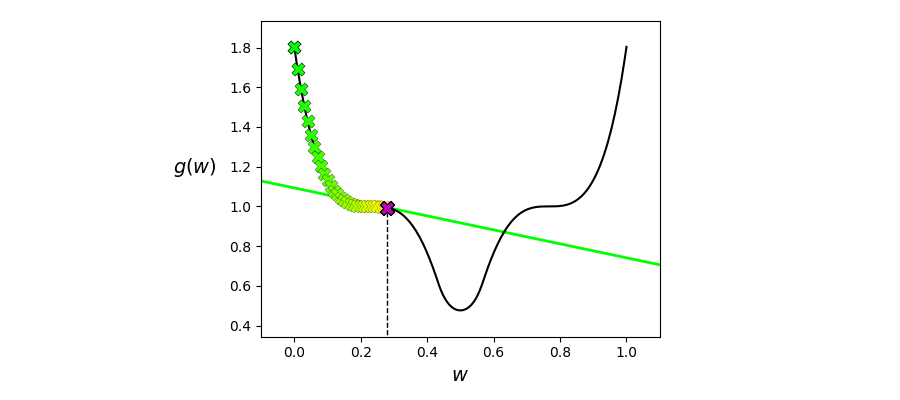
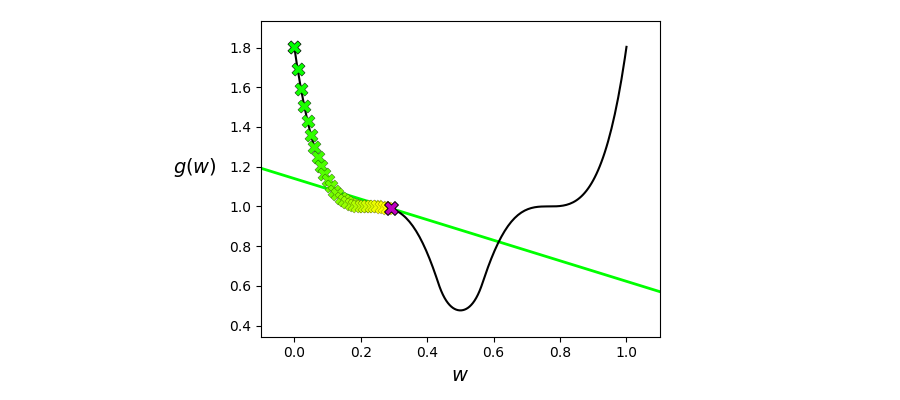
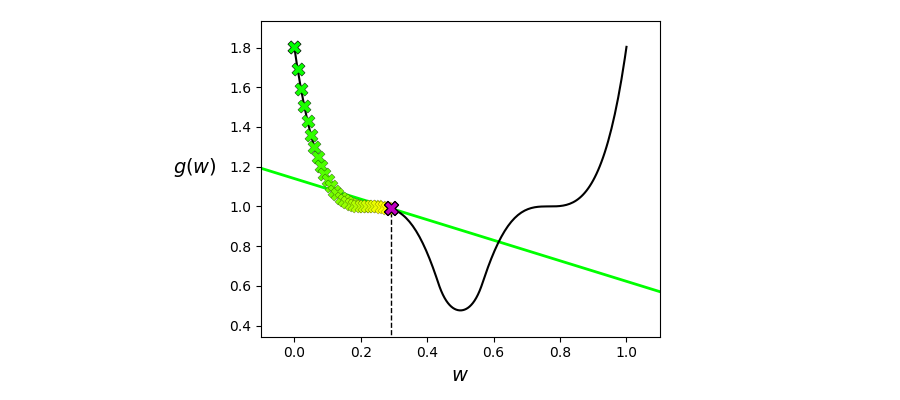
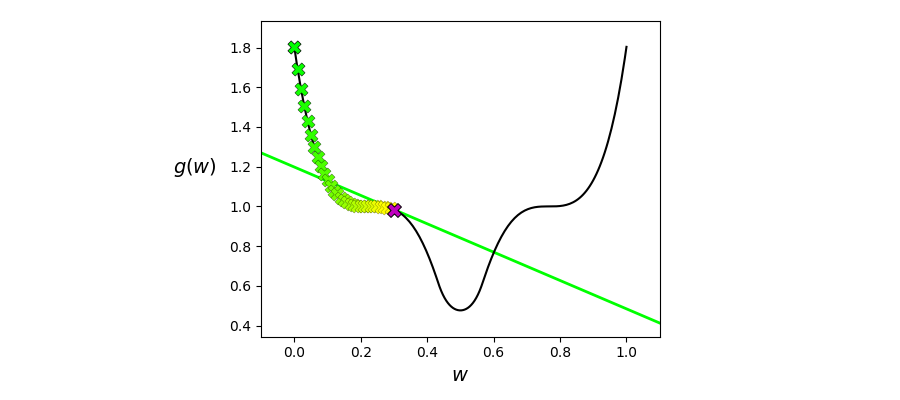
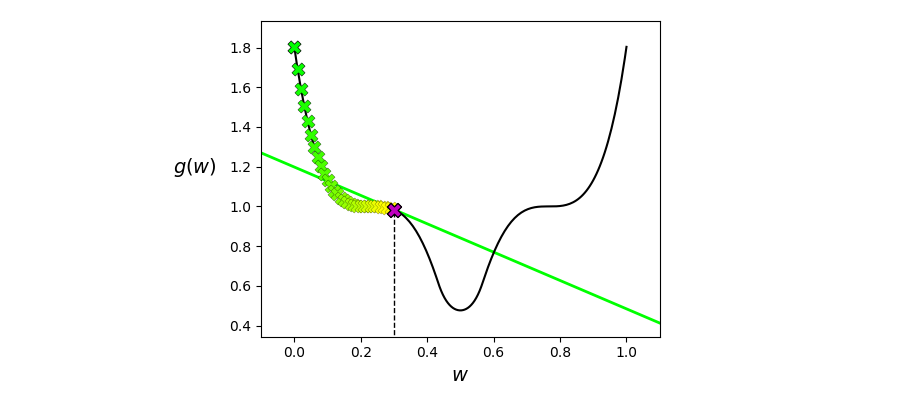
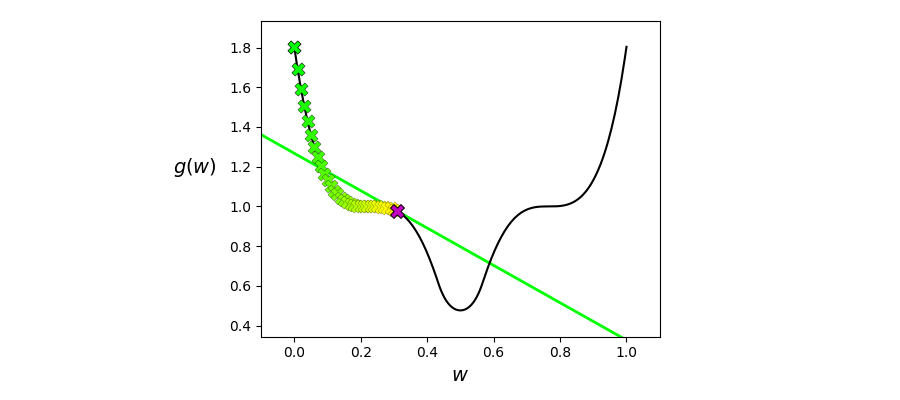
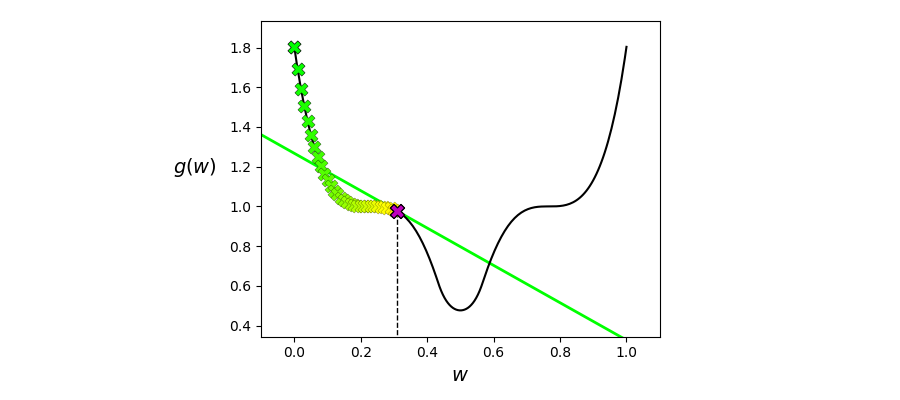
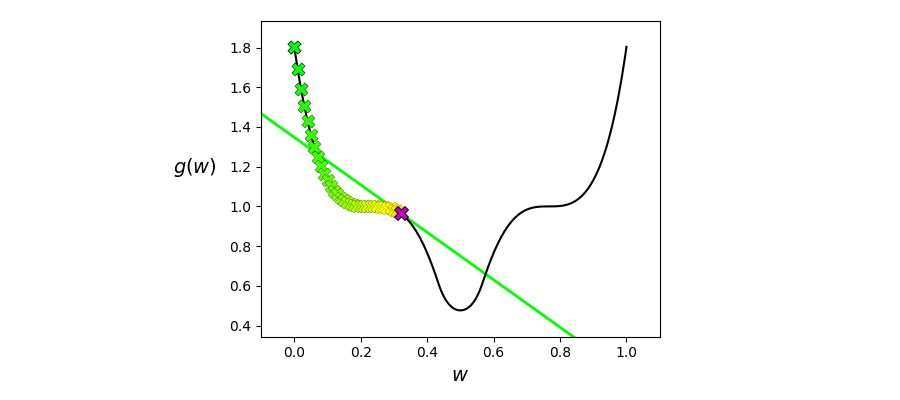
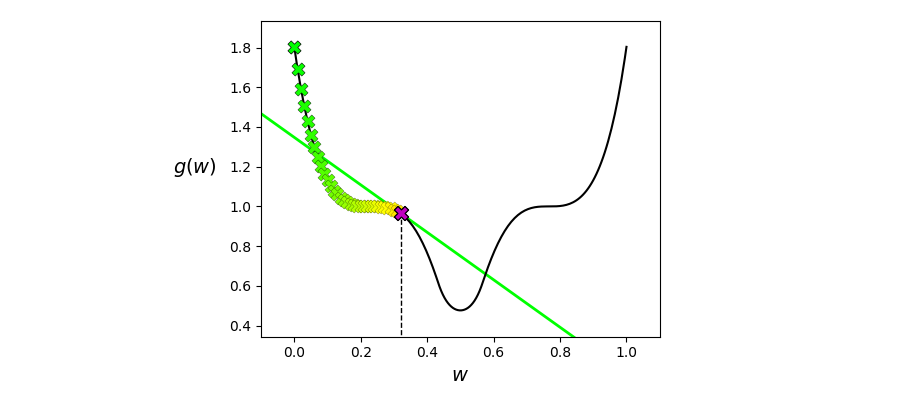
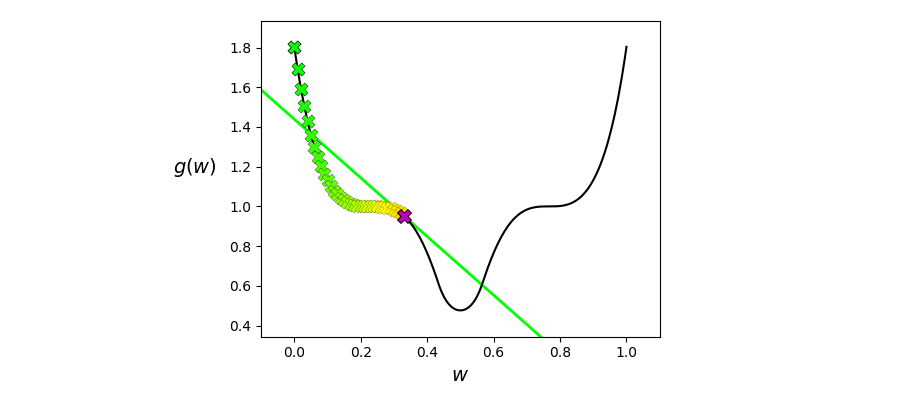
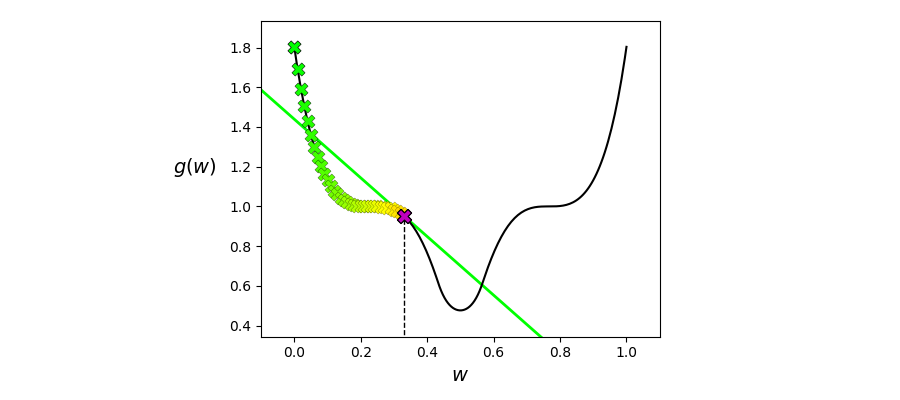
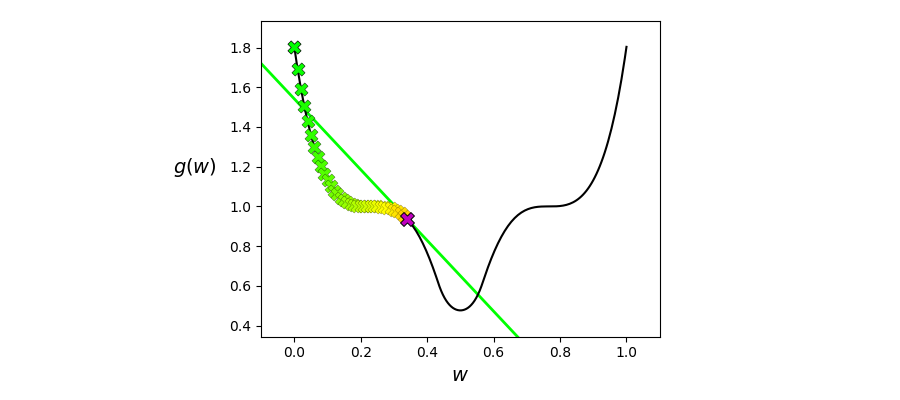
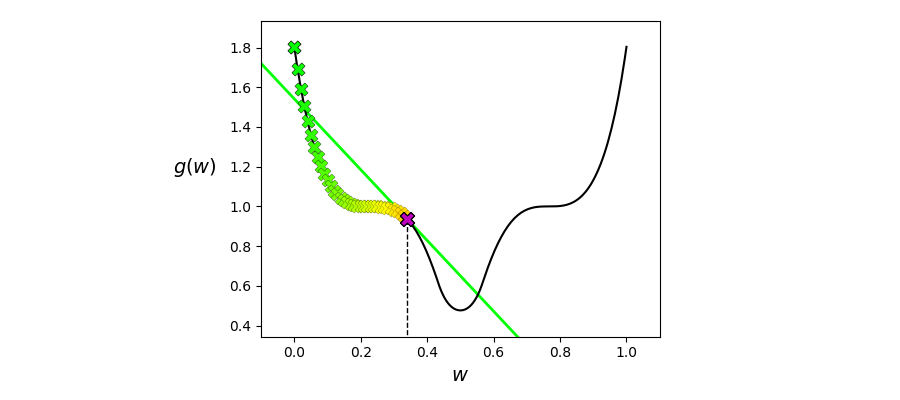
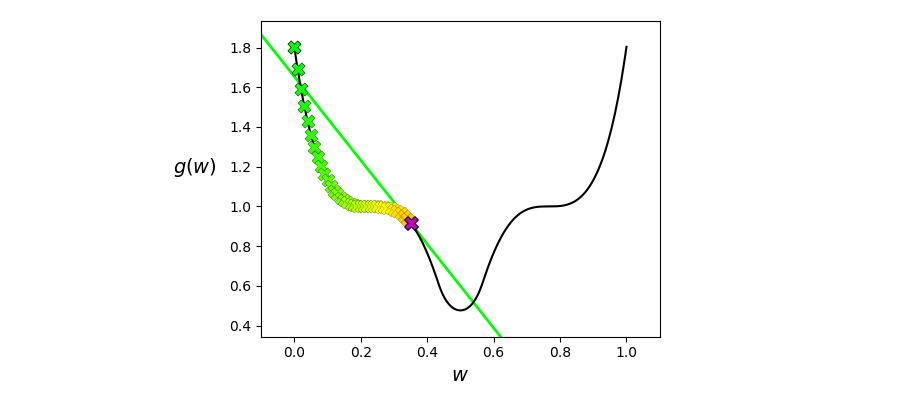
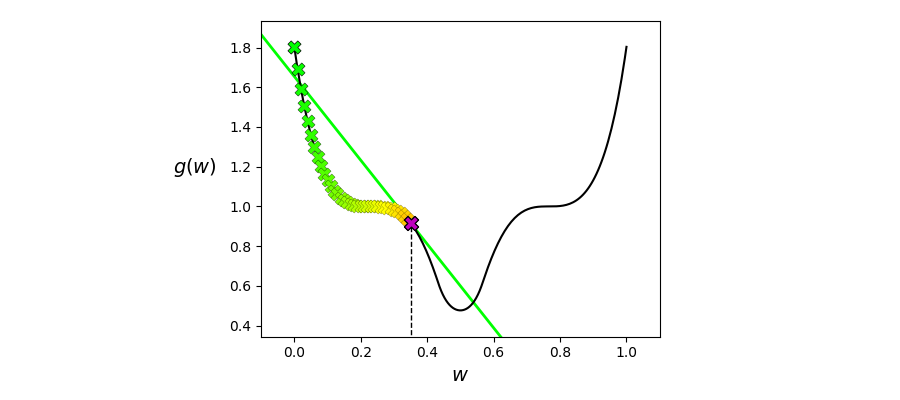
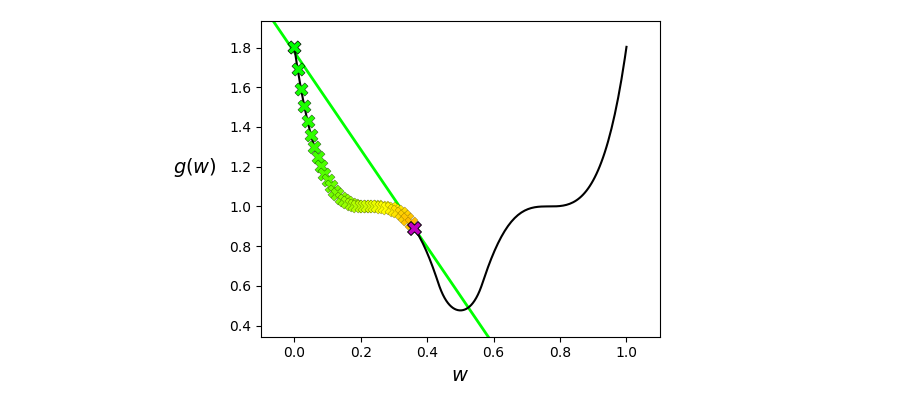
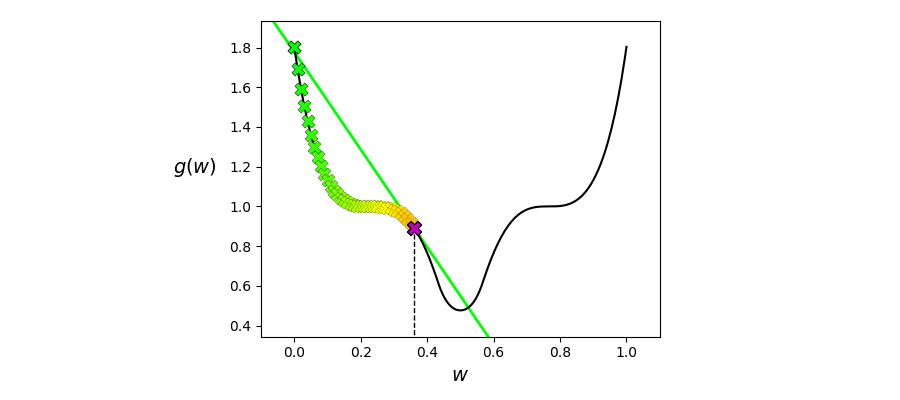
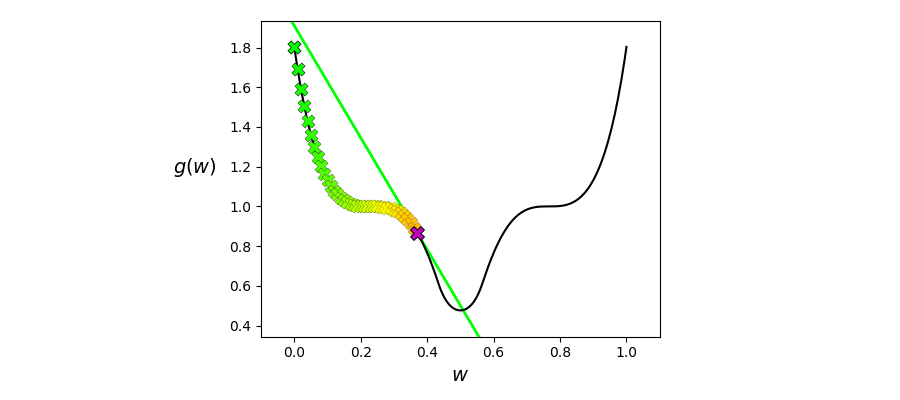
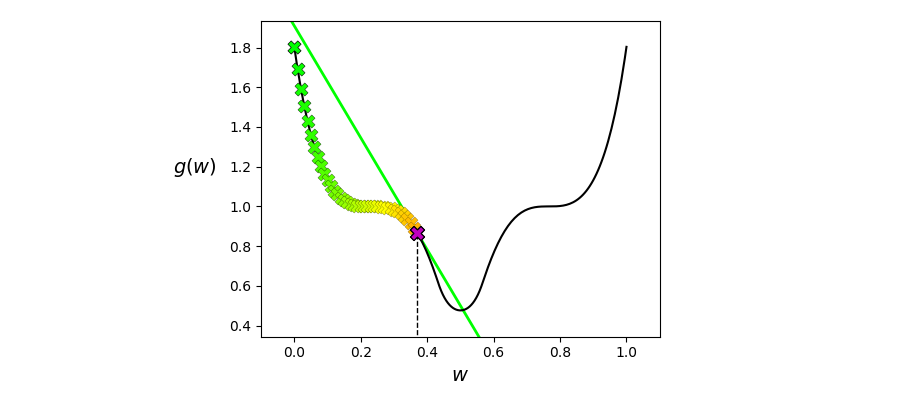
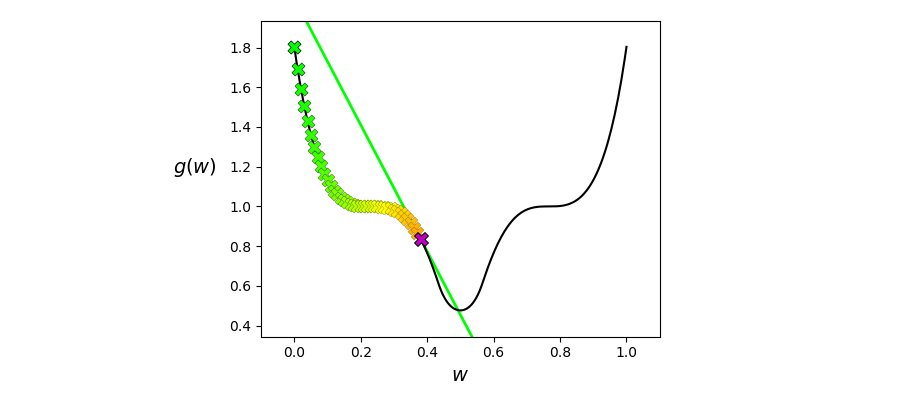
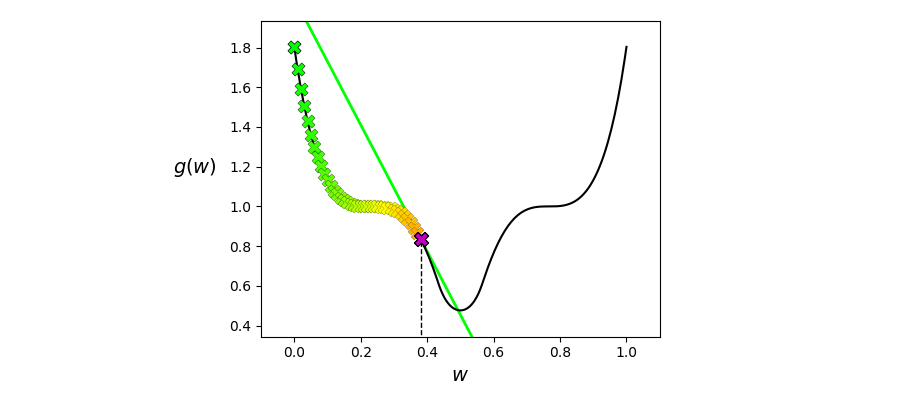
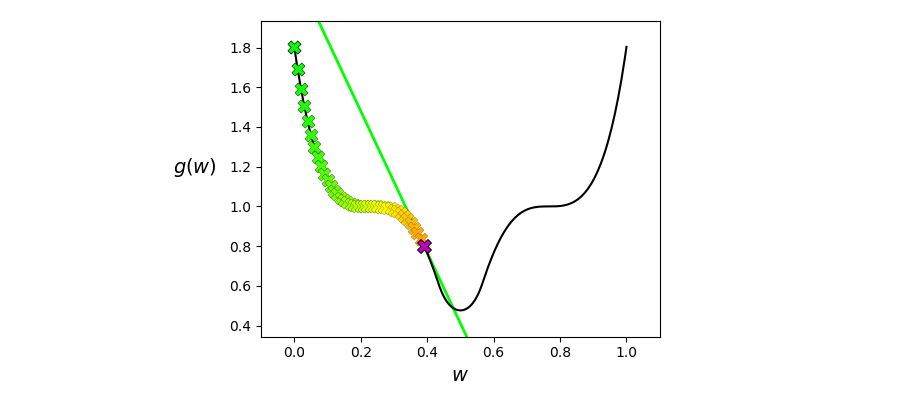
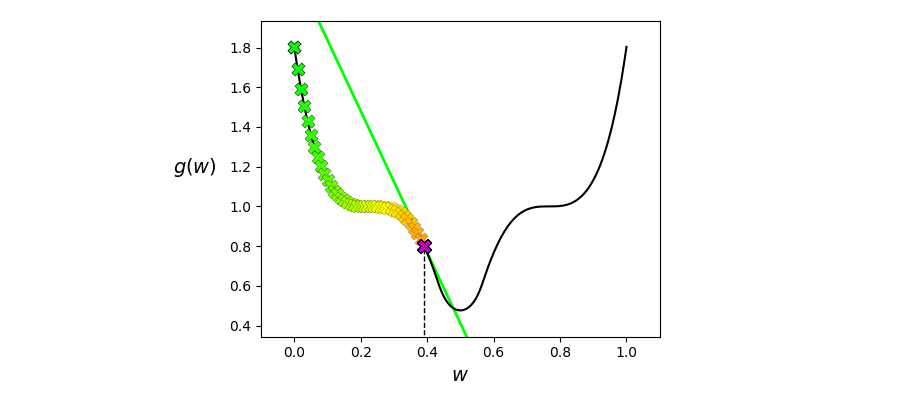
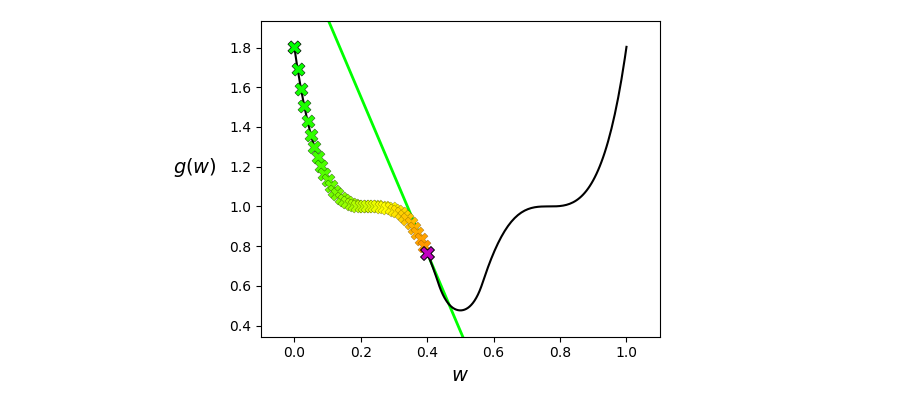
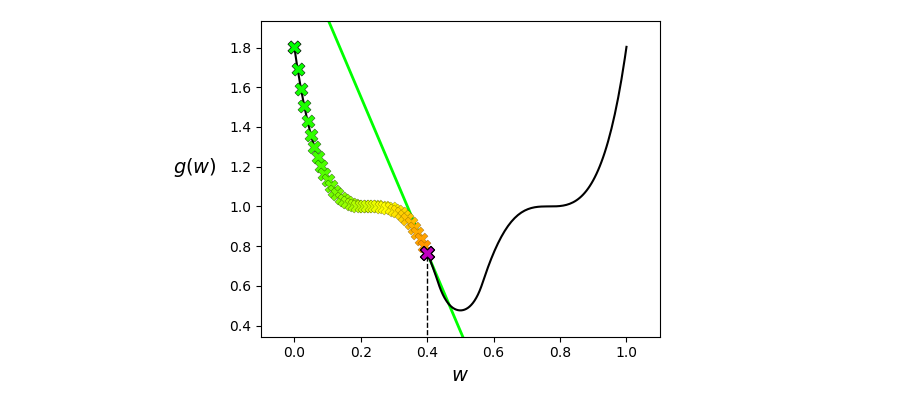
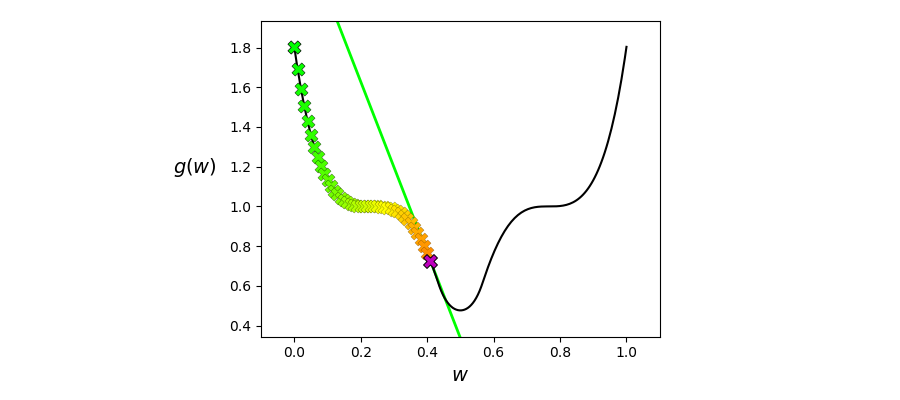
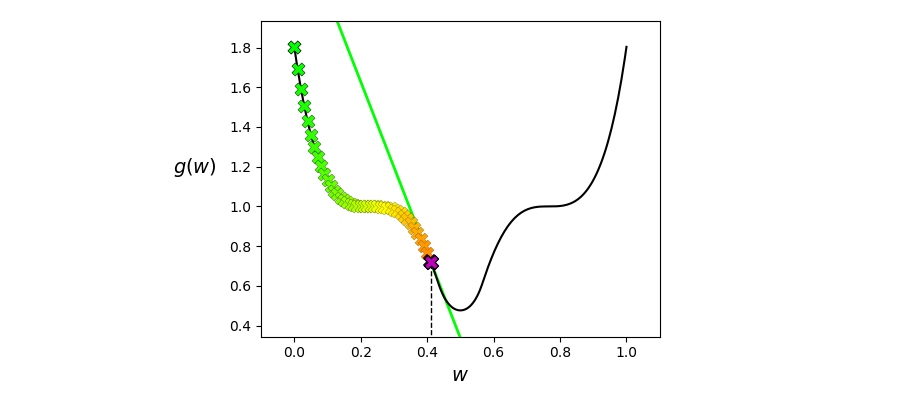
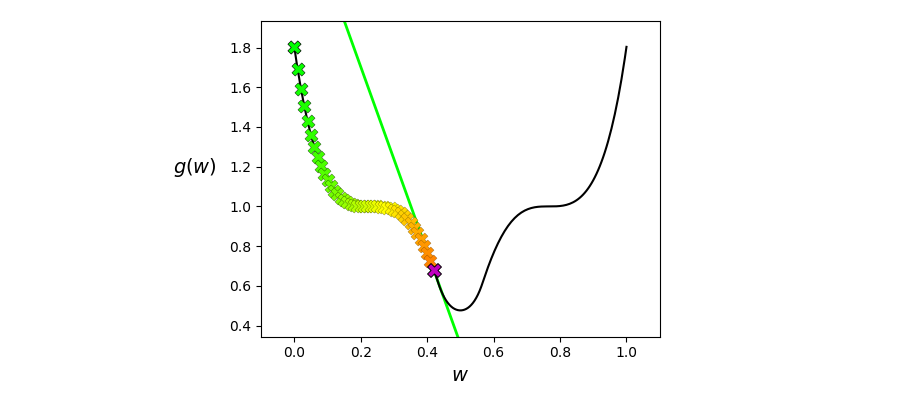
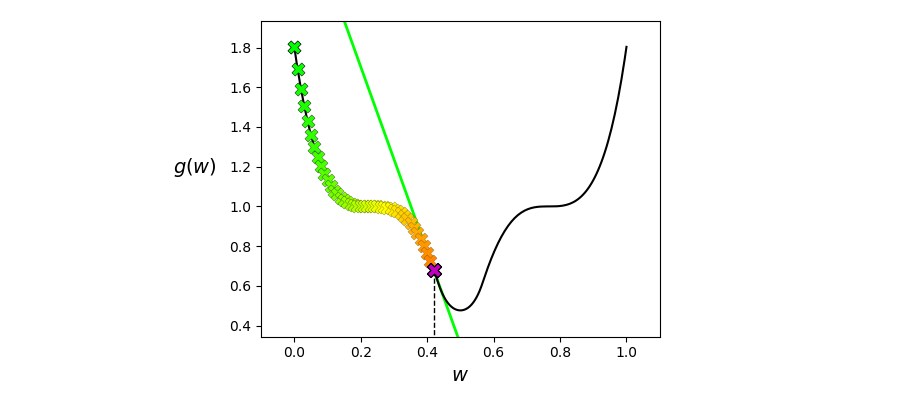
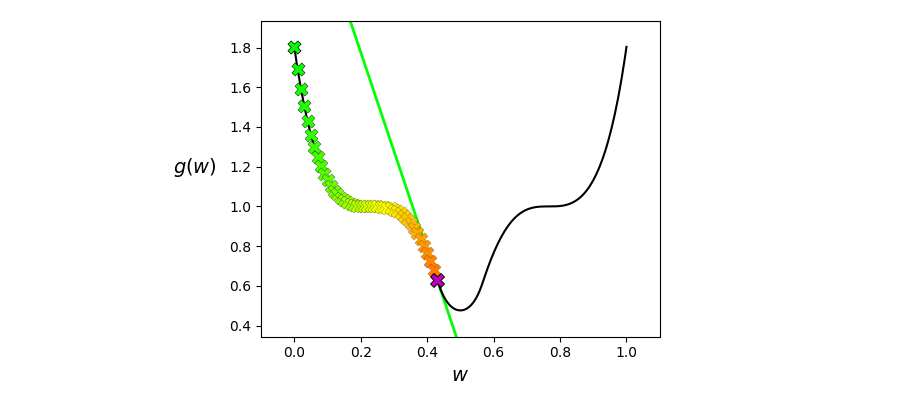
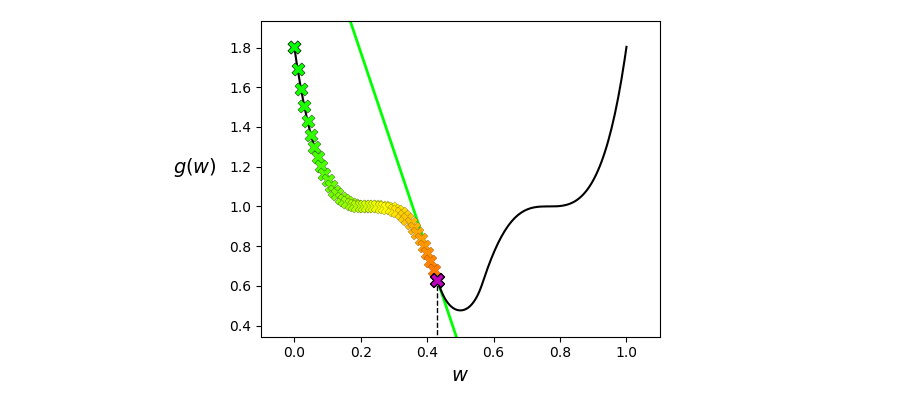
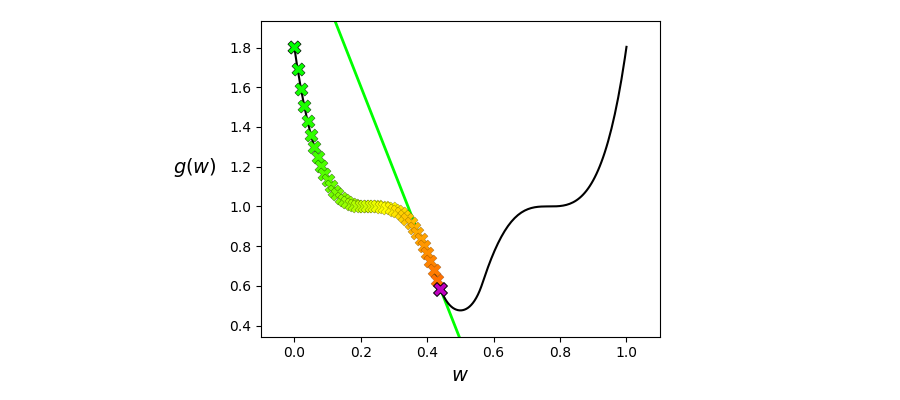
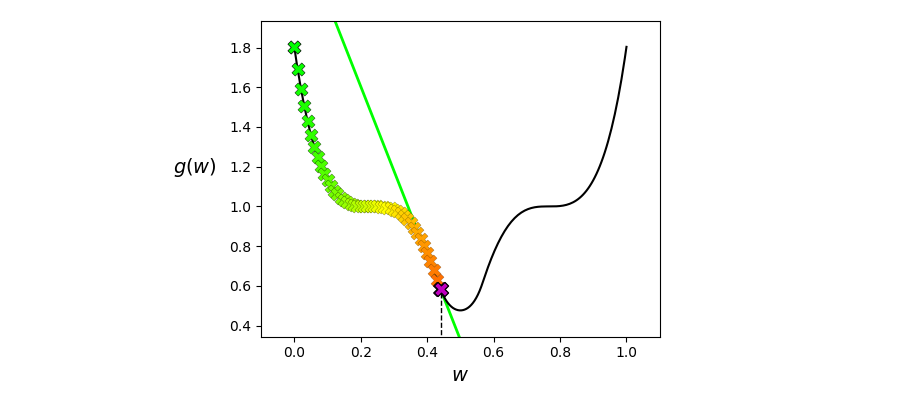
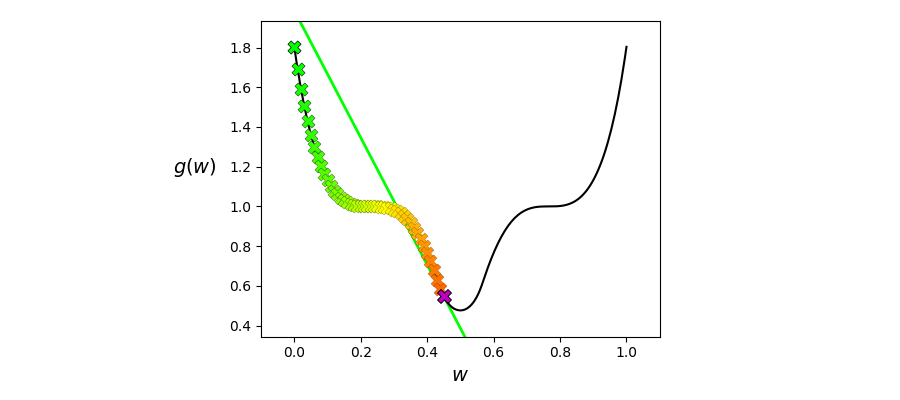
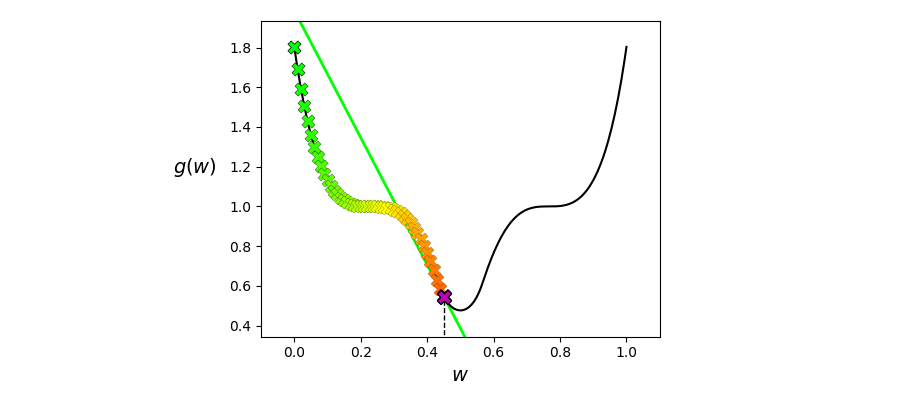
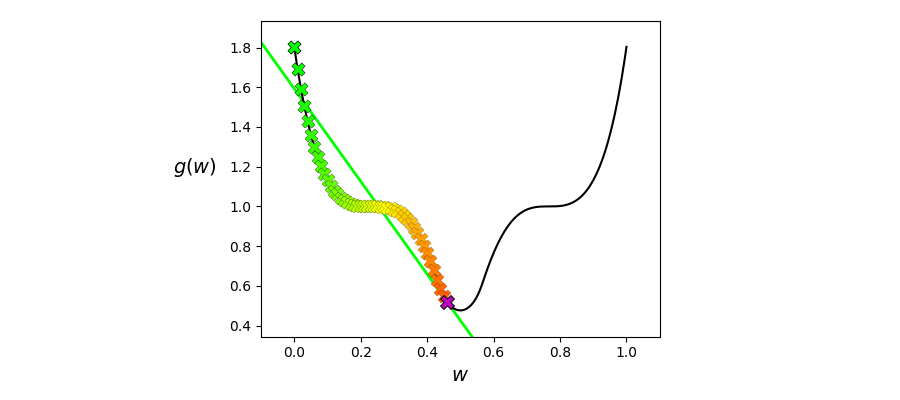
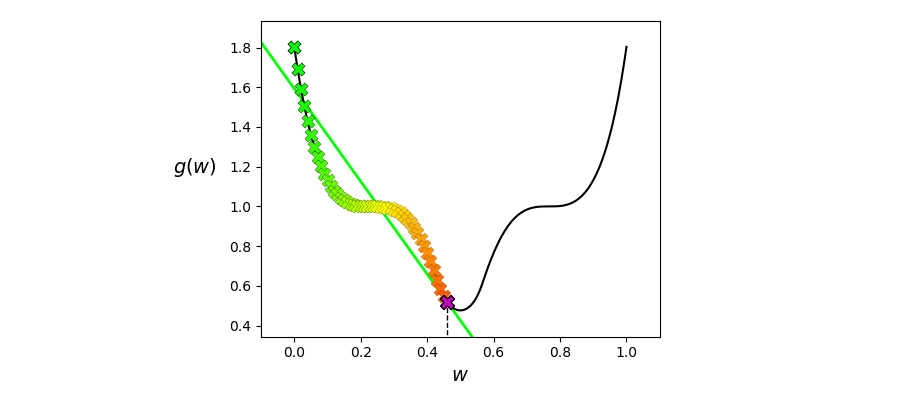
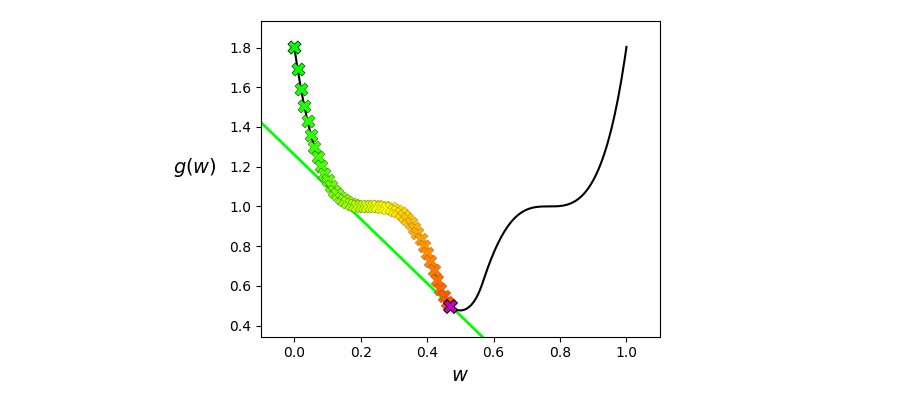
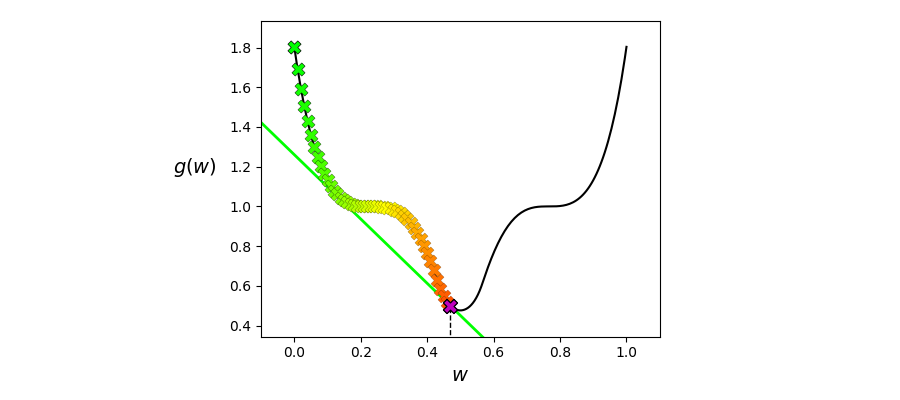
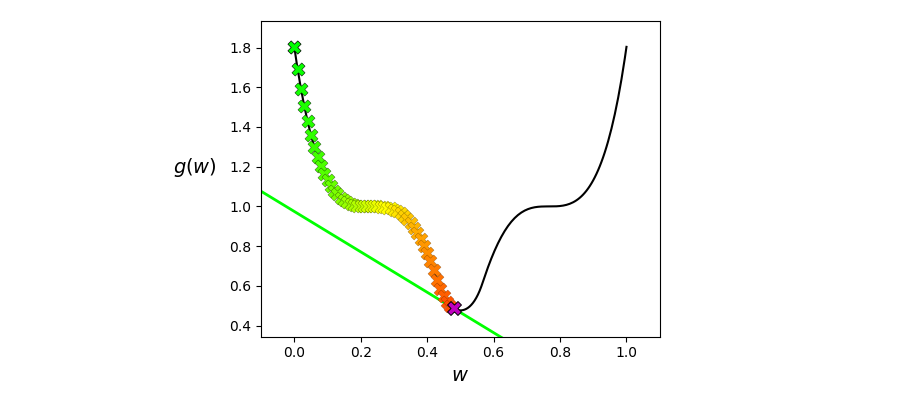
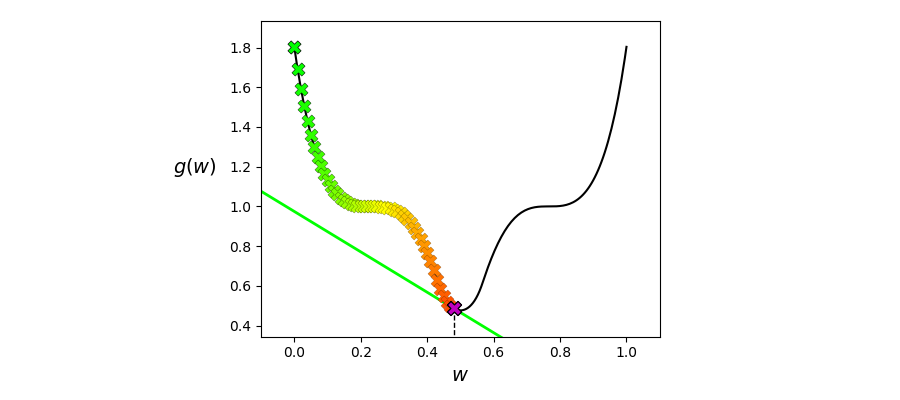
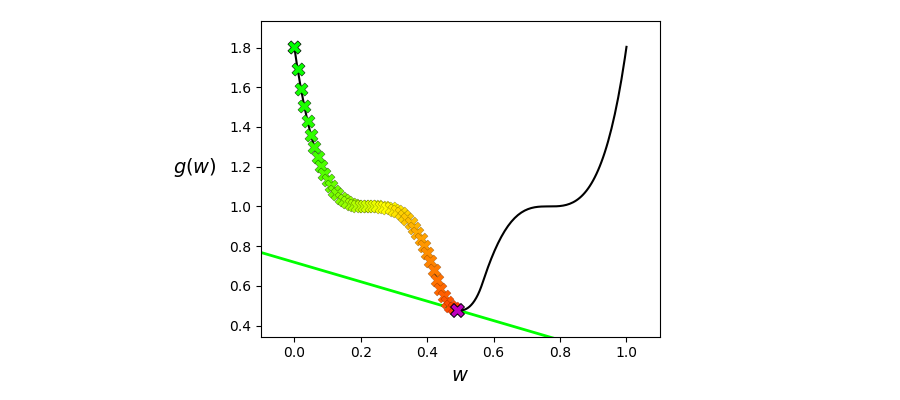
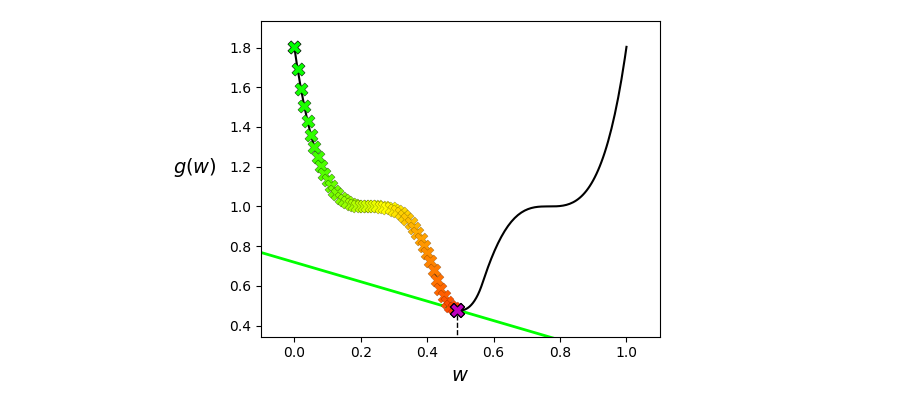
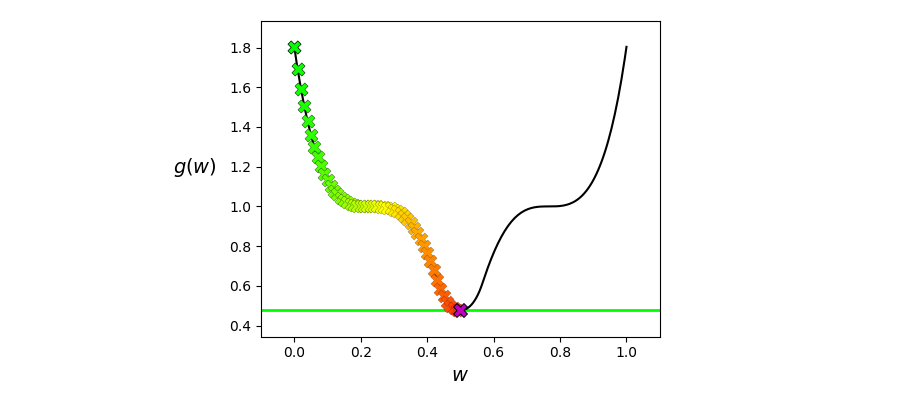
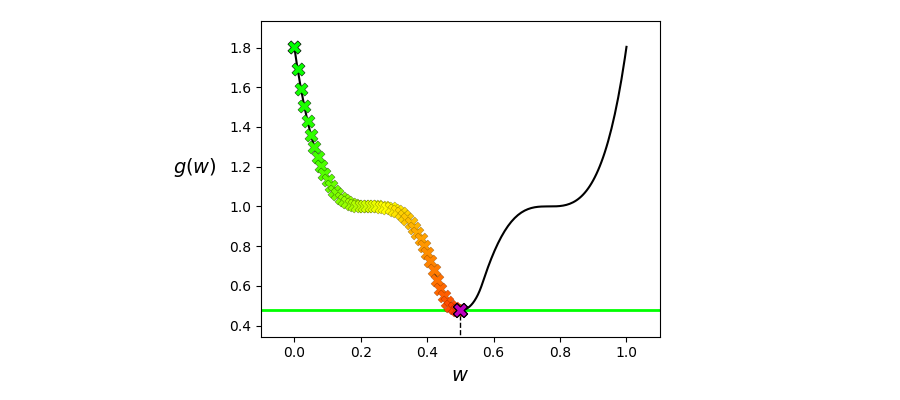
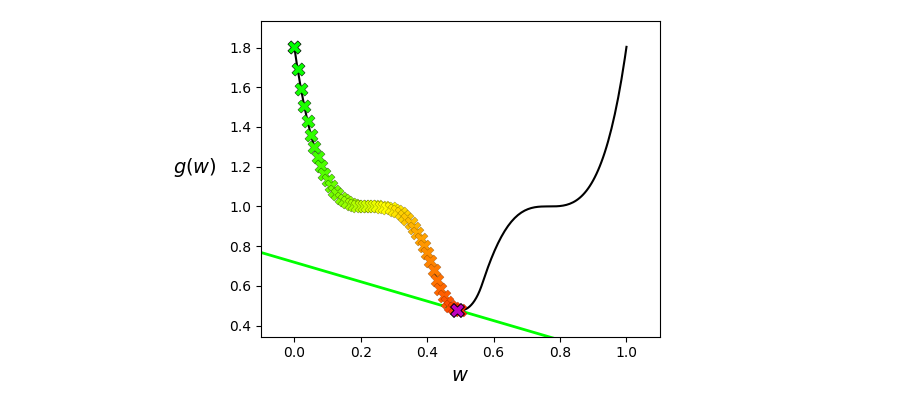
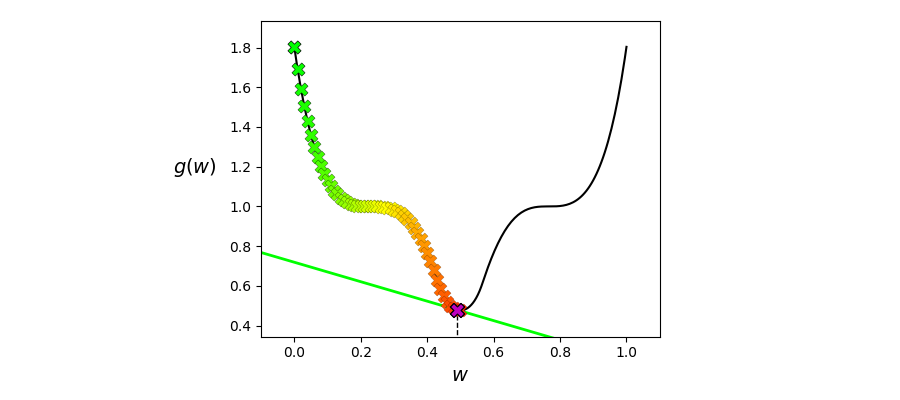
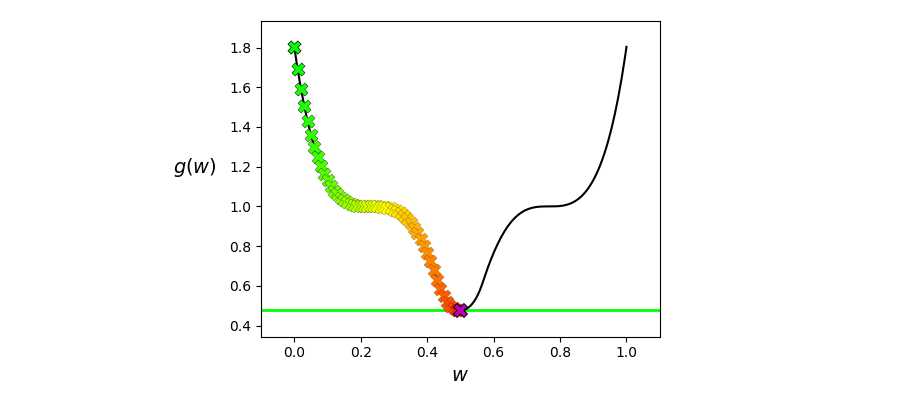
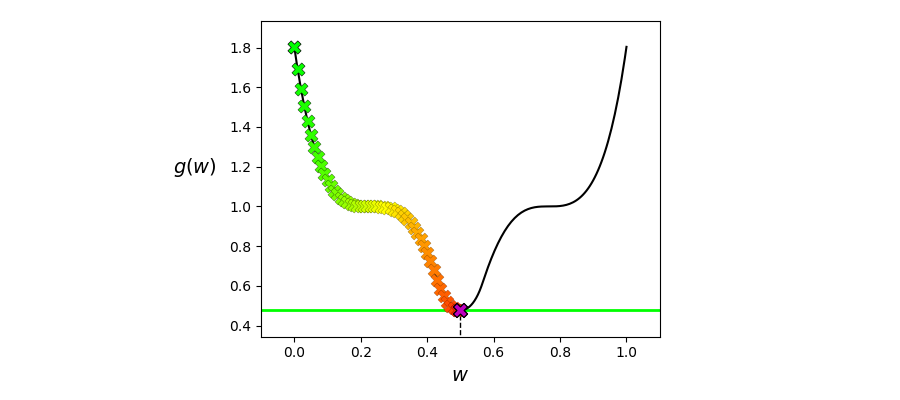
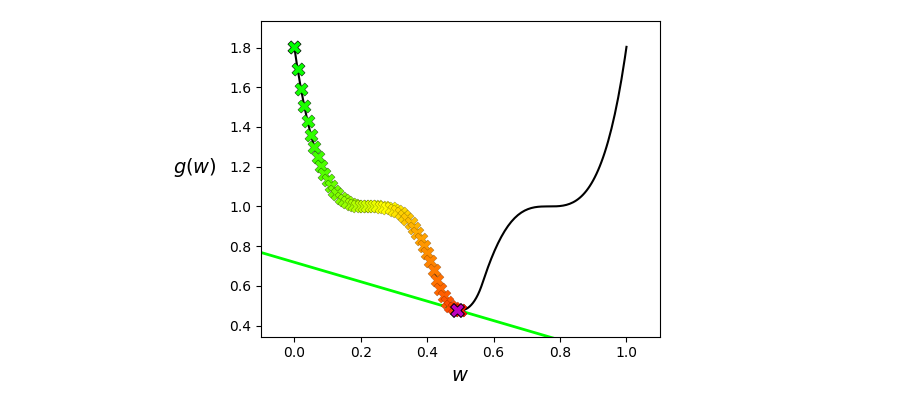
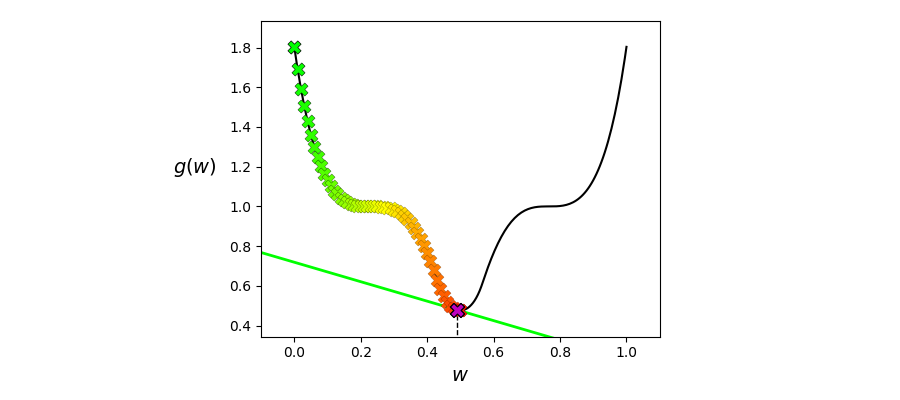
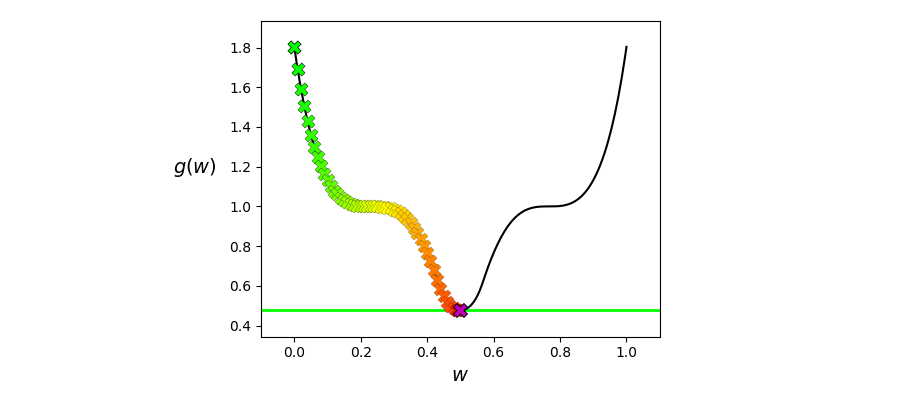
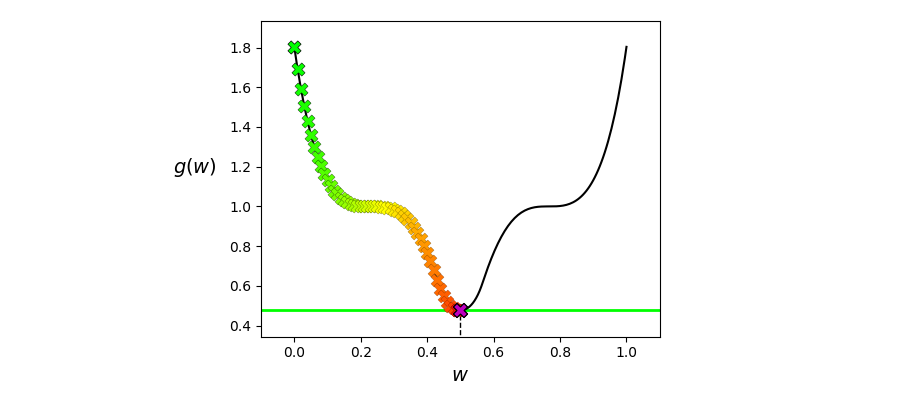
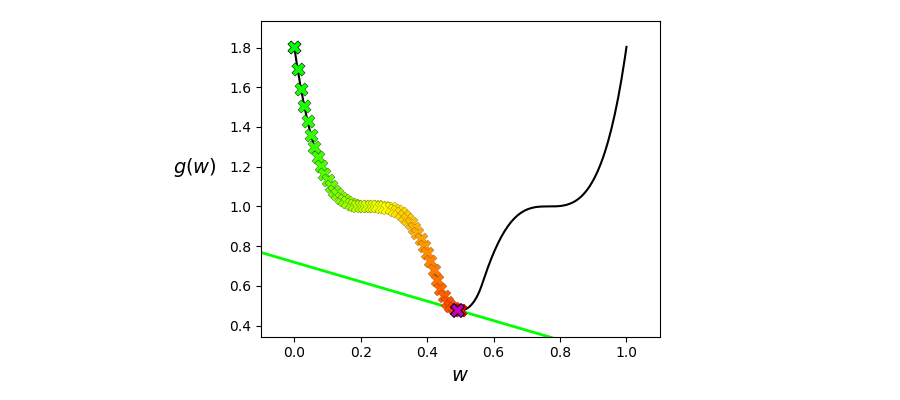
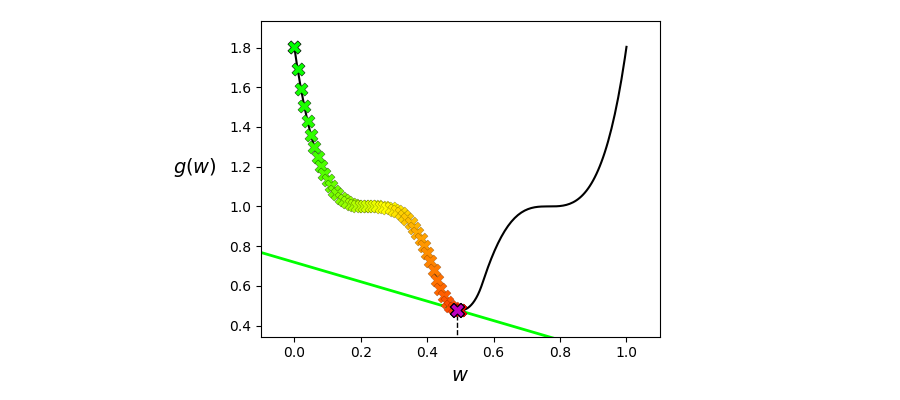
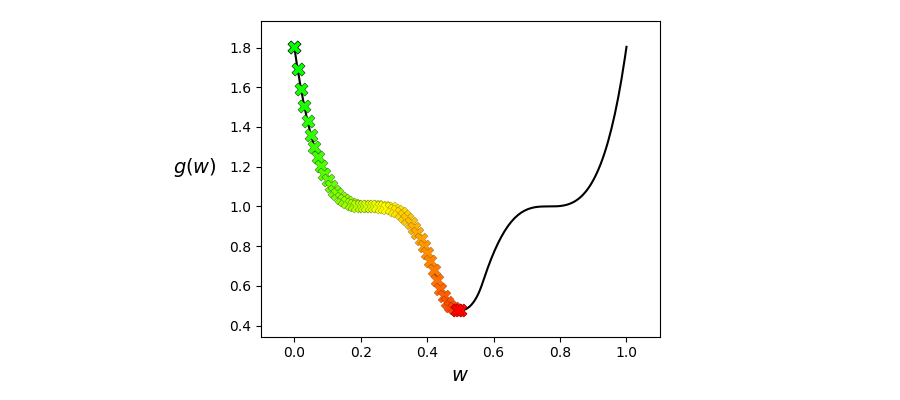

In [5]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.maximum(0,(3*w - 2.3)**3 + 1)**2 + np.maximum(0, (-3*w + 0.7)**3 + 1)**2

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();

demo.animate_2d(g=g, w_init = 0,steplength = 0.01,max_its = 55,version = 'normalized',wmin = 0,wmax = 1)

Place the slider all the way to its full right position, so that the final point is colored red and no linear approximation is shown.  Now, lets discuss the convergence behavior of this run by examining the results above experiment and the general form of the $k^{th}$ step in the normalized method

$$
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }
$$

which of course involves normalizing the length of the gradient at each step.  This means even if $\left\Vert \nabla g\left(\mathbf{w}^{\,k-1}\right) \right\Vert_2$ is very small in magnitude (but non-zero), as it is near the saddle point of the function here, the descent direction $ \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }$ has length one.  Thus steps near a stationary point still - as derived above - have length given by the value of the steplength parameter $\alpha$.  So unlike the unnormalized approach here if the length of the gradient gets small, the length of the steps stay the same.  This has the practical advantage allowing the normalized version of gradient descent to naturally *pass over saddle points of non-convex functions* as it did in this example. 

In the next Python cell we compare normalized and unnormalized gradient descent (left and right panels respectively) on the non-convex function used above.  Both algorithms use the same initial point ($w^0 = 0$), steplength parameter ($\alpha = 0.01$), and maximum number of iterations (55 each).  Steps are colored from green to red to indicate the starting and ending points of each run, with circles denoting the actual steps in the input space and 'x''s denoting their respective function evaluations.  Notice how - due to the re-scaling of each step via the derivative length - the unnormalized version halts at the function's saddle point, while the normalized version rushes past it as shown above. 

<IPython.core.display.Javascript object>


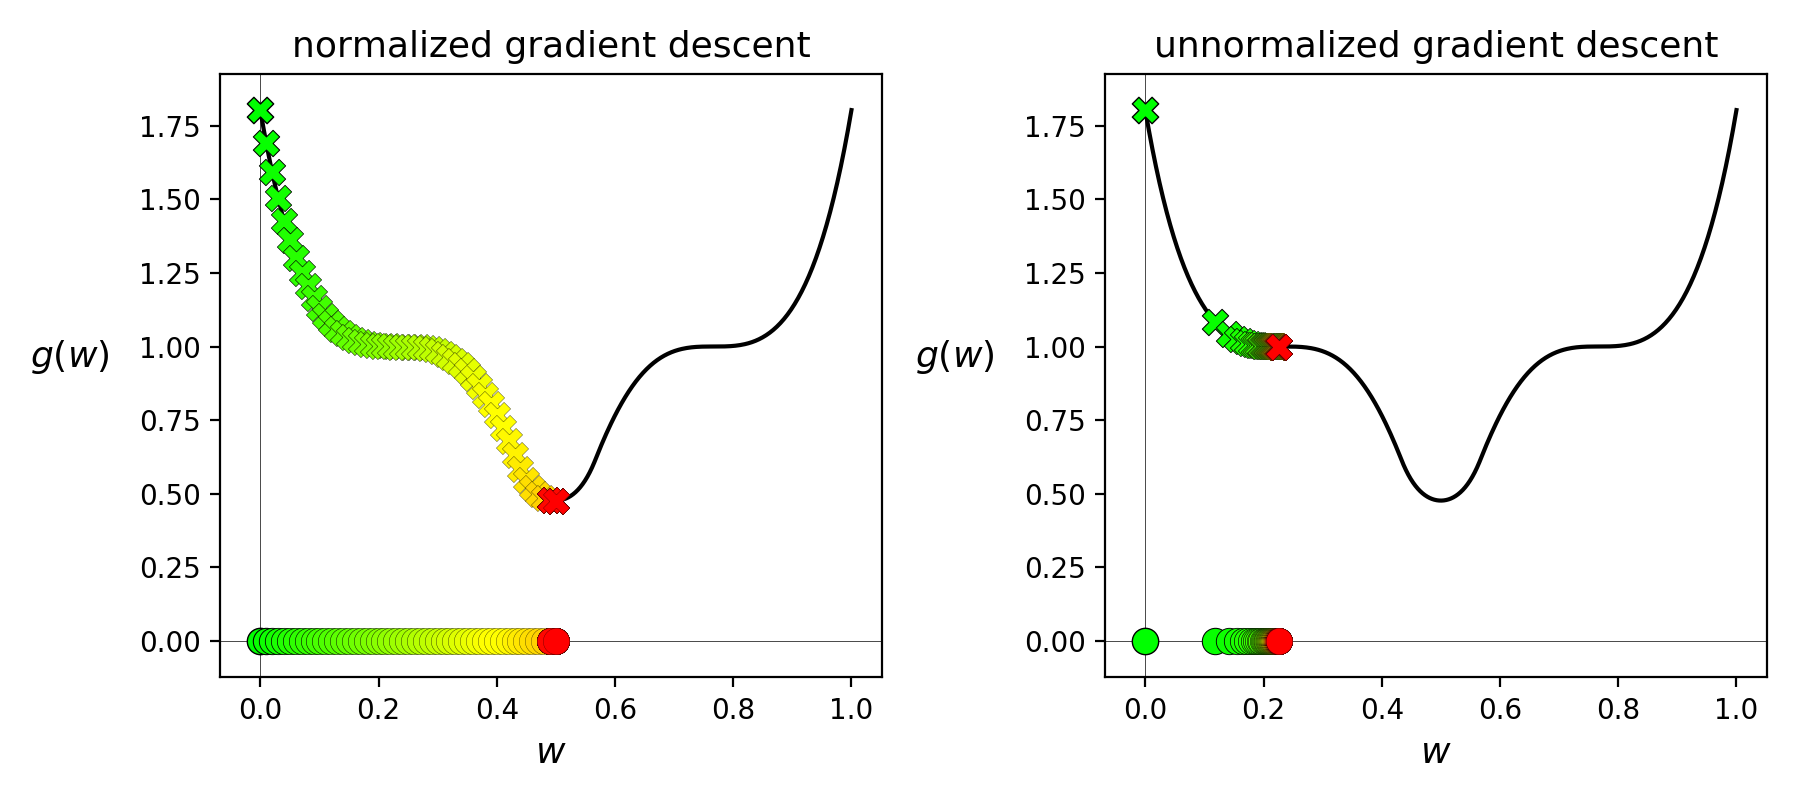

In [6]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.maximum(0,(3*w - 2.3)**3 + 1)**2 + np.maximum(0, (-3*w + 0.7)**3 + 1)**2

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();

demo.compare_versions_2d(g=g, w_init = 0,steplength = 0.01,max_its = 80,version = 'normalized',wmin = 0,wmax = 1)

Another example: a function with large flat areas


$$
g(w_1,w_2) = -e^{-\left(w_1^2 + w_2^2\right)} + 1
$$

to compare how normalized and unnormalized gradient descent deal with large regions of an input space where the gradient is almost zero.  This function has a single global minimum at the origin and comparing the two - as we do in the next Python cell - we can see that even when beginning on an almost completely flat area of the input space the normalized method can quickly find this minimum, whereas the unnormalized version can barely start moving in the right direction.  More specifically, we initialize both algorithms at the point $\mathbf{w}^0 = \begin{bmatrix} -3 \\ -2 \end{bmatrix}$ use the diminishing steplength parameter $\alpha = \frac{1}{k}$, and take 20 steps with each version.  The top two panels display the function from the side (left panel) and from above (right panel) for the normalized version, and likewise the bottom two panels display the results of the unnormalized version.

<IPython.core.display.Javascript object>


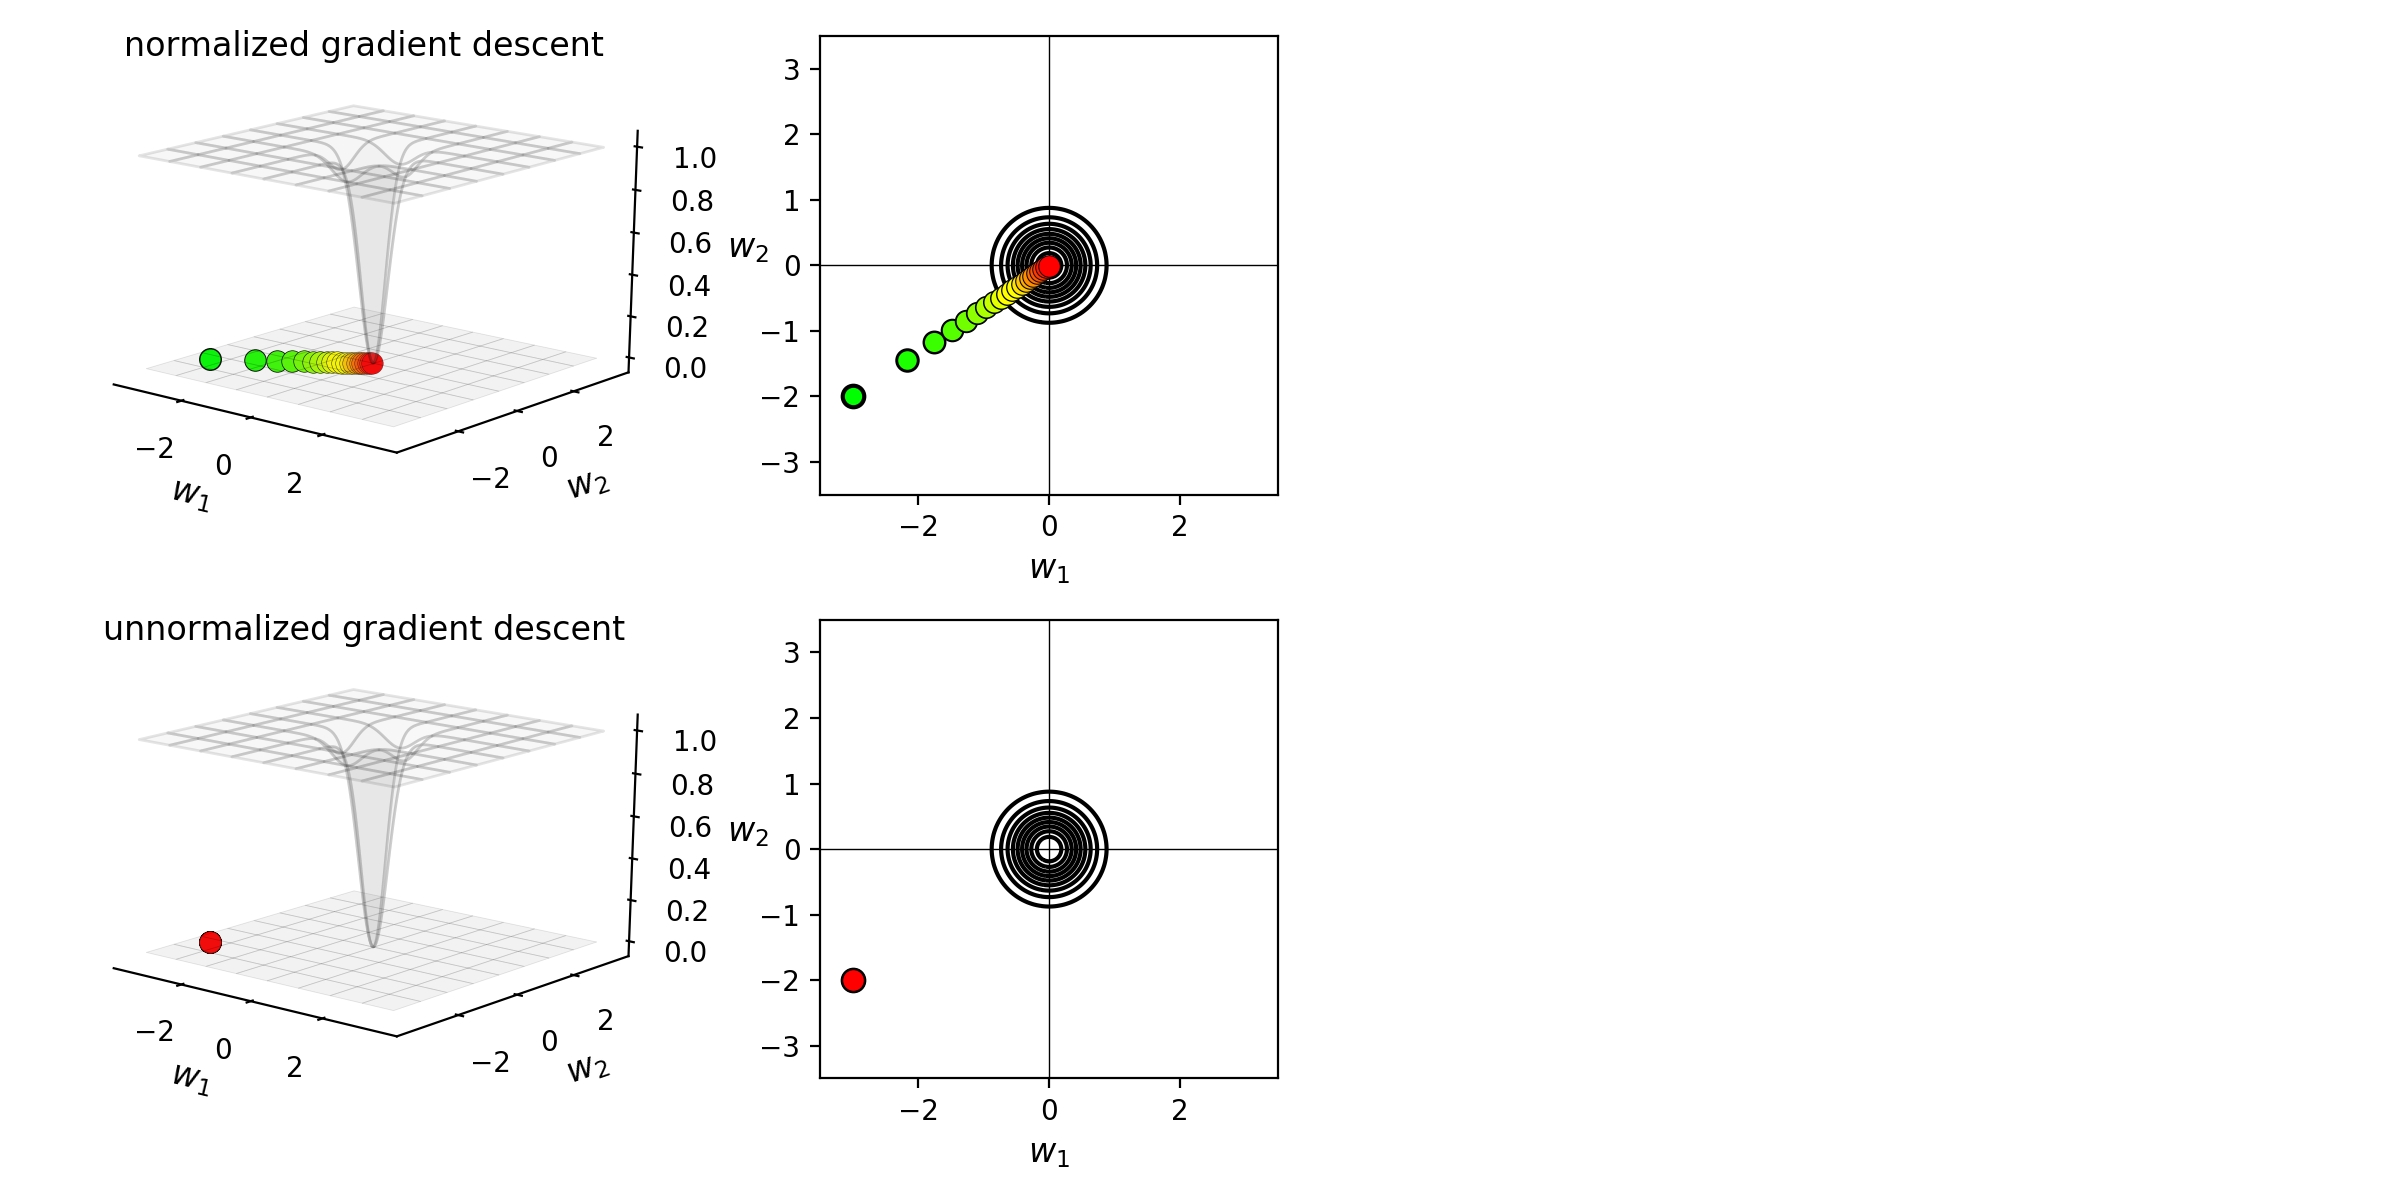

In [4]:
# what function should we play with?  Defined in the next line.
g = lambda w: -np.exp(-3*(w[0]**2 + w[1]**2))  + 1 

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();
w_init = [-3,-2]; max_its = 20; steplength = 'diminishing';

demo.compare_versions_3d(g,w_init,steplength,max_its,wmax=3)

## 1.5  Convergence behavior and steplength parameter selection

When do we know gradient descent has reached a local minimum?  In other words, how do we know when to stop the algorithm? 

1. If the *length (or magnitude) of the gradient* $\left\Vert \nabla g\left(\mathbf{w}^{\,k-1}\right)\right\Vert_2$ is *small* then the algorithm has by definition reached a stationary point of the function.

2. After a maximum number of iterations: not mathematically rigorous but *practical and fast* (comparatively speaking).

Halting the procedure after a pre-set number of maximum iterations is a common stopping condition for gradient descent in the machine learning / deep learning community, as finding points that are infinitesimally close to a minimum is not a goal in and of itself - it is the performance of the associated learning problem that is important.

**What is good number for a maximum iteration count?**

This is typically set manually/heuristically, and is influenced by things like computing resources, knowledge of the particular function being minimized, and - very importantly - the choice of the steplength parameter $\alpha$.  Smaller choices for $\alpha$ - while more easily providing descent at each step - frequently require more for the algorithm to achieve significant progress.

**What is a good steplength value?**

- There are a variety of mathematical tools we will detail in the next post that can give guidance as to how to set $\alpha$ in general.

- Often in practice in machine learning / deep learning problems the steplength parameter $\alpha$ is determined by *trial and error*.  This often includes running gradient descent a number of times while trying out different fixed $\alpha$ values, or various diminishing steplength schemes, to determine which provides the lowest function value.